# Análisis predictivo de series temporales

-----

## Predicción en modelos ARMA, modelos ARIMA y resumen.


In [30]:
## Ejemplo: instalación de astsadata usando pip:
#!pip install astsadata

## Ajusto tamaño de figuras
import matplotlib.pyplot as plt
import astsadata as astsa
import numpy as np
import statsmodels.api as sm
import pandas as pd

plt.rcParams['figure.figsize'] = [15,5]
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.constrained_layout.use'] = True

## Predicción en modelos ARMA

**Idea:** dado un modelo ARMA(p,q) de parámetros $\phi_1,\ldots,\phi_p$ y $\theta_1,\ldots,\theta_q$, y posiblemente una media $\mu$, es decir un proceso:

$$ x_t - \mu = \phi_1 (x_{t-1} - \mu) + \ldots + \phi_p(x_{t-p}-\mu) + w_t + \theta_1 w_{t-1} + \ldots +\theta_q w_{t-q},$$

donde $w_t$ es ruido blanco Gaussiano de varianza $\sigma_w^2$.

**Pregunta:**

¿Cuál es la mejor predicción que uno puede hacer de $x_{t+n}$ conociendo los valores del proceso $x_0,\ldots,x_t$ y los parámetros?

### El caso AR(p)

Supongamos $\mu=0$ (en otro caso, simplemente centramos por la media). Este caso ya lo discutimos, si conocemos el proceso hasta tiempo $n$, entonces sabemos que:

$$x_{n+1} = \phi_1 x_n +\ldots + \phi_p x_{n-p+1} + w_{n+1},$$

El mejor predictor $\hat{x}_{n+1}^n$ en términos de error cuadrático medio es un predictor lineal:

$$\hat{x}_{n+1}^n = \alpha_0 + \sum_{k=1}^n \alpha_k x_k,$$

que debe satisfacer las *ecuaciones de predicción*:

$$E[(x_{n+1} - \hat{x}_{n+1}^n)x_k]=0 \quad \forall k=0,\ldots,n,$$

es decir, el error de predicción no debe estar correlacionado con ninguna de las muestras anteriores (extrajimos "toda la información").

Notemos que es muy fácil resolver esto en el caso del $AR(p)$ ya que tomando como predicción:

$$\hat{x}^n_{n+1} = \phi_1 x_n +\ldots + \phi_p x_{n-p+1},$$

se tiene que $x_{n+1} - \hat{x}^n_{n+1} = w_{n+1}$ que sabemos no está correlacionado con ninguna muestra anterior!

Es decir, simplemente propagando la recursión como si el ruido fuera $0$ obtenemos la mejor predicción (hay que demostrar esto para $n+2$, $n+3$, etc.)


### El caso ARMA(p,q)

En el caso general no resulta tan sencillo resolver las ecuaciones de predicción, y debemos usar toda la historia del proceso. Consideremos el caso de predicción a un paso:

Construyo un estimador:

$$\hat{x}^n_{n+1} = \phi_{n1}x_n + \ldots +\phi_{nn}x_1 = \phi_n^T x$$

siendo $x=(x_1,\ldots,x_n)$ el vector con todos los valores anteriores.

Planteando la ecuación de predicción queda:

$$E[(x_{n+1} - \sum_{j=1}^n \phi_{nj}x_{n+1-j})x_{n+1-k}] = 0, \quad k=1,\ldots,n.$$

Haciendo la distributiva queda:

$$E[x_{n+1}x_{n+1-k}] =  \sum_{j=1}^n \phi_{nj}E[x_{n+1-j}x_{n+1-k}] = 0, \quad k=1,\ldots,n.$$

Identificando las covarianzas nos queda el siguiente sistema de ecuaciones:

$$\gamma(k) =  \sum_{j=1}^n \phi_{nj}\gamma(k-j), \quad k=1,\ldots,n.$$

Lo anterior es un sistema de ecuaciones de la forma:

$$\Gamma_n \phi_n = \gamma_n.$$

Resolviendo el sistema salen los coeficientes.

**Nota:** debemos tener calculadas las covarianzas del modelo!

También se puede calcular la *varianza* del error de predicción para hacer intervalos de confianza, y queda:

$$P_{n+1}^n = \gamma(0) - \gamma_n^T \Gamma_n^{-1} \gamma_n.$$

### Problema

La ecuación anterior solo explica como calcular "el paso siguiente" y aún así es muy difícil de resolver si el conjunto de datos es grande (sistema lineal grande). Afortunadamente ambos incovenientes se pueden levantar usando métodos recursivos:

* Algoritmo de Durbin-Levinson.
* Algoritmo de innovaciones.

Estos son los algoritmos que usan las bibliotecas de `python` para predecir. En particular, calculan:

* El mejor predictor lineal $\hat{x}_{n+m}^n$ $m$ muestras adelante.
* La varianza $P^n_{n+m}$ del error, lo que permite construir intervaos de confianza.

### Ejemplo: la serie de Recruitment

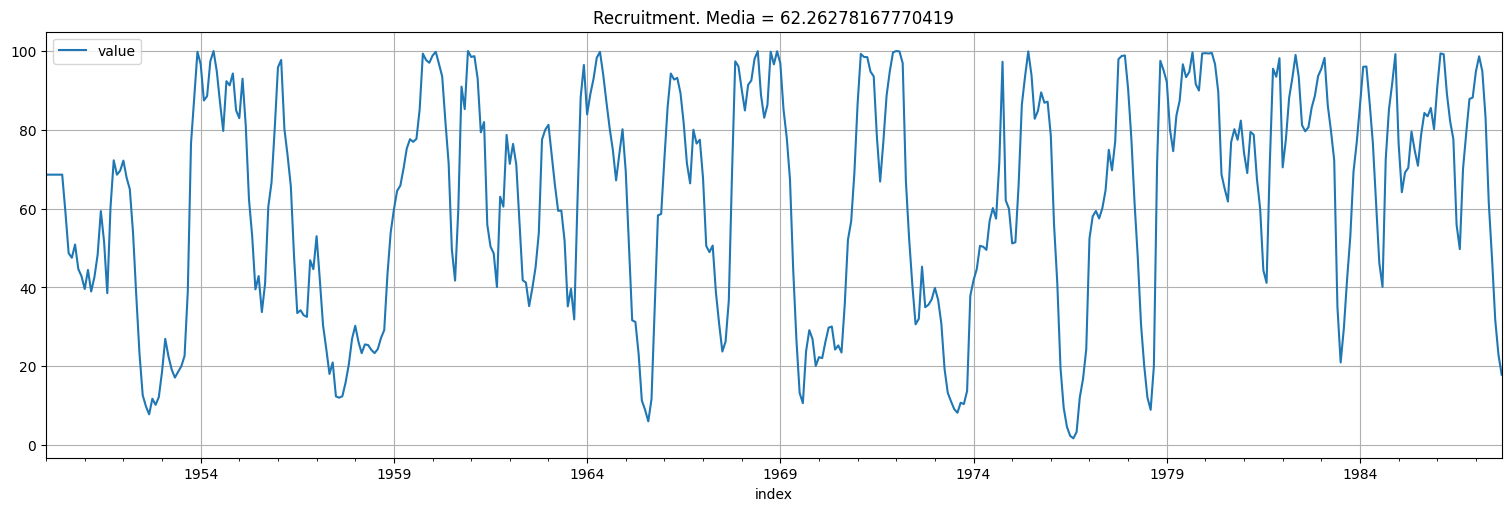

In [31]:
rec = astsa.rec
rec.plot()
plt.title(f"Recruitment. Media = {np.mean(rec)}");

In [32]:
#Usamos la función de statsmodels para ajustar.
#trend="c" nos permite incorporar una tendencia constante (media) al fit.
from statsmodels.tsa.api import ARIMA
fit = ARIMA(rec,order=(2,0,0), trend="c").fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  453
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1661.510
Date:                Wed, 15 May 2024   AIC                           3331.019
Time:                        19:18:16   BIC                           3347.483
Sample:                    01-31-1950   HQIC                          3337.506
                         - 09-30-1987                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         61.8939      4.123     15.013      0.000      53.814      69.974
ar.L1          1.3512      0.041     32.952      0.000       1.271       1.432
ar.L2         -0.4612      0.037    -12.398      0.000      -0.534      -0.388
sigma2        89.3353      5.128     17.420      0.000      79.284      99.387
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                93.63
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                             0.30
Prob(H) (two-sided):                  0.17   Kurtosis:                         5.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

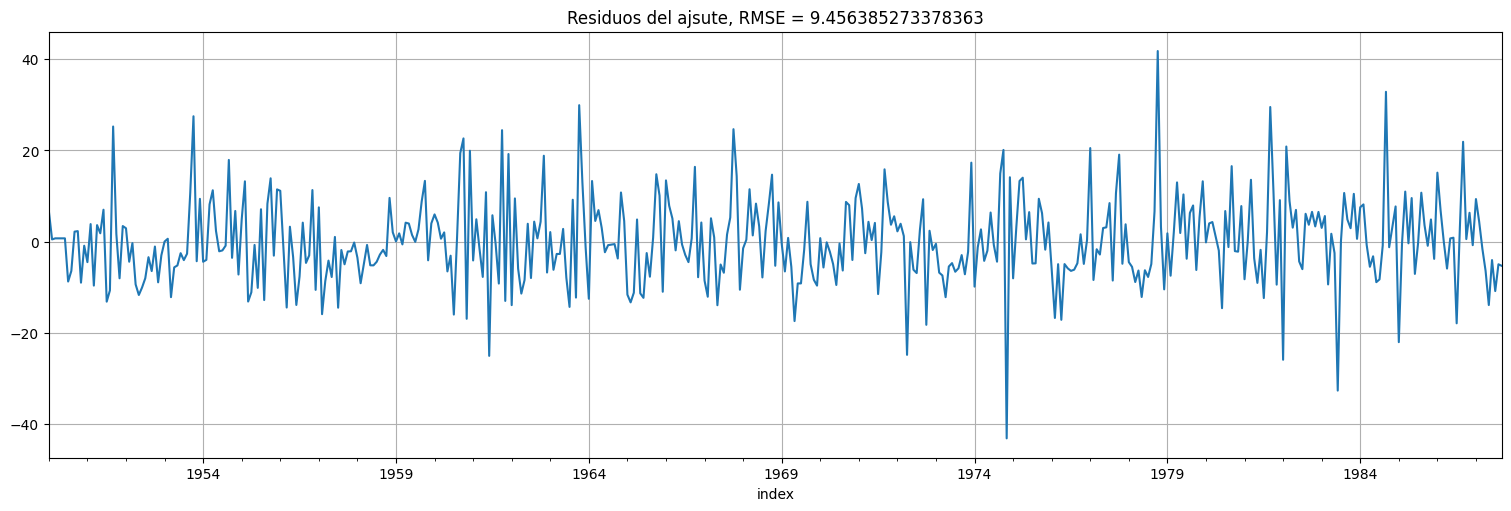

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fit.resid.plot()
plt.title(f"Residuos del ajsute, RMSE = {np.sqrt(fit.mse)}");

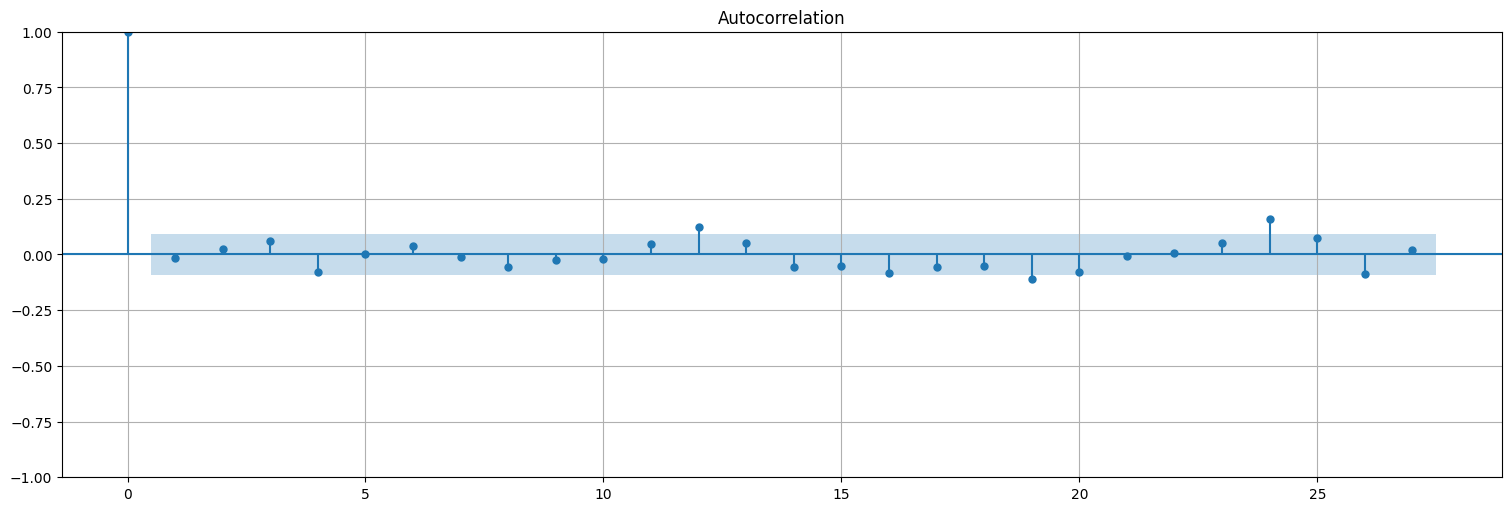

In [34]:
plot_acf(fit.resid,bartlett_confint=False);

## Predicción a futuro

Ahora que tenemos el modelo ajustado, ¿cómo podemos agregar nuevas predicciones usando los algoritmos mencionados?

Text(0.5, 1.0, 'Predicción de la serie rec a 2 años')

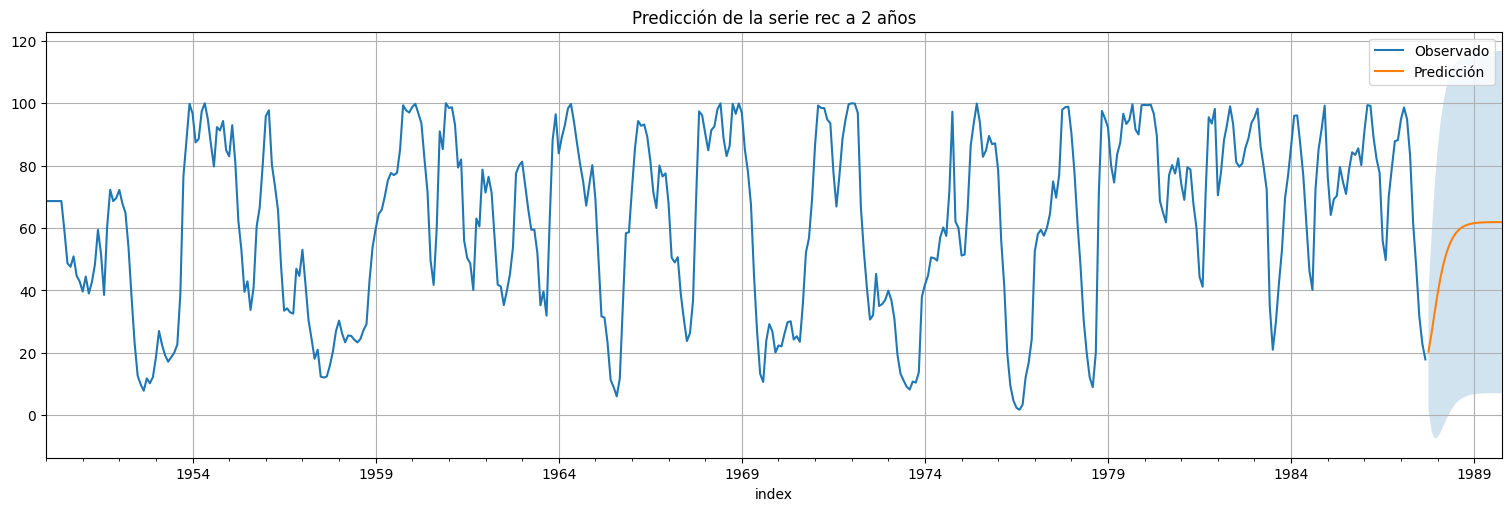

In [35]:
#Usamos el modelo ajustado para predecir a futuro
h = 24 #horizonte de predicción
predicciones = fit.get_prediction(start=rec.size,end=rec.size+h)
xhat = predicciones.predicted_mean
confint = predicciones.conf_int(alpha=0.05) #alpha es la confianza del intervalo
rec.plot()
xhat.plot()
plt.legend(["Observado","Predicción"])
plt.fill_between(xhat.index,confint["lower value"], confint["upper value"], alpha=0.2);
plt.title("Predicción de la serie rec a 2 años")

### Predicción endógena de la serie

Text(0.5, 1.0, 'Predicción de la serie rec a 2 años')

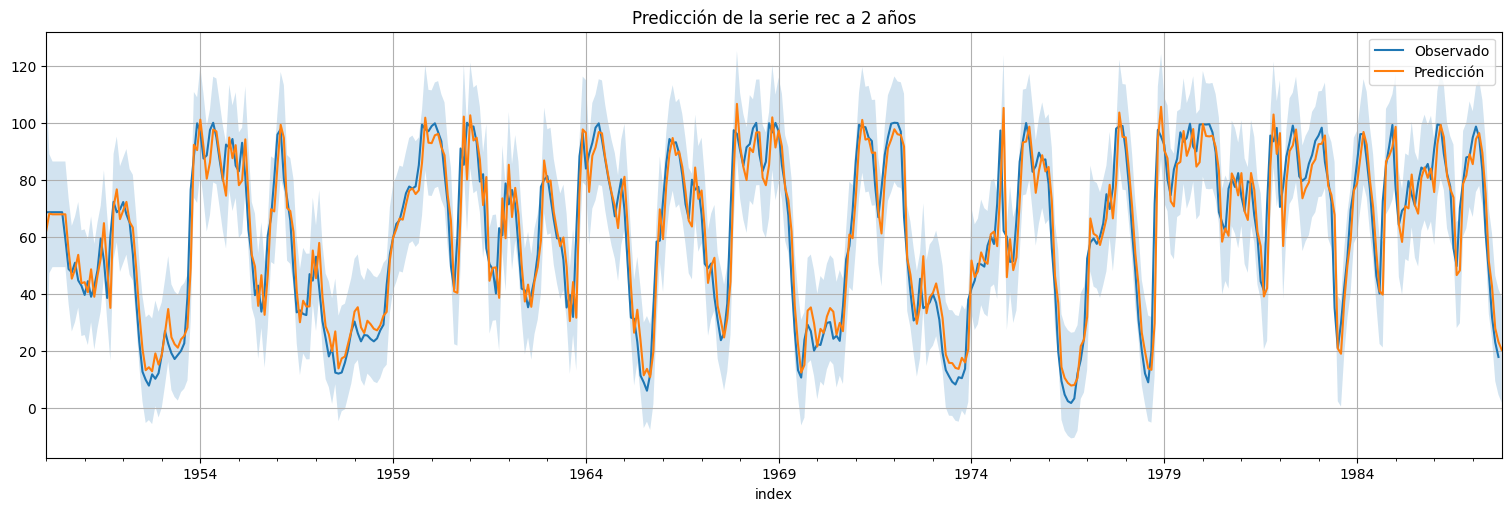

In [36]:
#Usamos el modelo ajustado para predecir a futuro
h = 24 #horizonte de predicción
predicciones = fit.get_prediction(start=0,end=rec.size)
xhat = predicciones.predicted_mean
confint = predicciones.conf_int(alpha=0.05) #alpha es la confianza del intervalo
rec.plot()
xhat.plot()
plt.legend(["Observado","Predicción"])
plt.fill_between(xhat.index,confint["lower value"], confint["upper value"], alpha=0.2);
plt.title("Predicción de la serie rec a 2 años")

## Modelos ARIMA

En algunos casos, la serie de datos $x_t$ no es estacionaria, y no alcanza con "sacarle el trend" para volverla estacionaria.

### Ejemplo: consideremos el paseo al azar:

$$x_{t} = x_{t-1} + \delta + w_t$$

con $w_t$ ruido blanco de varianza $\sigma^2_w$. Este proceso no es estacionario (tiene una tendencia $\delta t$ de pendiente $\delta$).

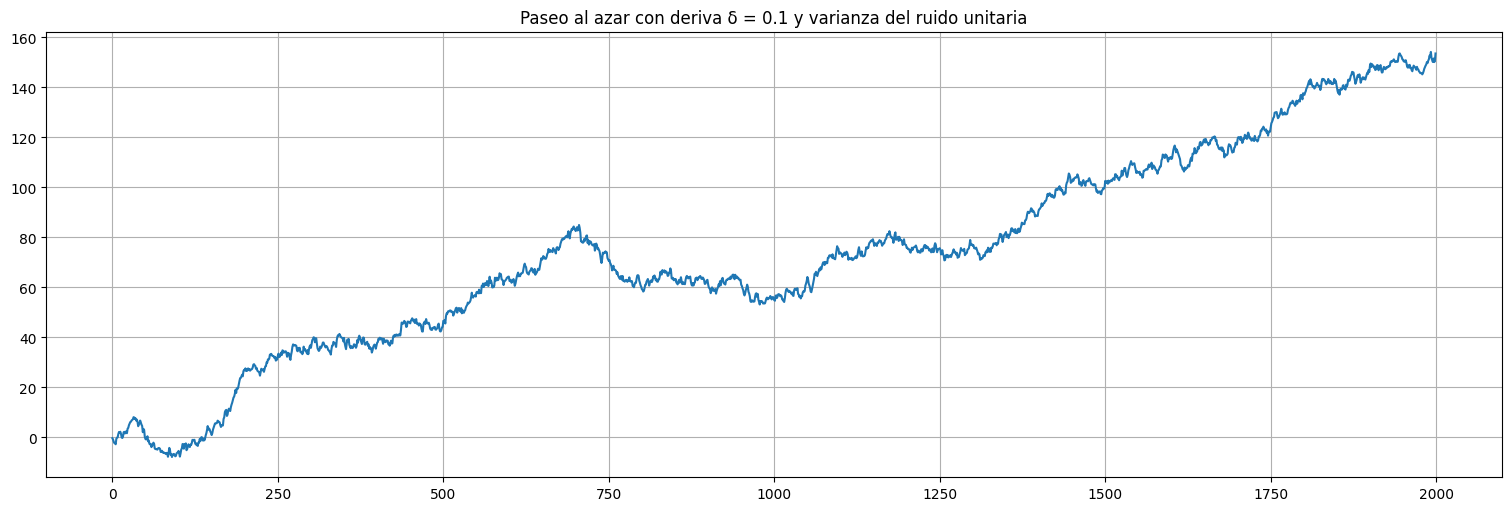

In [37]:
## Simulación de un paseo al azar con deriva
delta = 0.1
w = np.random.normal(loc=0,scale=1,size=2000)
x = np.cumsum(w+delta)
x = pd.Series(x)
x.plot()
plt.title(f"Paseo al azar con deriva δ = {delta} y varianza del ruido unitaria");

#### Idea: tomar diferencias de la serie.

Sea:

$$y_t = x_t - x_{t-1} = x_{t-1} + \delta + w_t - x_{t-1} = \delta +w_t$$

Es decir, al tomar diferencia la serie se vuelve ruido blanco puro en este caso (estacionario), a menos de la media.

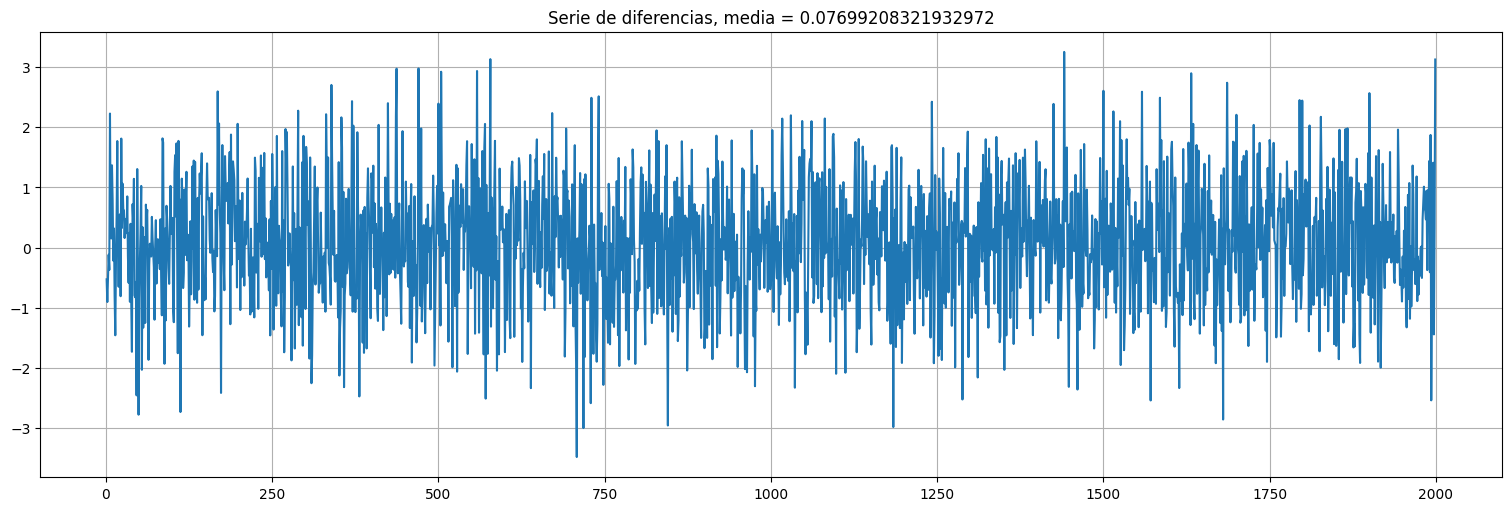

In [38]:
y = x.diff().dropna() #diferencio la serie en pandas directamente. El dropna es para eliminar el primer valor que no tengo.
y.plot()
plt.title(f"Serie de diferencias, media = {np.mean(y)}");

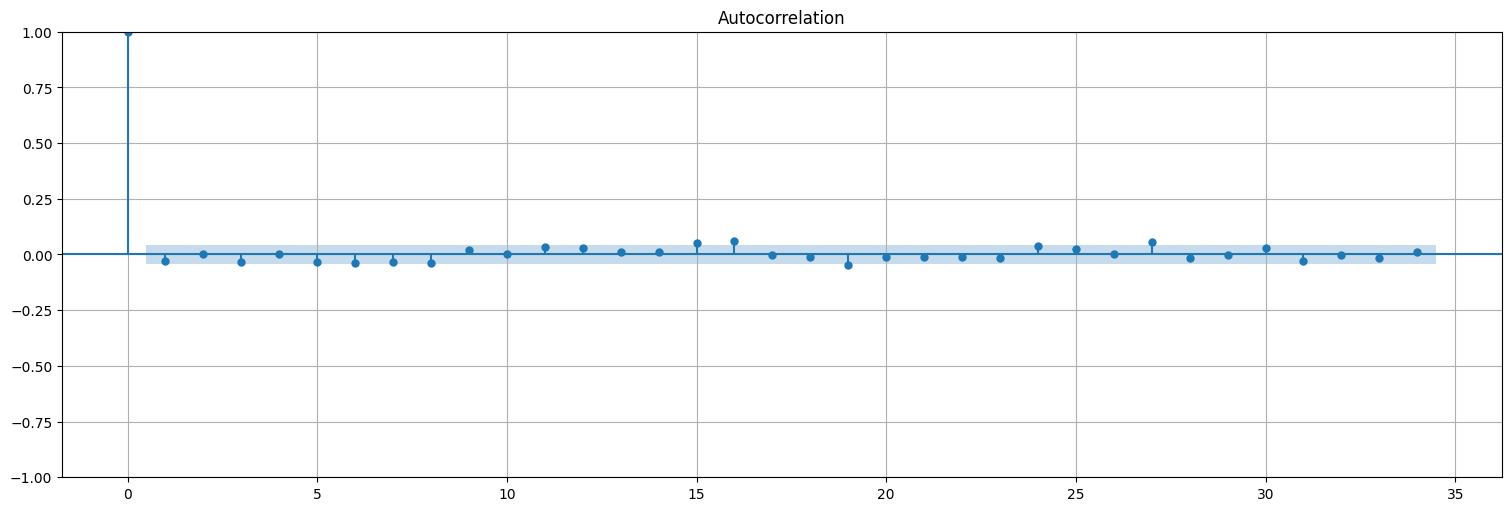

In [39]:
plot_acf(y,bartlett_confint=False);

### Ejemplo: serie con trend lineal.

Supongamos que:
$$x_t = \mu_t + y_t$$

con $\mu_t = \beta_0 + \beta_1 t$ e $y_t$ estacionario. Entonces (introduciendo el operador $\nabla$ para las diferencias):

$$\nabla x_t = x_{t}- x_{t-1} = \mu_t + y_t - \mu_{t-1} - y_{t-1} = \beta_1 + \nabla y_t.$$

Es decir, la nueva serie "diferenciada" tiene una media $\beta_1$ que sale de la pendiente de la recta de tendencia y una componente estacionaria que es la diferencias de la serie $y$ anterior.

**Nota:** en general, si el "trend" es un polinomio de grado $n$, diferenciar $n$ veces elimina el trend.

### Modelo ARIMA

Esto lleva a la definición del modelo $ARIMA(p,d,q)$ genérico.

**Definición:** decimos que una serie $x_t$ es $ARIMA(p,d,q)$ si:
$$y_t = \nabla^d x_t$$

es un $ARMA(p,q)$. Es decir, si diferenciar la serie $d$ veces produce un proceso $ARMA$. El nuevo parámetro $d$ es la cantidad de veces a diferenciar.

#### Ajuste de modelos ARIMA

Para el ajuste de modelos ARIMA, simplemente podemos reutilizar todo lo visto para $ARMA(p,q)$ una vez que sabemos cuántas veces hay que diferenciar ($d$). O sea, lo único nuevo es "descubrir" el $d$ necesario para que la serie quede estacionaria. Típicamente no se usa $d$ muy grande.

### Ejemplo

Consideremos que tenemos una serie $x_t$ de la forma:

$$x_t = \beta_0 + \beta_1 t + z_t$$

con $z_t$ tal que $\nabla z_t$ es autorregresivo de orden $1$ y coeficiente $0.8$.

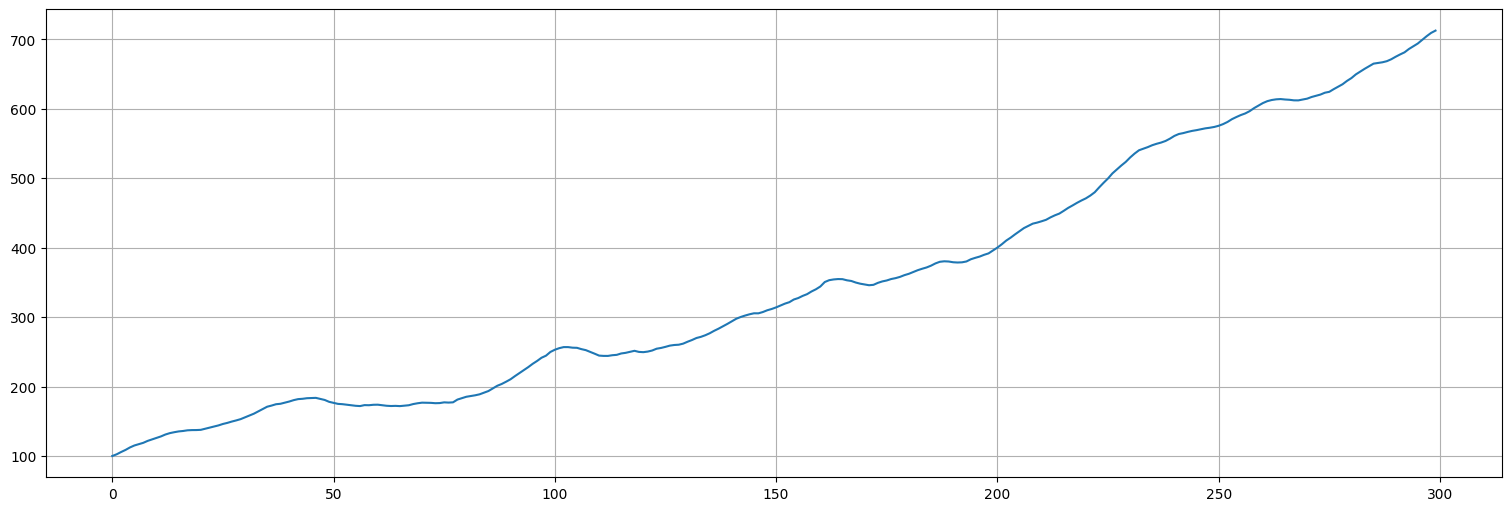

In [51]:
from statsmodels.tsa.api import arma_generate_sample
beta0 = 100
beta1 = 2
phi=0.9
z = arma_generate_sample([1,-phi],[1],300)
noise = np.cumsum(z)
x = beta0+beta1*np.arange(0,300)+noise
x = pd.Series(x)
x.plot();

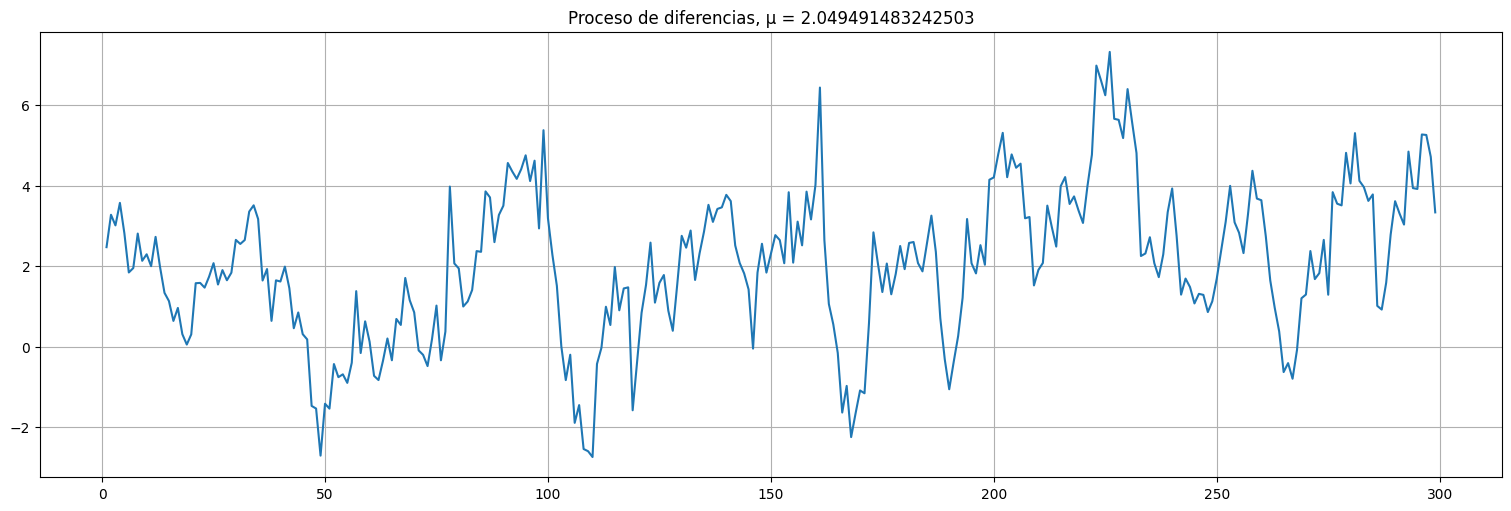

In [52]:
#Al diferenciar recupero z pero con media beta1.
y = x.diff().dropna()
y.plot()
plt.title(f"Proceso de diferencias, μ = {np.mean(y)}");

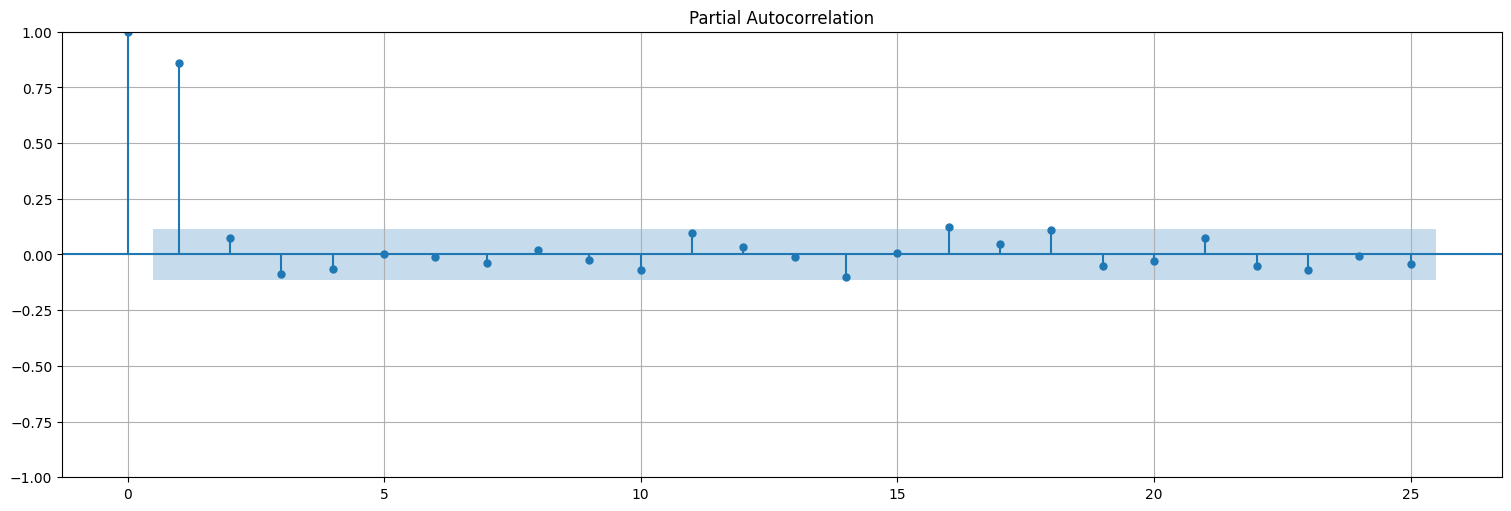

In [53]:
#las correlaciones confirman la estacionariedad (parece un AR(1) en este caso)
plot_pacf(y);

In [54]:
##Ajusto directo un ARIMA a la serie x usando statsplots
## el parámetro include.drift=TRUE permite que la serie d veces diferenciada conserve el drift 
## (la media del resultado de diferenciar)

fit = ARIMA(x,order=(1,1,0), trend="t").fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  300
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -407.365
Date:                Wed, 15 May 2024   AIC                            820.731
Time:                        19:21:22   BIC                            831.832
Sample:                             0   HQIC                           825.174
                                - 300                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.0833      0.390      5.345      0.000       1.319       2.847
ar.L1          0.8598      0.027     31.507      0.000       0.806       0.913
sigma2         0.8891      0.060     14.699      0.000       0.771       1.008
===================================================================================
Ljung-Box (L1) (Q):                   1.40   Jarque-Bera (JB):                10.93
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                             0.06
Prob(H) (two-sided):                  0.58   Kurtosis:                         3.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 1.0, 'Predicción de la serie rec a {h} muestras')

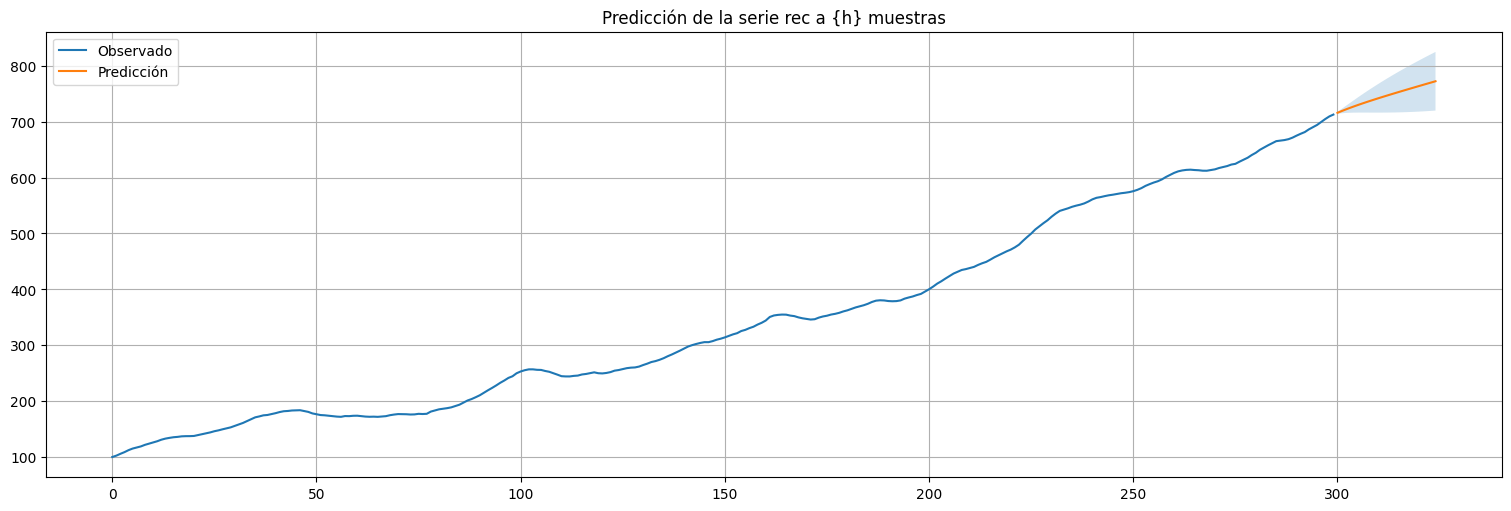

In [55]:
#Usamos el modelo ajustado para predecir a futuro
h = 24 #horizonte de predicción
predicciones = fit.get_prediction(start=x.size,end=x.size+24)
xhat = predicciones.predicted_mean
confint = predicciones.conf_int(alpha=0.05) #alpha es la confianza del intervalo
x.plot()
xhat.plot()
plt.legend(["Observado","Predicción"])
plt.fill_between(xhat.index,confint["lower y"], confint["upper y"], alpha=0.2);
plt.title("Predicción de la serie rec a {h} muestras")

## Resumen: ARMA, ARIMA, ajuste, predicción.

Con todo lo visto, hemos construido una especie de receta (debida a Box-Jenkins) para trabajar con este tipo de modelos, a saber:
 * Graficar los datos
 * Trasnformar los datos (por ejemplo, transformación logarítmica, o detrend o ambos, diferenciación).
 * Identificar los órdenes de dependencia (acf, pacf).
 * Estimación de parámetros (fit, básicamente mínimos cuadrados o máxima verosimilitud).
 * Diagnóstico (análisis de residuos por ejemplo).
 * Elección del modelo (criterios de información tipo AIC, evitar overfitting, etc.)
 * Predicción en base a estimadores lineales calculados recursivamente e intervalos de confianza.
 

### Ejemplo: la serie GNP

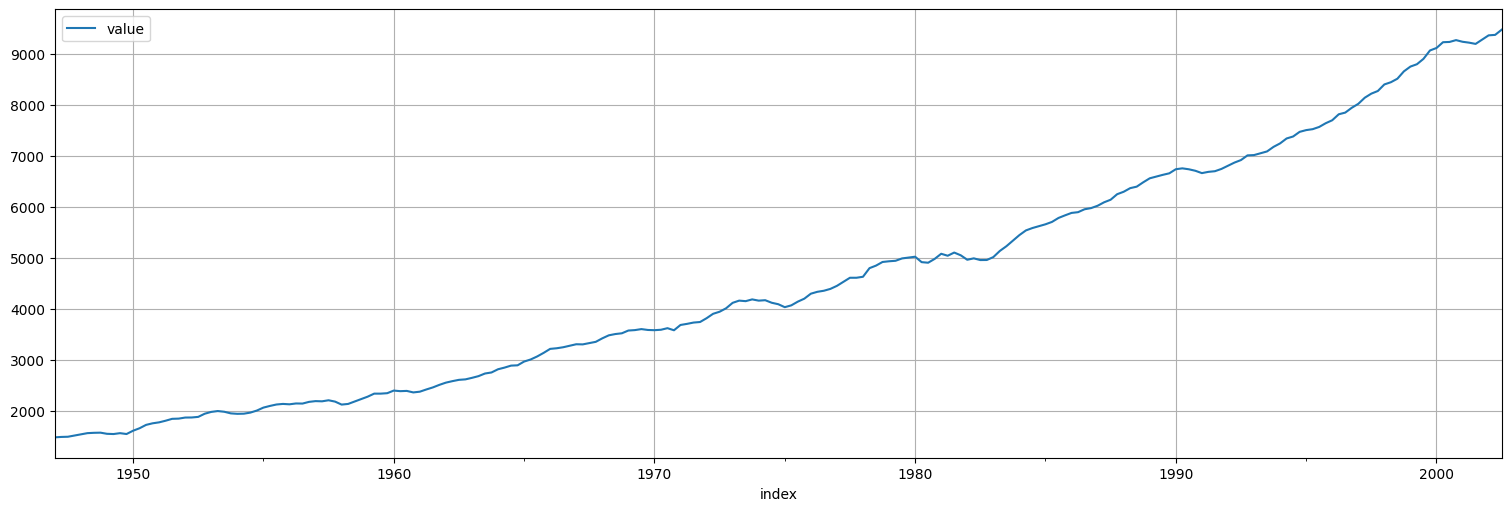

In [57]:
gnp = astsa.gnp
gnp.plot();

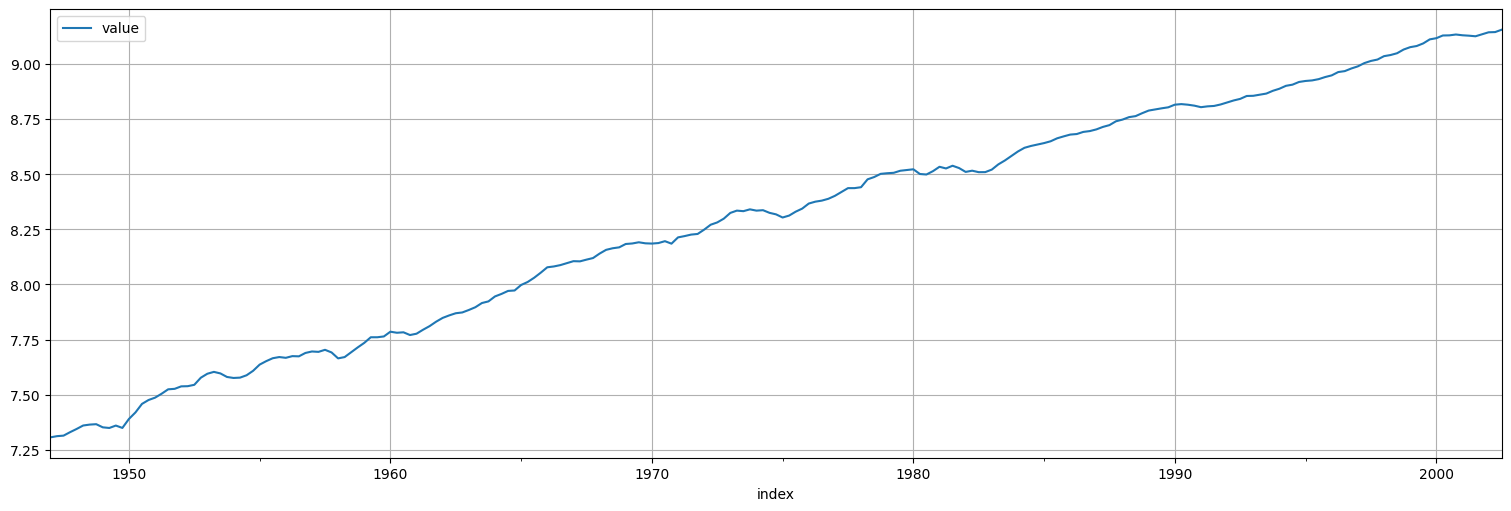

In [59]:
#Transformo por log
x=np.log(gnp)
x.plot();

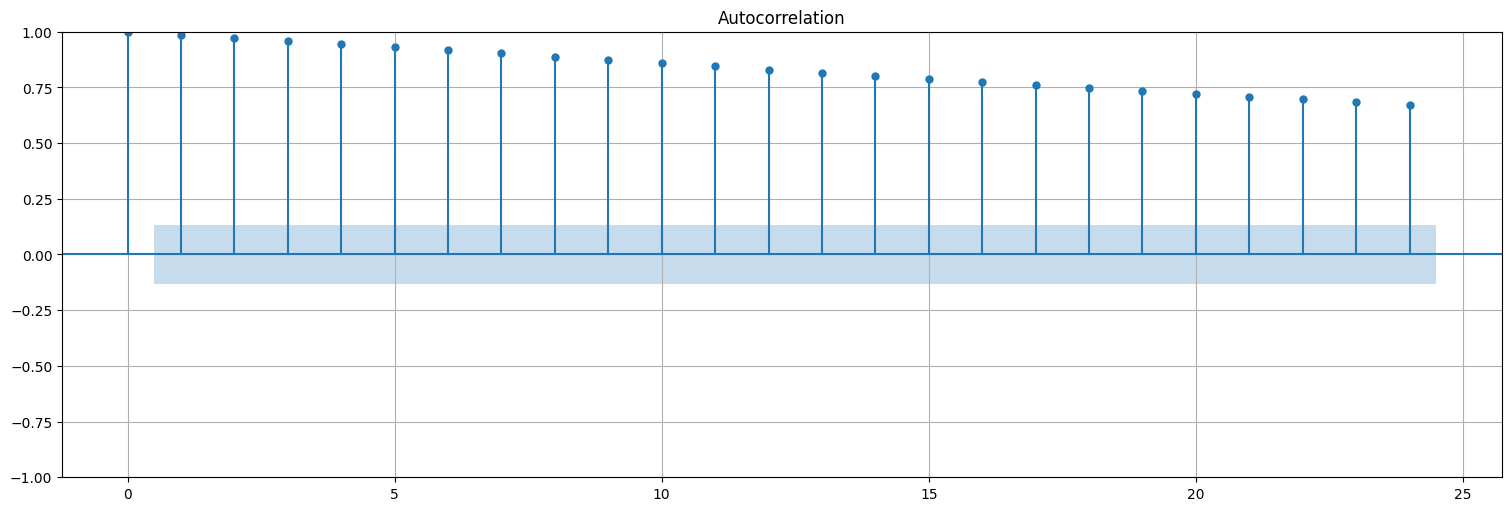

In [61]:
#Hago la ACF solo par ver que no es estacionaria
plot_acf(x, bartlett_confint=False);

Text(0.5, 1.0, 'Serie de diferencias, μ = 0.00833750081288858')

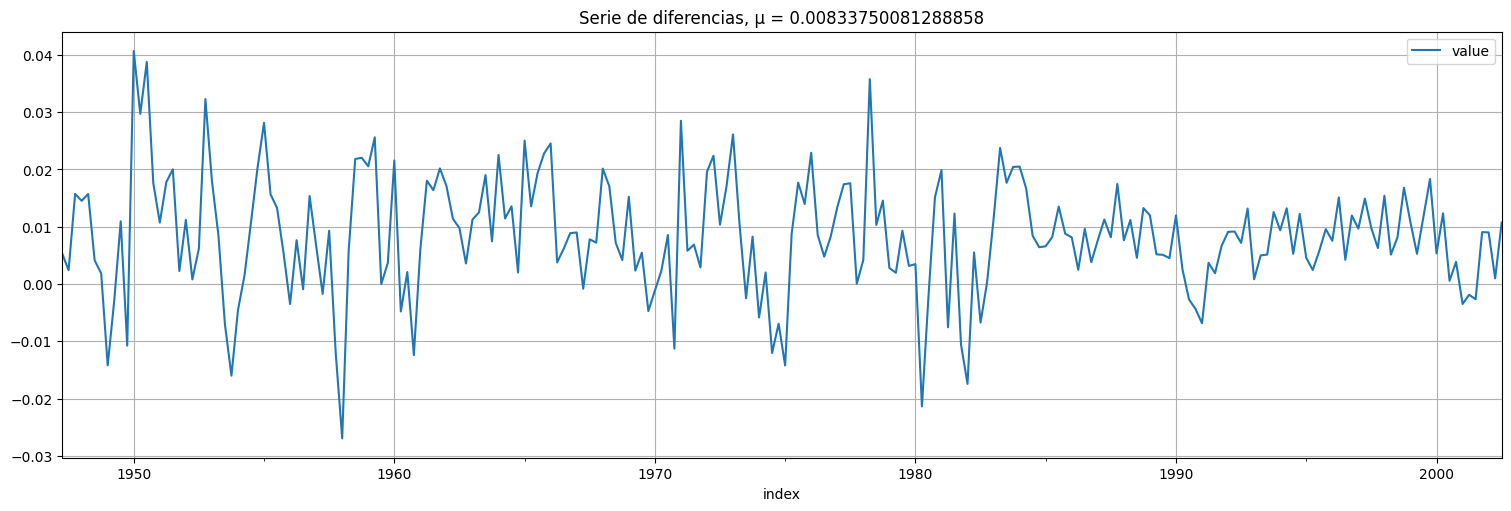

In [65]:
#diferencio y logro estacionariedad
y=x.diff().dropna()
y.plot()
plt.title(f"Serie de diferencias, μ = {np.mean(y)}")

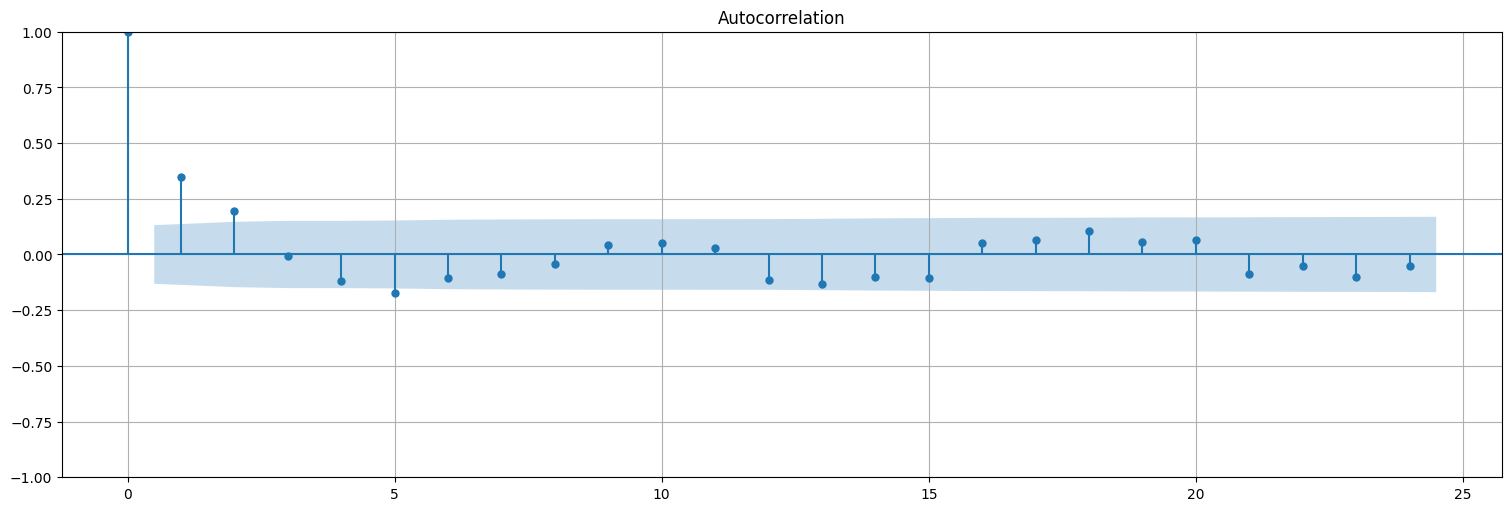

In [67]:
#Este comando hace las dos juntas (acf y pacf)
plot_acf(y);

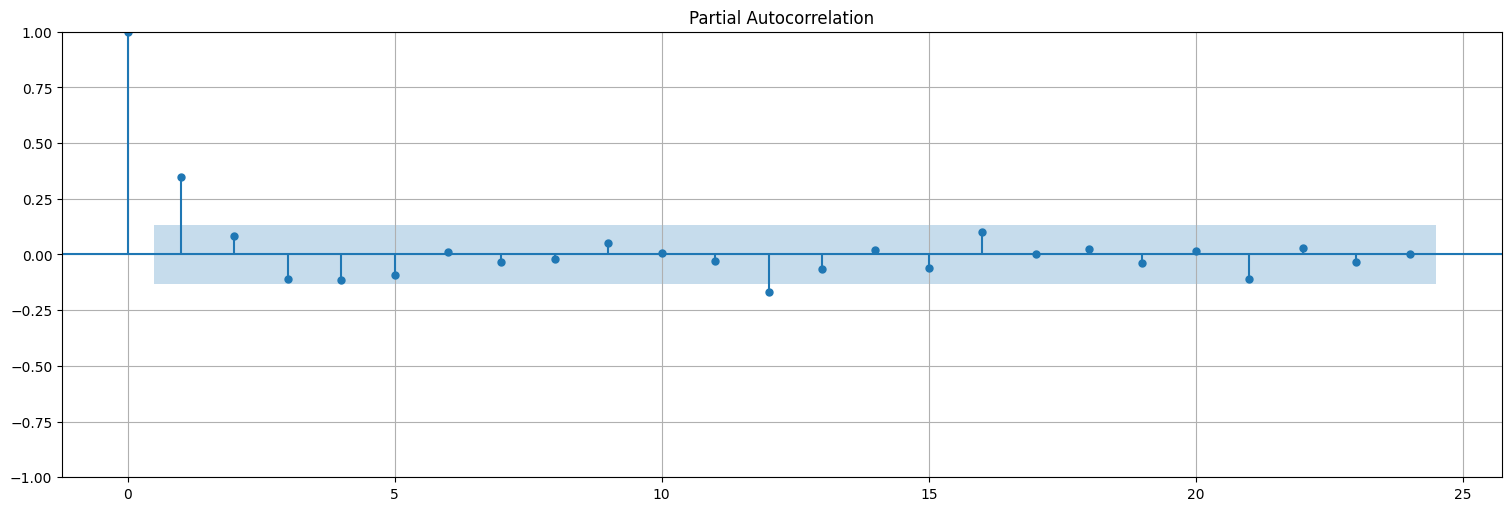

In [69]:
plot_pacf(y);

Mirando lo anterior podemos inclinarnos por dos posibles modelos para $x$:

* ARIMA(1,1,0) ya que diferenciamos una vez y vemos que la PACF corta en 1.
* ARIMA(0,1,2) ya que diferenciamos una vez y vemos que la ACF corta en 2.
* Otras posibilidades a testear. Probemos estas y hagamos diagnóstico


In [87]:
#ARIMA(1,1,0)
fit = ARIMA(x,order=(1,1,0), trend="t").fit()
fit.summary()
print(f"RMSE: {np.std(fit.resid)}")

RMSE: 0.4876687994802122


In [88]:
#ARIMA(0,1,2)
fit = ARIMA(x,order=(0,1,2), trend="t").fit()
fit.summary()
print(f"RMSE: {np.std(fit.resid)}")

RMSE: 0.48766795463492724


### Estadístico de Ljung-Box-Pierce

La serie anterior de residuos parece haber quedado "blanca". Sin embargo, es bueno disponer de un test que permita evaluar si la ACF en su conjunto es razonablemente blanca en lugar de mirar lag a lag. Para ello se usa el *estadístico de Ljung-Box-Pierce*.

$$Q = n(n+2) \sum_{h=1}^H \frac{\hat{\rho}^2_e(h)}{n-h},$$

donde $H$ es una ventana. La idea de este estadístico es acumular varias correlaciones en la ventana $H$ para ver si en su conjunto son todas despreciables (en lugar de una a una).

El estadístico $Q$ es asintóticamente $\chi^2_{H-p-q}$ por lo que si el valor de $Q$ es grande (más que el cuantil $\alpha$ de la $\chi^2$) rechazamos la hipótesis de independencia.

En general lo que se hace es mirar los $p$-valores, es decir cuánta probabilidad queda a la derecha de $Q$. Si es pequeño (ej: $p<0.05$) se rechaza la hipótesis.


	Ljung-Box test

data:  Residuals from ARIMA(1,1,0) with drift
Q* = 9.8183, df = 7, p-value = 0.1991

Model df: 1.   Total lags used: 8



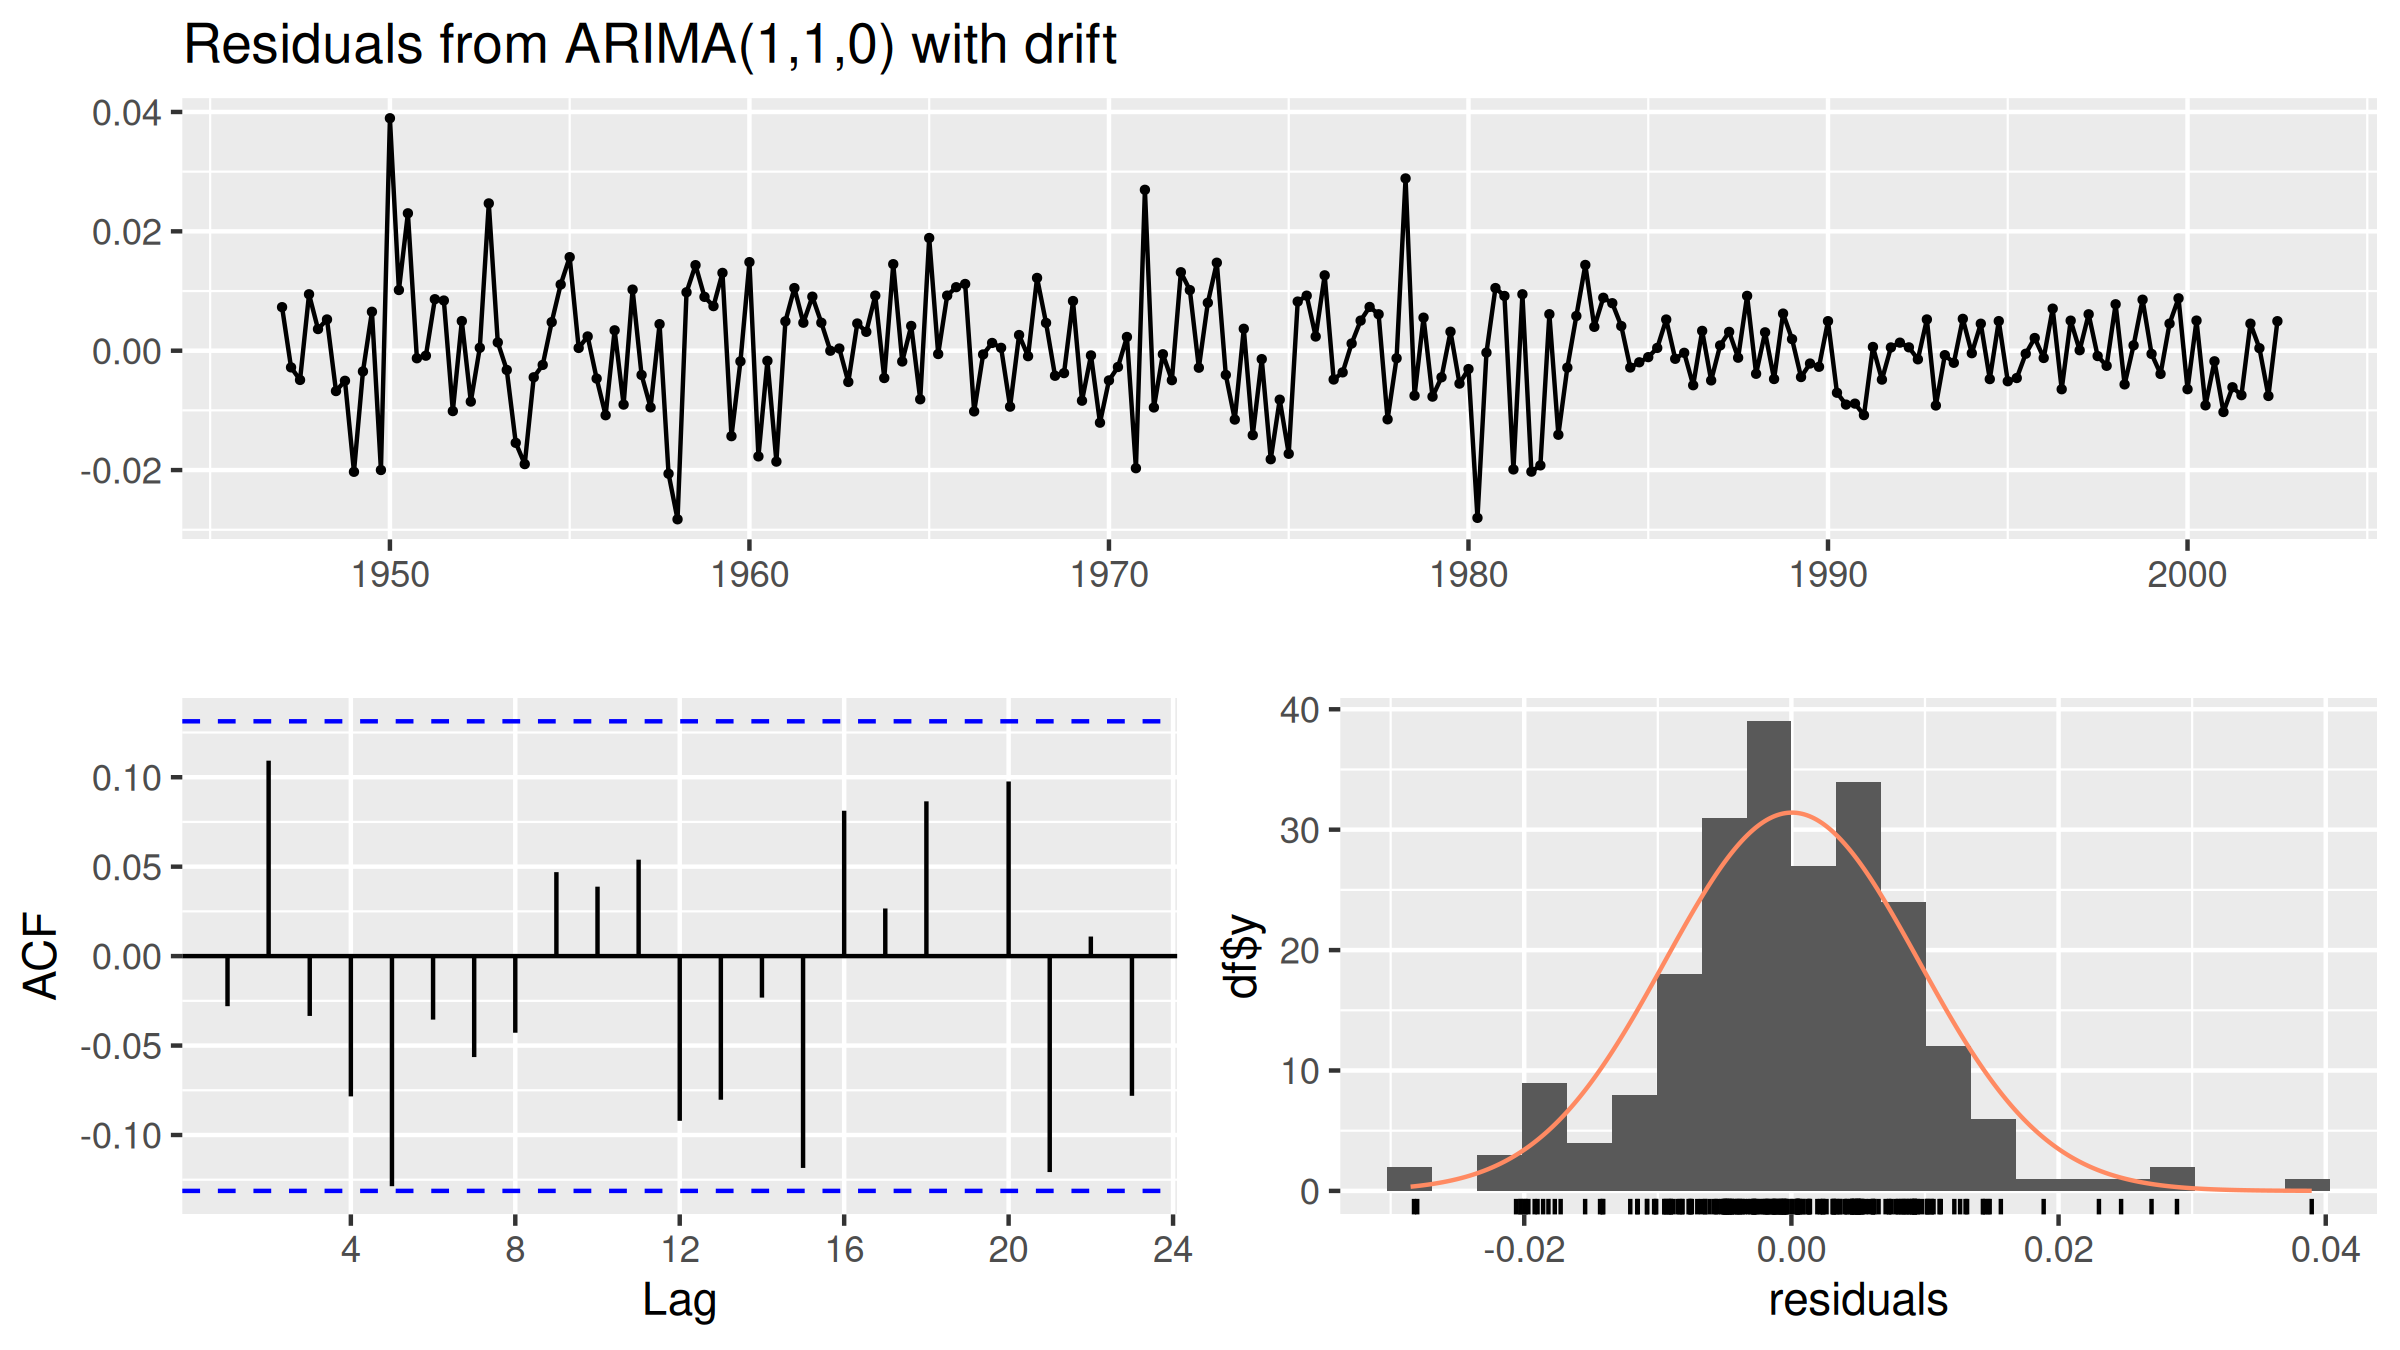

In [27]:
checkresiduals(fit)

In [28]:
#ARIMA(0,1,2)
fit2 = Arima(x,order=c(0,1,2), include.mean=FALSE, include.drift = TRUE)
fit2

Series: x 
ARIMA(0,1,2) with drift 

Coefficients:
         ma1     ma2   drift
      0.3028  0.2035  0.0083
s.e.  0.0654  0.0644  0.0010

sigma^2 = 9.066e-05:  log likelihood = 719.96
AIC=-1431.93   AICc=-1431.74   BIC=-1418.32

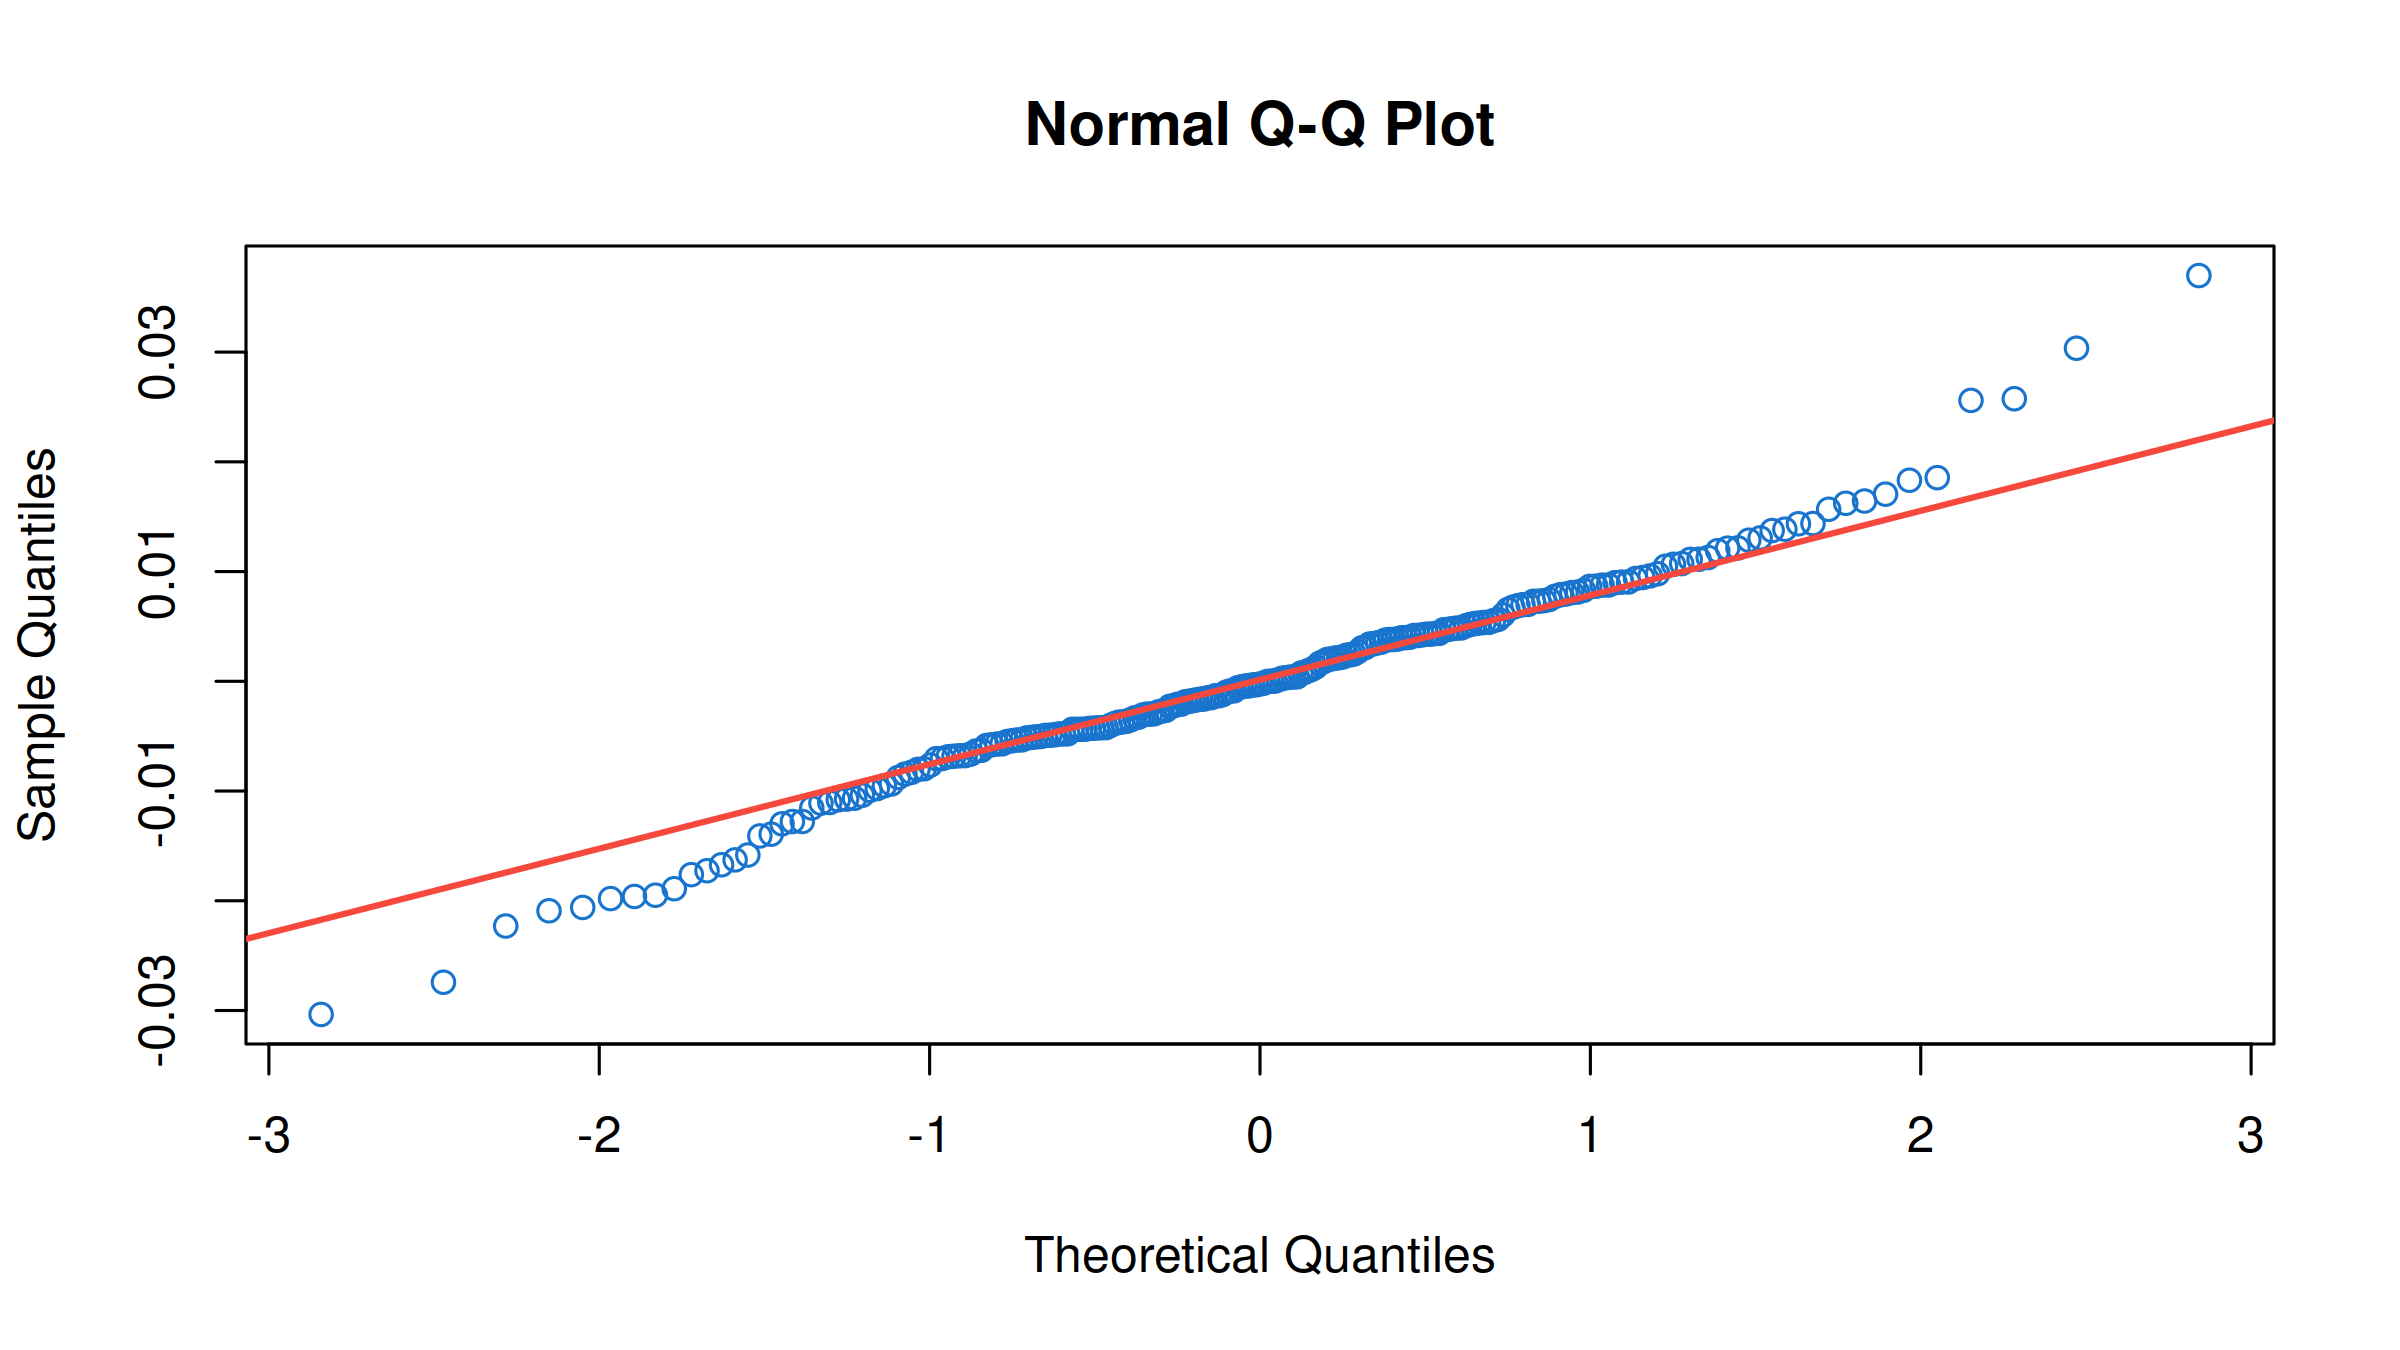

In [29]:
res2 = residuals(fit2)
qqnorm(res2, col=4)
qqline(res2, col=2, lwd=2)

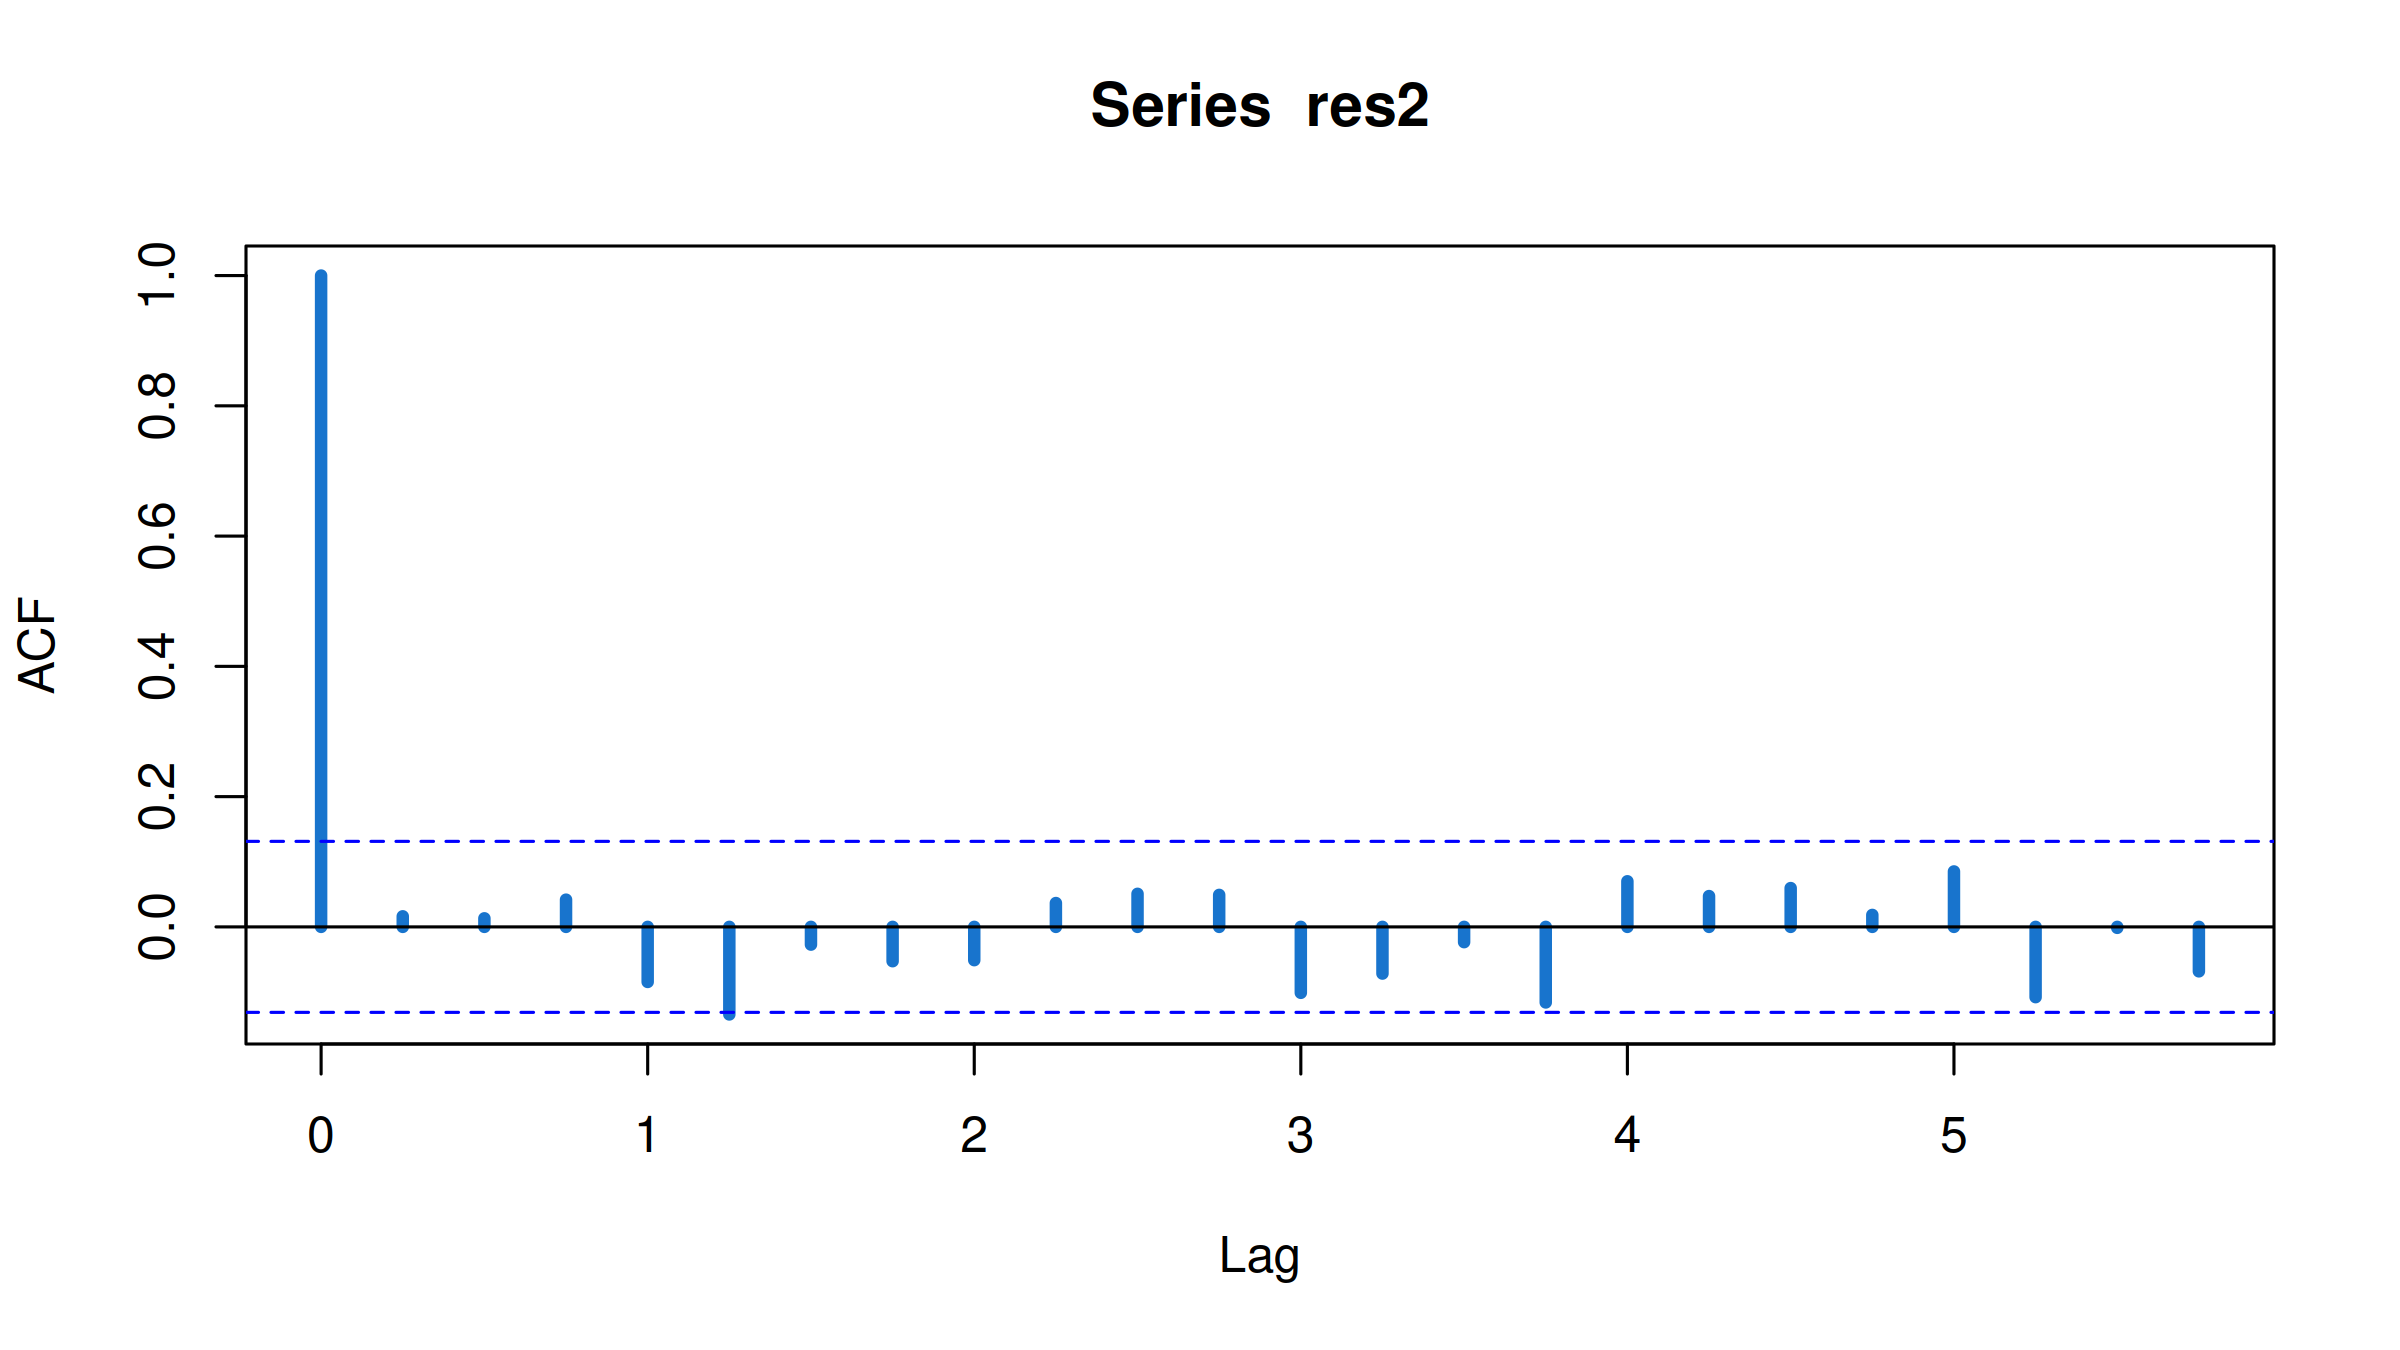

In [30]:
acf(res2, col=4, lwd=4)


	Ljung-Box test

data:  Residuals from ARIMA(0,1,2) with drift
Q* = 7.7205, df = 6, p-value = 0.2593

Model df: 2.   Total lags used: 8



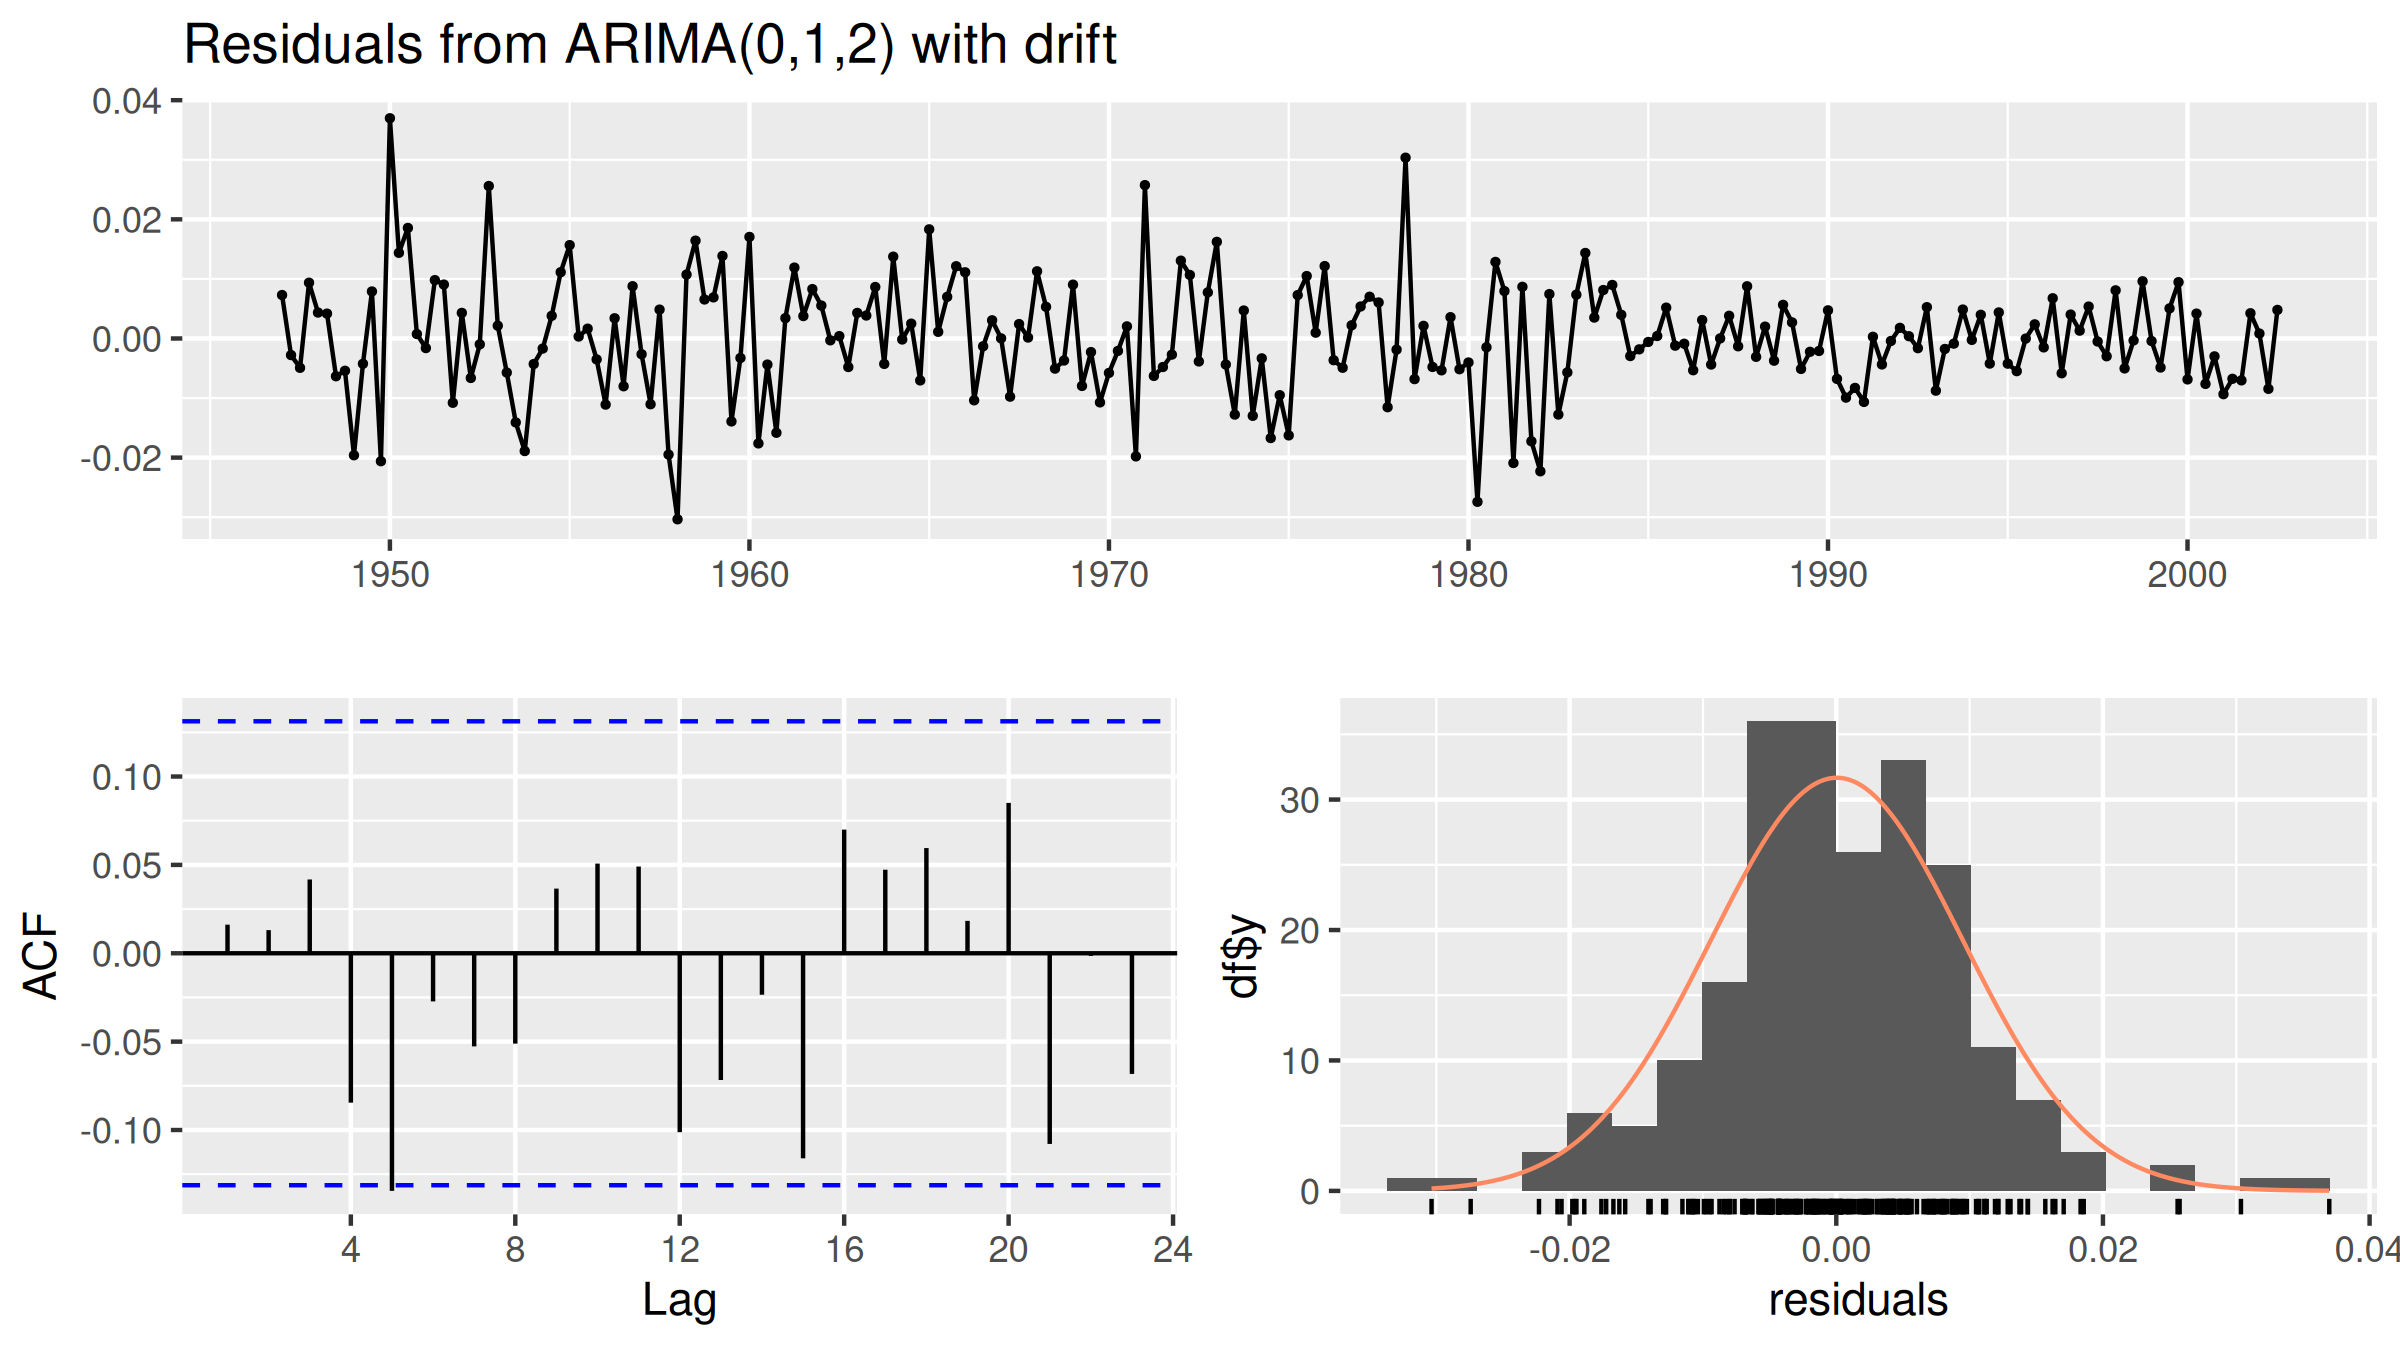

In [31]:
checkresiduals(fit2)

### Predicción:

Como último paso pasamos a la predicción a $10$ años:


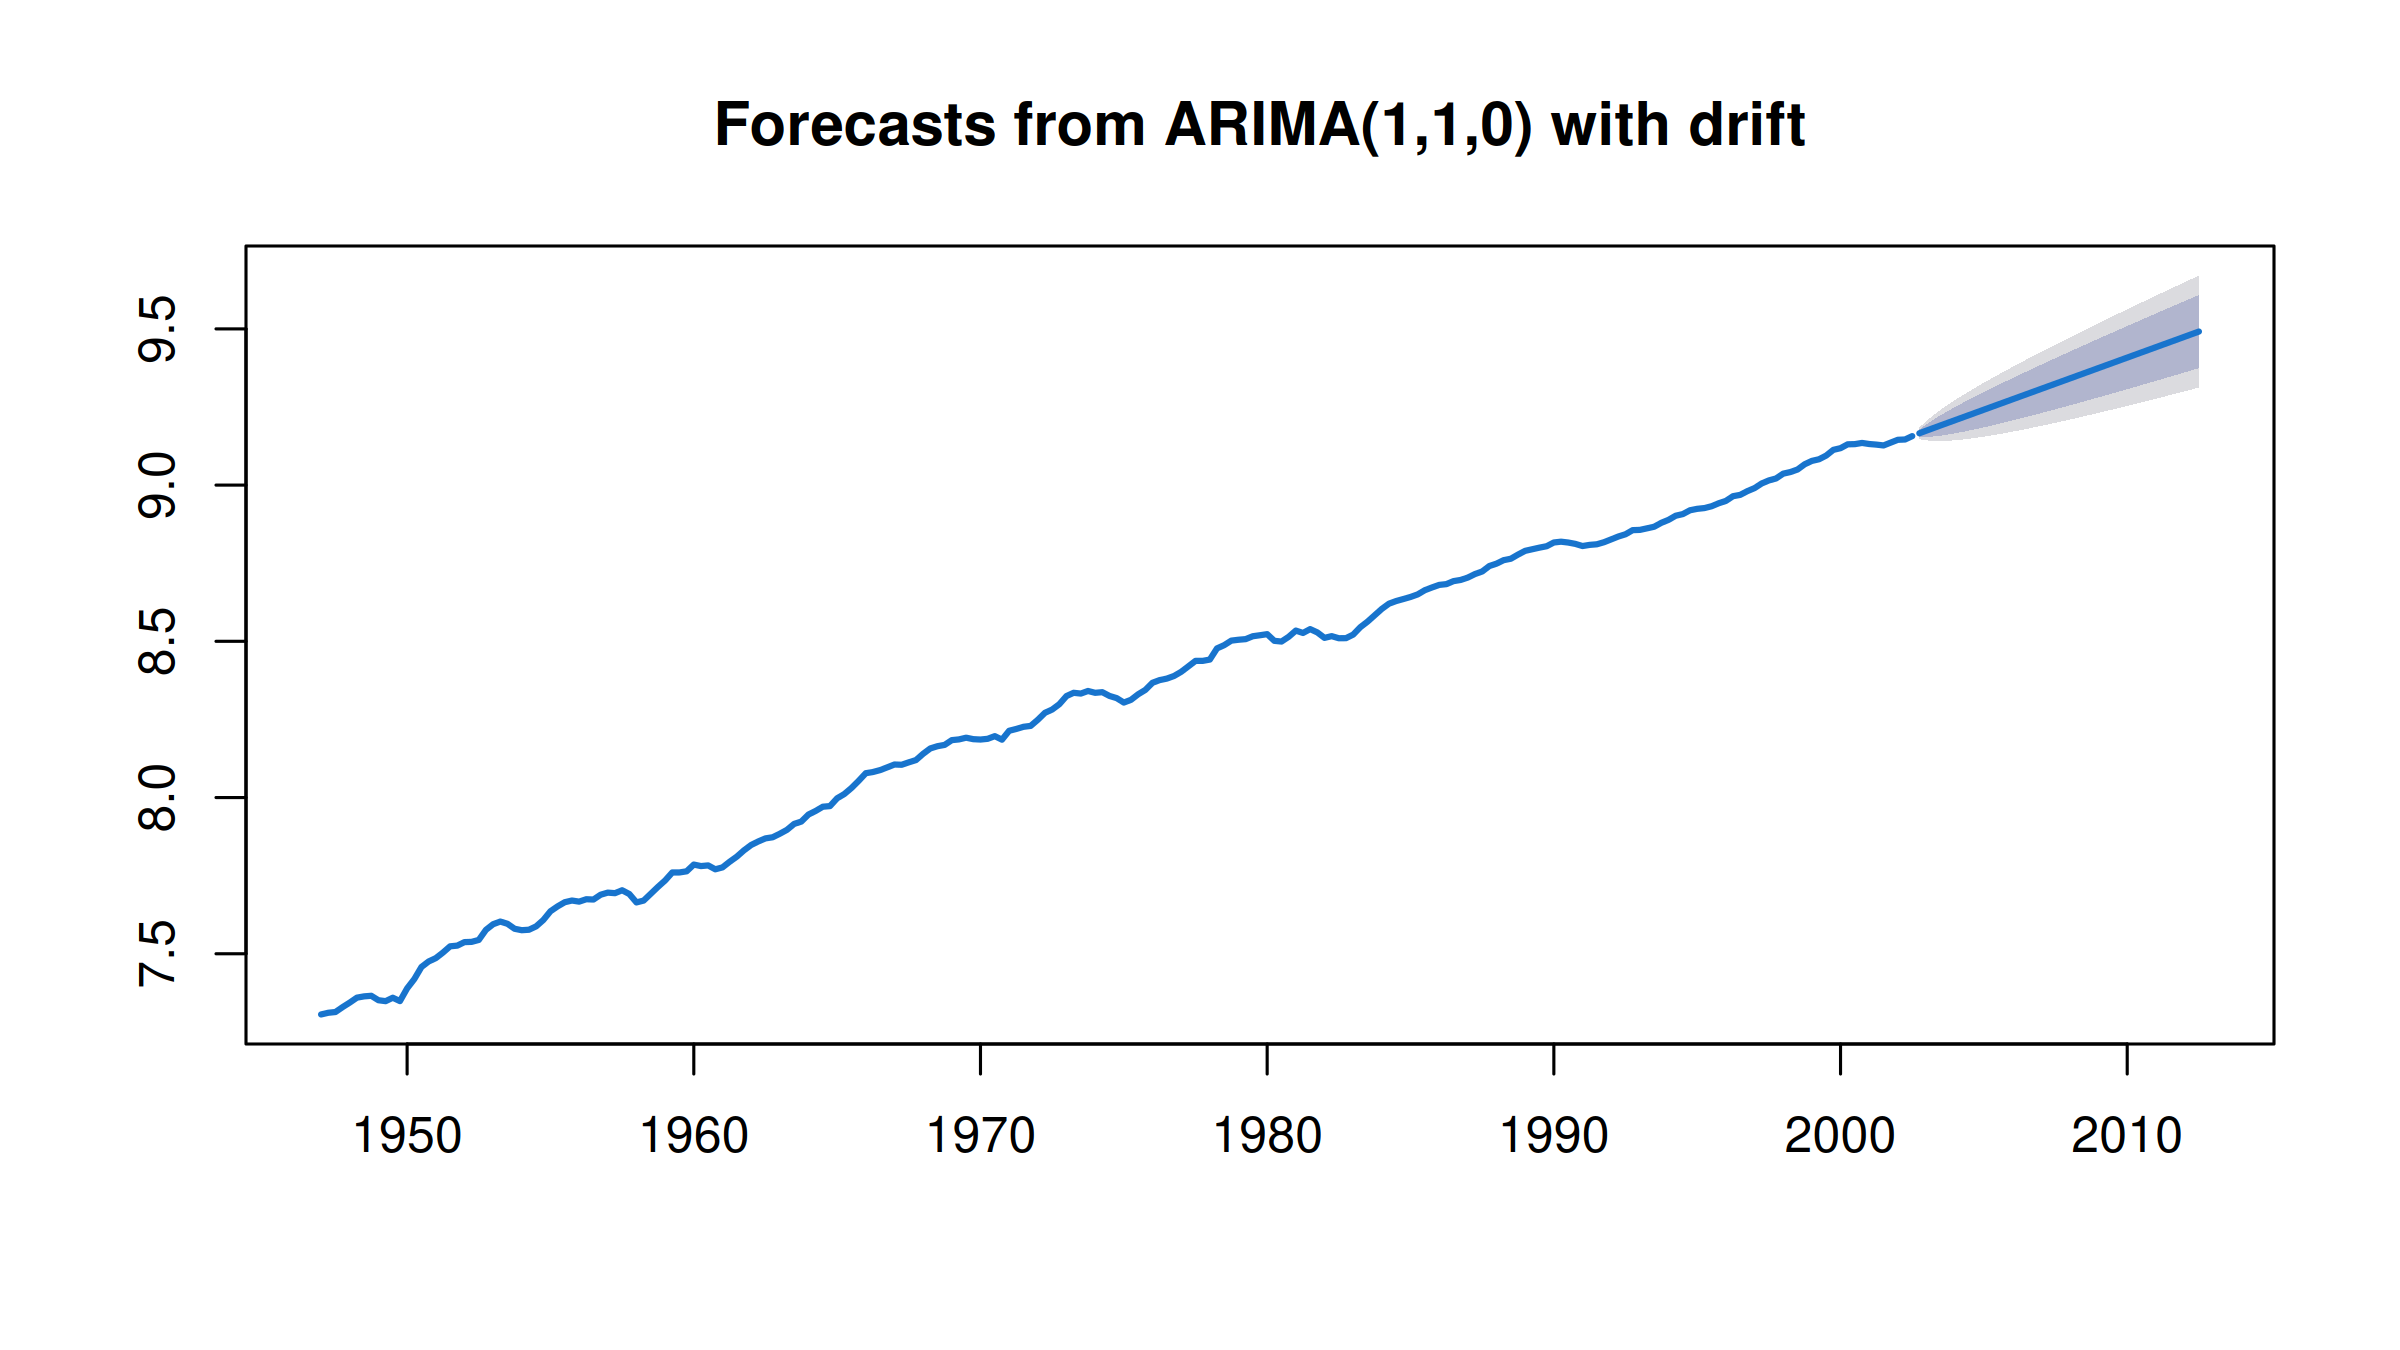

In [32]:
plot(forecast(fit,h=40), col=4, lwd=2)

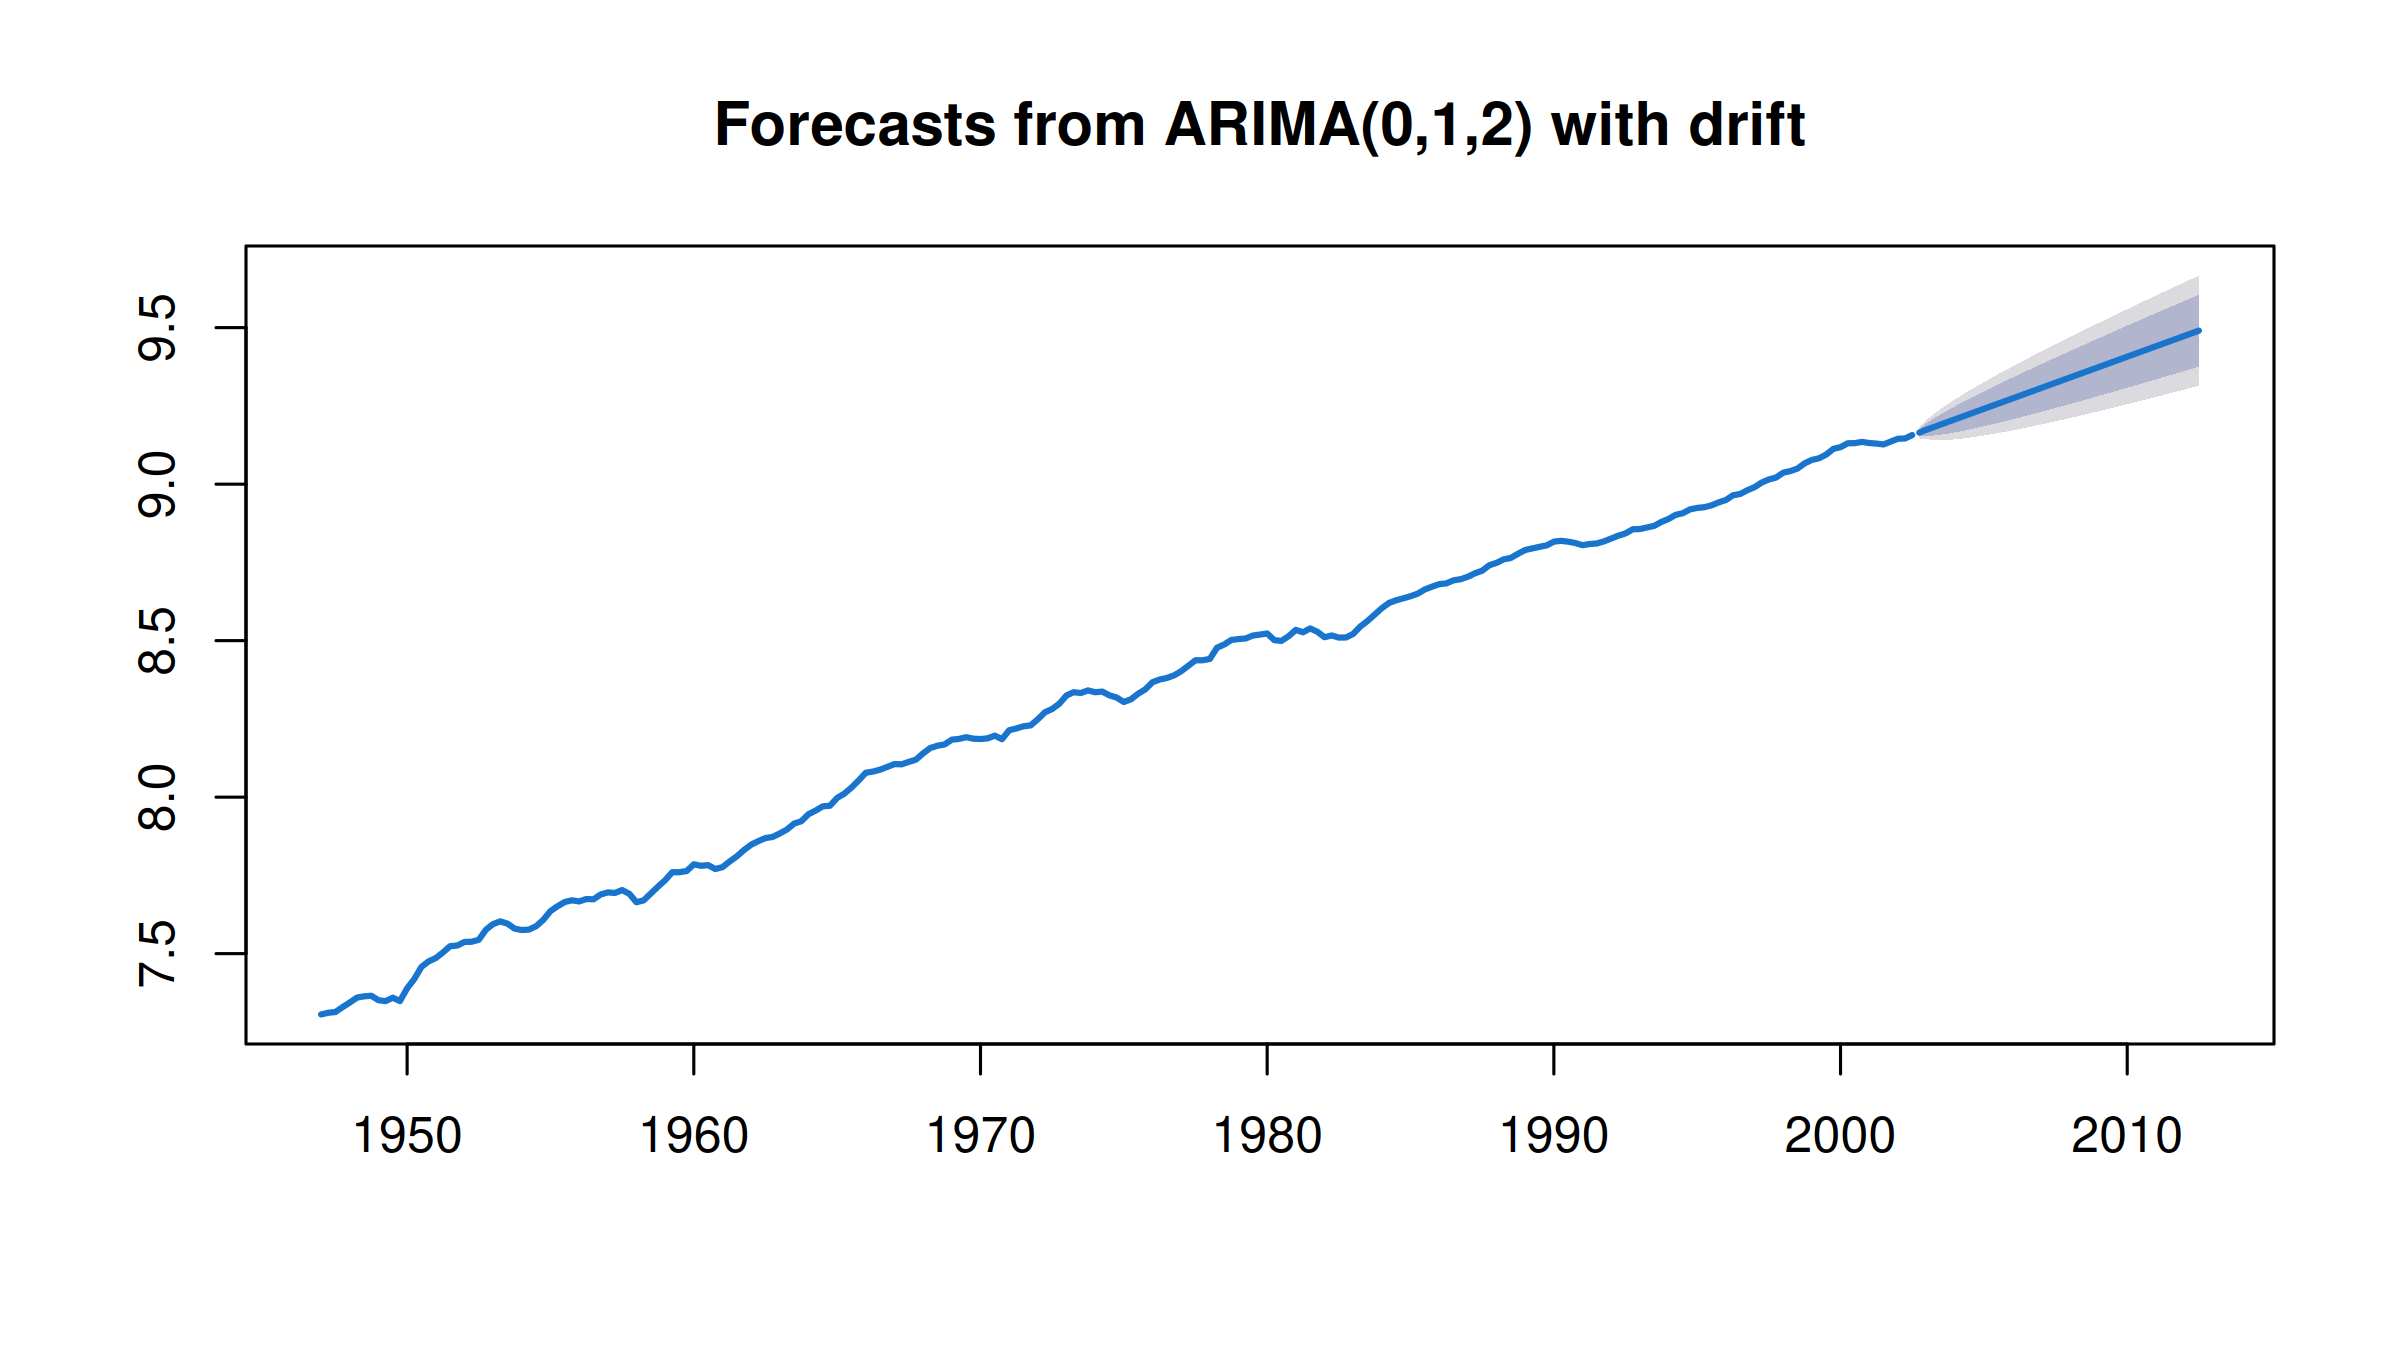

In [33]:
plot(forecast(fit2,h=40), col=4, lwd=2)

Ahora podemos volver a la variable original, deshaciendo la transformación $x\to \log(x)$ mediante $y\to \exp(y)$:

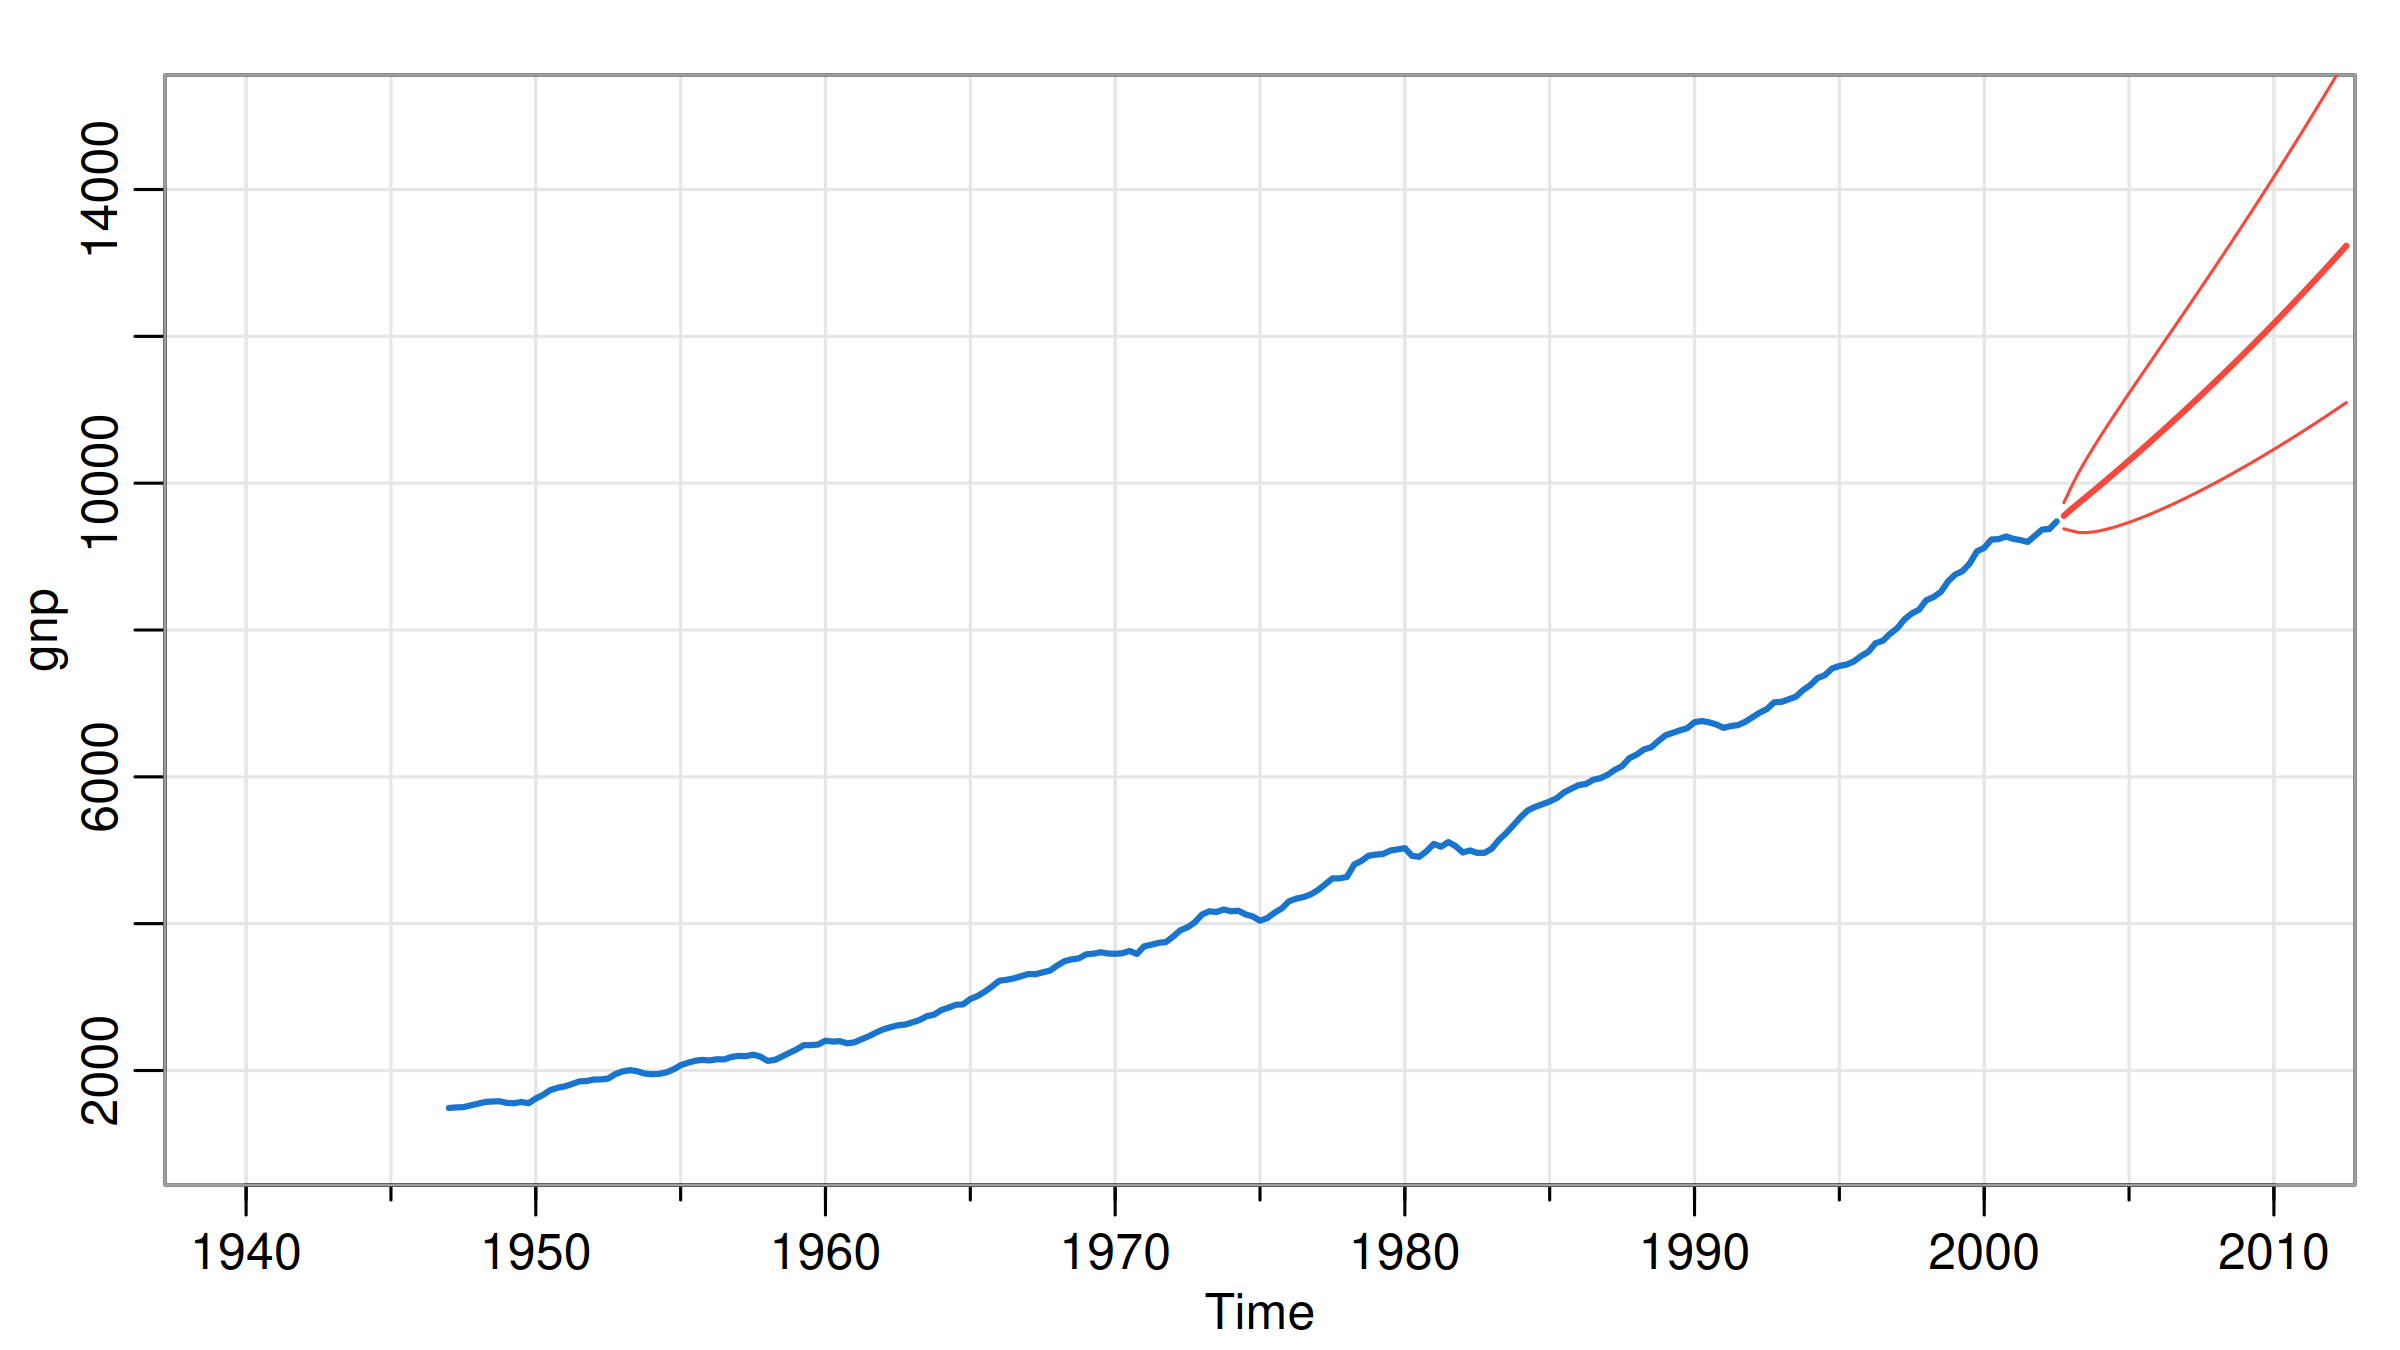

In [34]:
pred = forecast(fit2,h=40)
tsplot(gnp, xlim=c(1940,2010), ylim=c(1000,15000), col=4, lwd=2)
lines(exp(pred$mean), col=2, lwd=2)
lines(exp(pred$lower[,2]), col=2)
lines(exp(pred$upper[,2]), col=2)


## Modelos ARIMA estacionales (SARIMA)

Una variante muy utilizada de los modelos ARMA (ARIMA) es aquella que agrega dependencia *estacional*. Es decir, existe algún período conocido $s$ de la serie llamado *componente estacional* que se conoce tiene influencia en el valor actual. Por ejemplo $s=12$ en series anuales muestreadas mensualmente.

### Ejemplo (AR estacional puro)

Supongamos que la serie sigue la siguiente ecuación:

$$x_{t} = \Phi x_{t-12} + w_t$$

con $\Phi$ un coeficiente y $w_t$ ruido blanco Gaussiano de varianza $\sigma^2_w$

El proceso anterior lo podemos pensar simplemente como un proceso $AR(12)$, pero cuyos coeficientes intermedios son todos $0$.

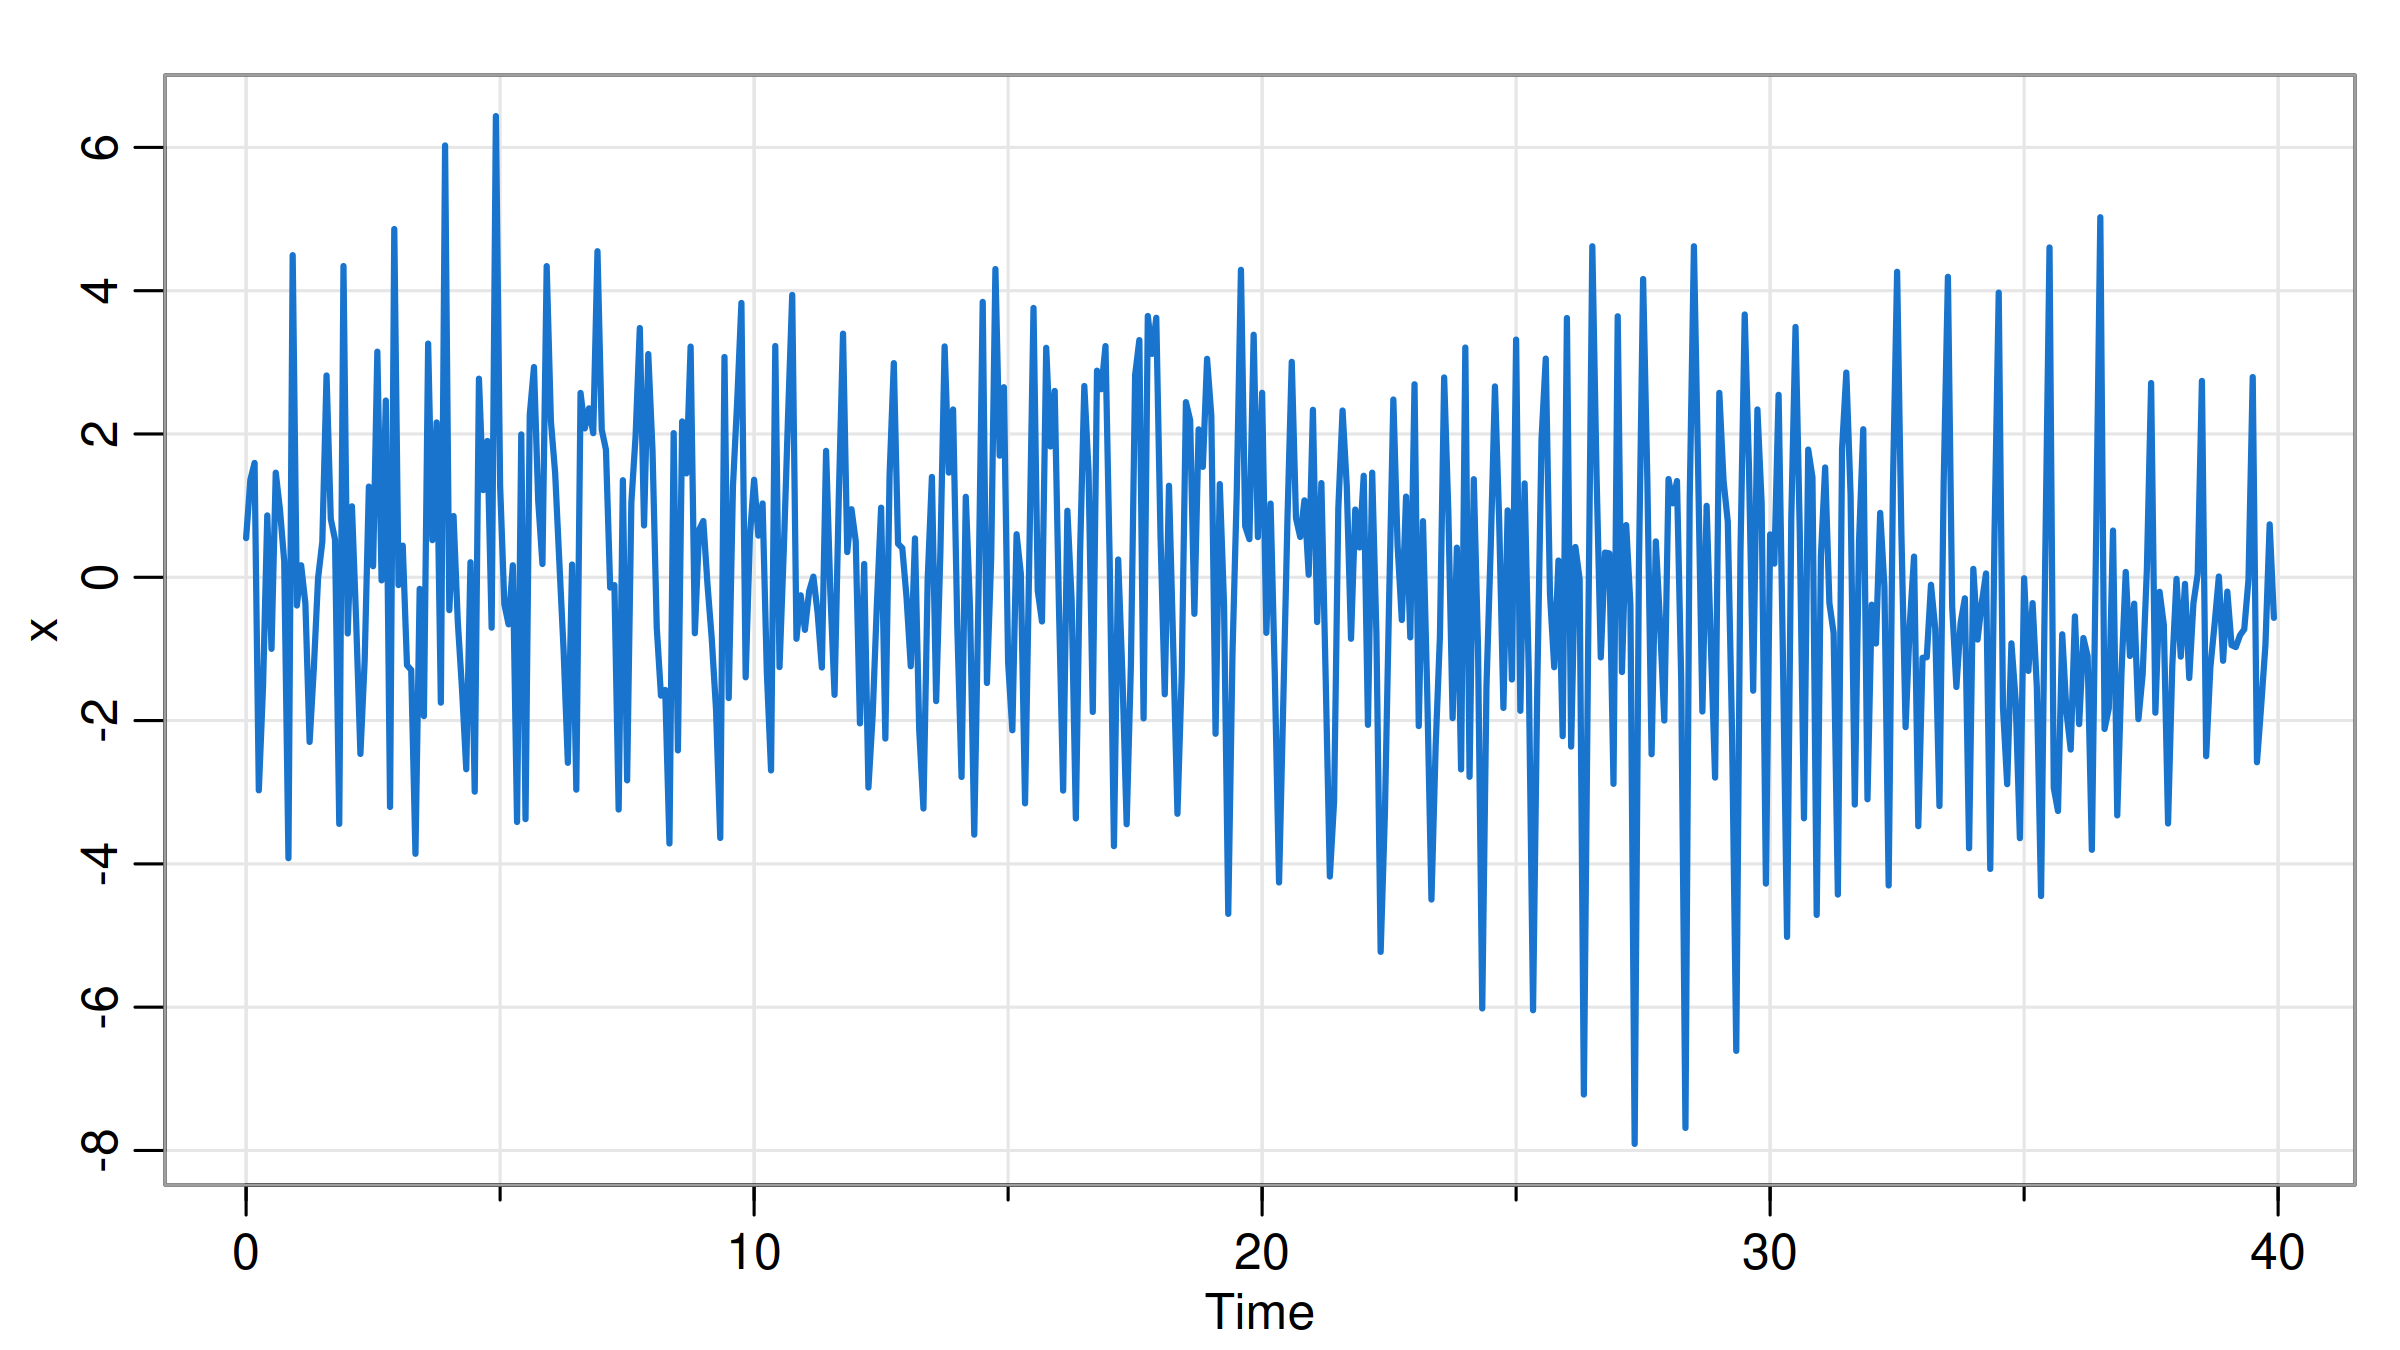

In [35]:
Phi=0.9
coefs = c(rep(0,11),Phi)
x = ts(arima.sim(list(order=c(12,0,0), ar=coefs), n=480), start=0, freq=12)
tsplot(x, lwd=2, col=4)

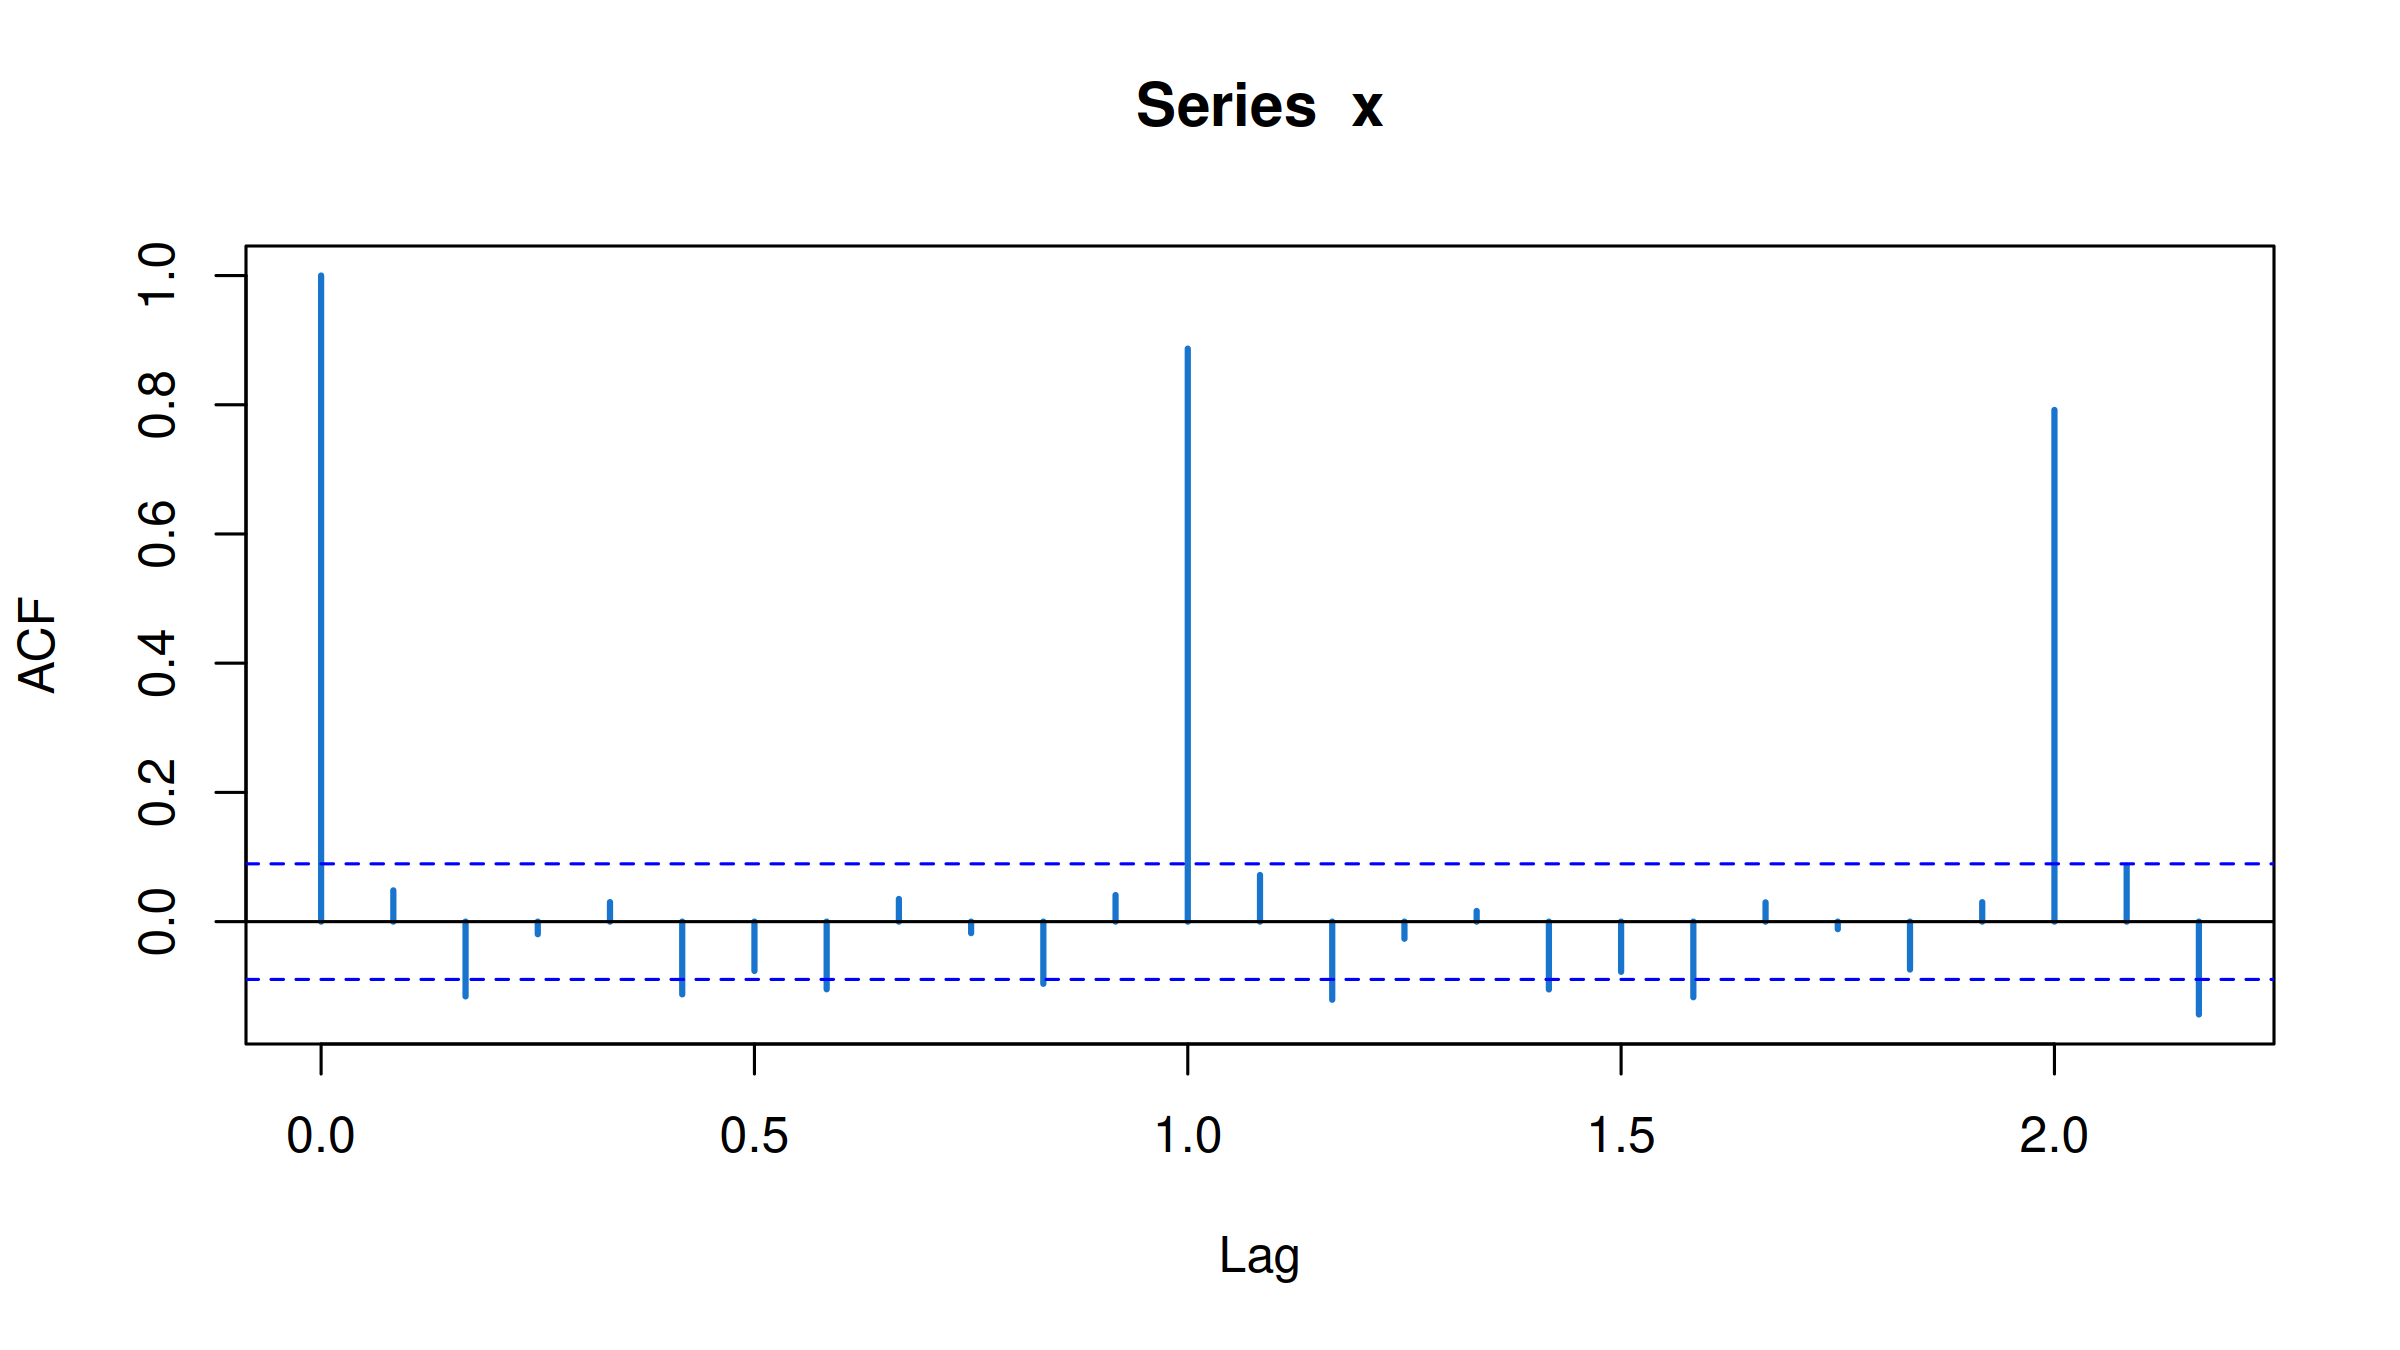

In [36]:
acf(x, lwd=2, col=4)

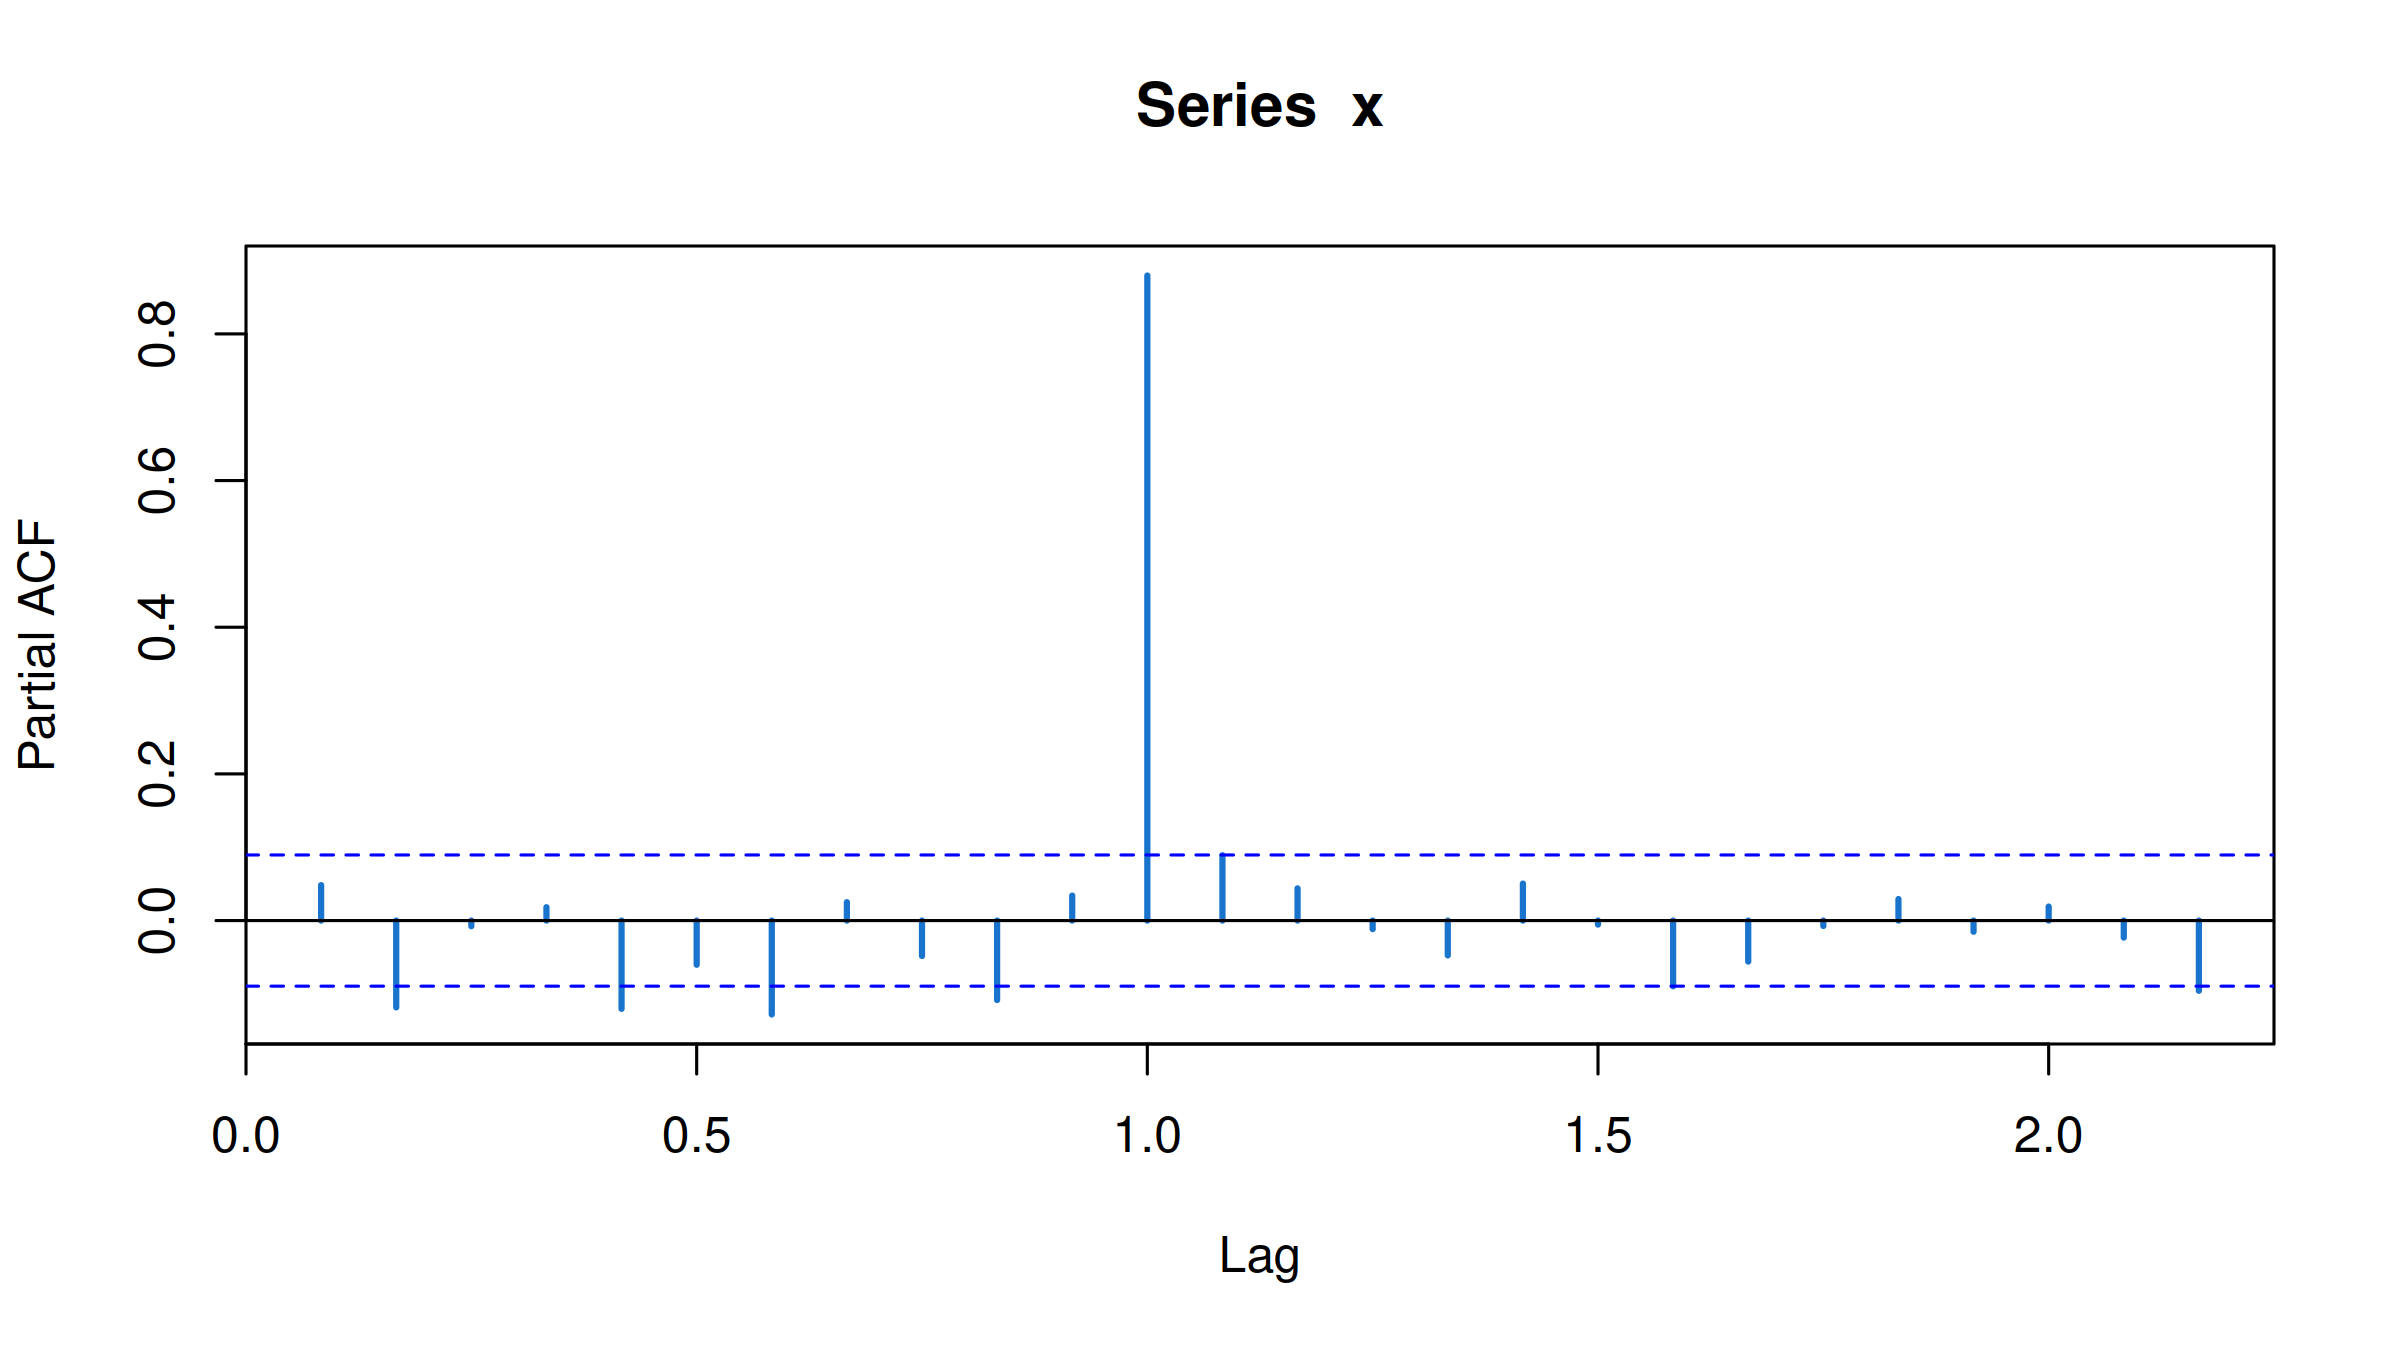

In [37]:
pacf(x, lwd=2, col=4)

Y en principio se puede realizar el ajuste de la misma manera:

In [38]:
fit = Arima(x,order=c(12,0,0), include.mean=FALSE)
summary(fit)

Series: x 
ARIMA(12,0,0) with zero mean 

Coefficients:
         ar1      ar2     ar3      ar4      ar5      ar6      ar7     ar8
      0.0143  -0.0307  0.0016  -0.0130  -0.0151  -0.0002  -0.0115  0.0121
s.e.  0.0196   0.0196  0.0195   0.0197   0.0196   0.0187   0.0196  0.0197
          ar9    ar10     ar11    ar12
      -0.0102  0.0055  -0.0116  0.8897
s.e.   0.0195  0.0197   0.0196  0.0189

sigma^2 = 0.9665:  log likelihood = -676.4
AIC=1378.8   AICc=1379.58   BIC=1433.06

Training set error measures:
                      ME      RMSE     MAE      MPE     MAPE      MASE
Training set -0.02221981 0.9707586 0.77872 82.67102 214.8369 0.9768954
                    ACF1
Training set -0.05254528

Sin embargo, si uno sabe que los coeficientes son $0$, es mejor obviarlos para lograr un mejor ajuste del coeficiente no nulo. Esto se logra proponiendo un modelo $ARMA(p,q)\times(P,Q)_s$. Aquí $(p,q)$ son las componentes ARMA como antes, y $(P,Q)_s$ indican dependencia a estaciones pasadas (dadas por el período $s$).

In [39]:
fit = Arima(x, order = c(0, 0, 0), seasonal = c(1, 0, 0), include.mean = FALSE)
summary(fit)

Series: x 
ARIMA(0,0,0)(1,0,0)[12] with zero mean 

Coefficients:
        sar1
      0.8948
s.e.  0.0182

sigma^2 = 0.9525:  log likelihood = -678.59
AIC=1361.19   AICc=1361.21   BIC=1369.53

Training set error measures:
                      ME      RMSE       MAE      MPE   MAPE      MASE
Training set -0.01933748 0.9749562 0.7807025 73.34101 217.42 0.9793823
                    ACF1
Training set -0.03995384

### Ejemplo: combinación de AR estacional y MA local.

Consideremos el proceso:

$$x_t = \Phi x_{t-12} + w_t + \theta w_{t-1}$$

En este caso tenemos un proceso $ARMA(0,1)\times(1,0)_{12}$.

Consideremos la siguiente serie de nacimientos en EEUU durante el "baby boom":

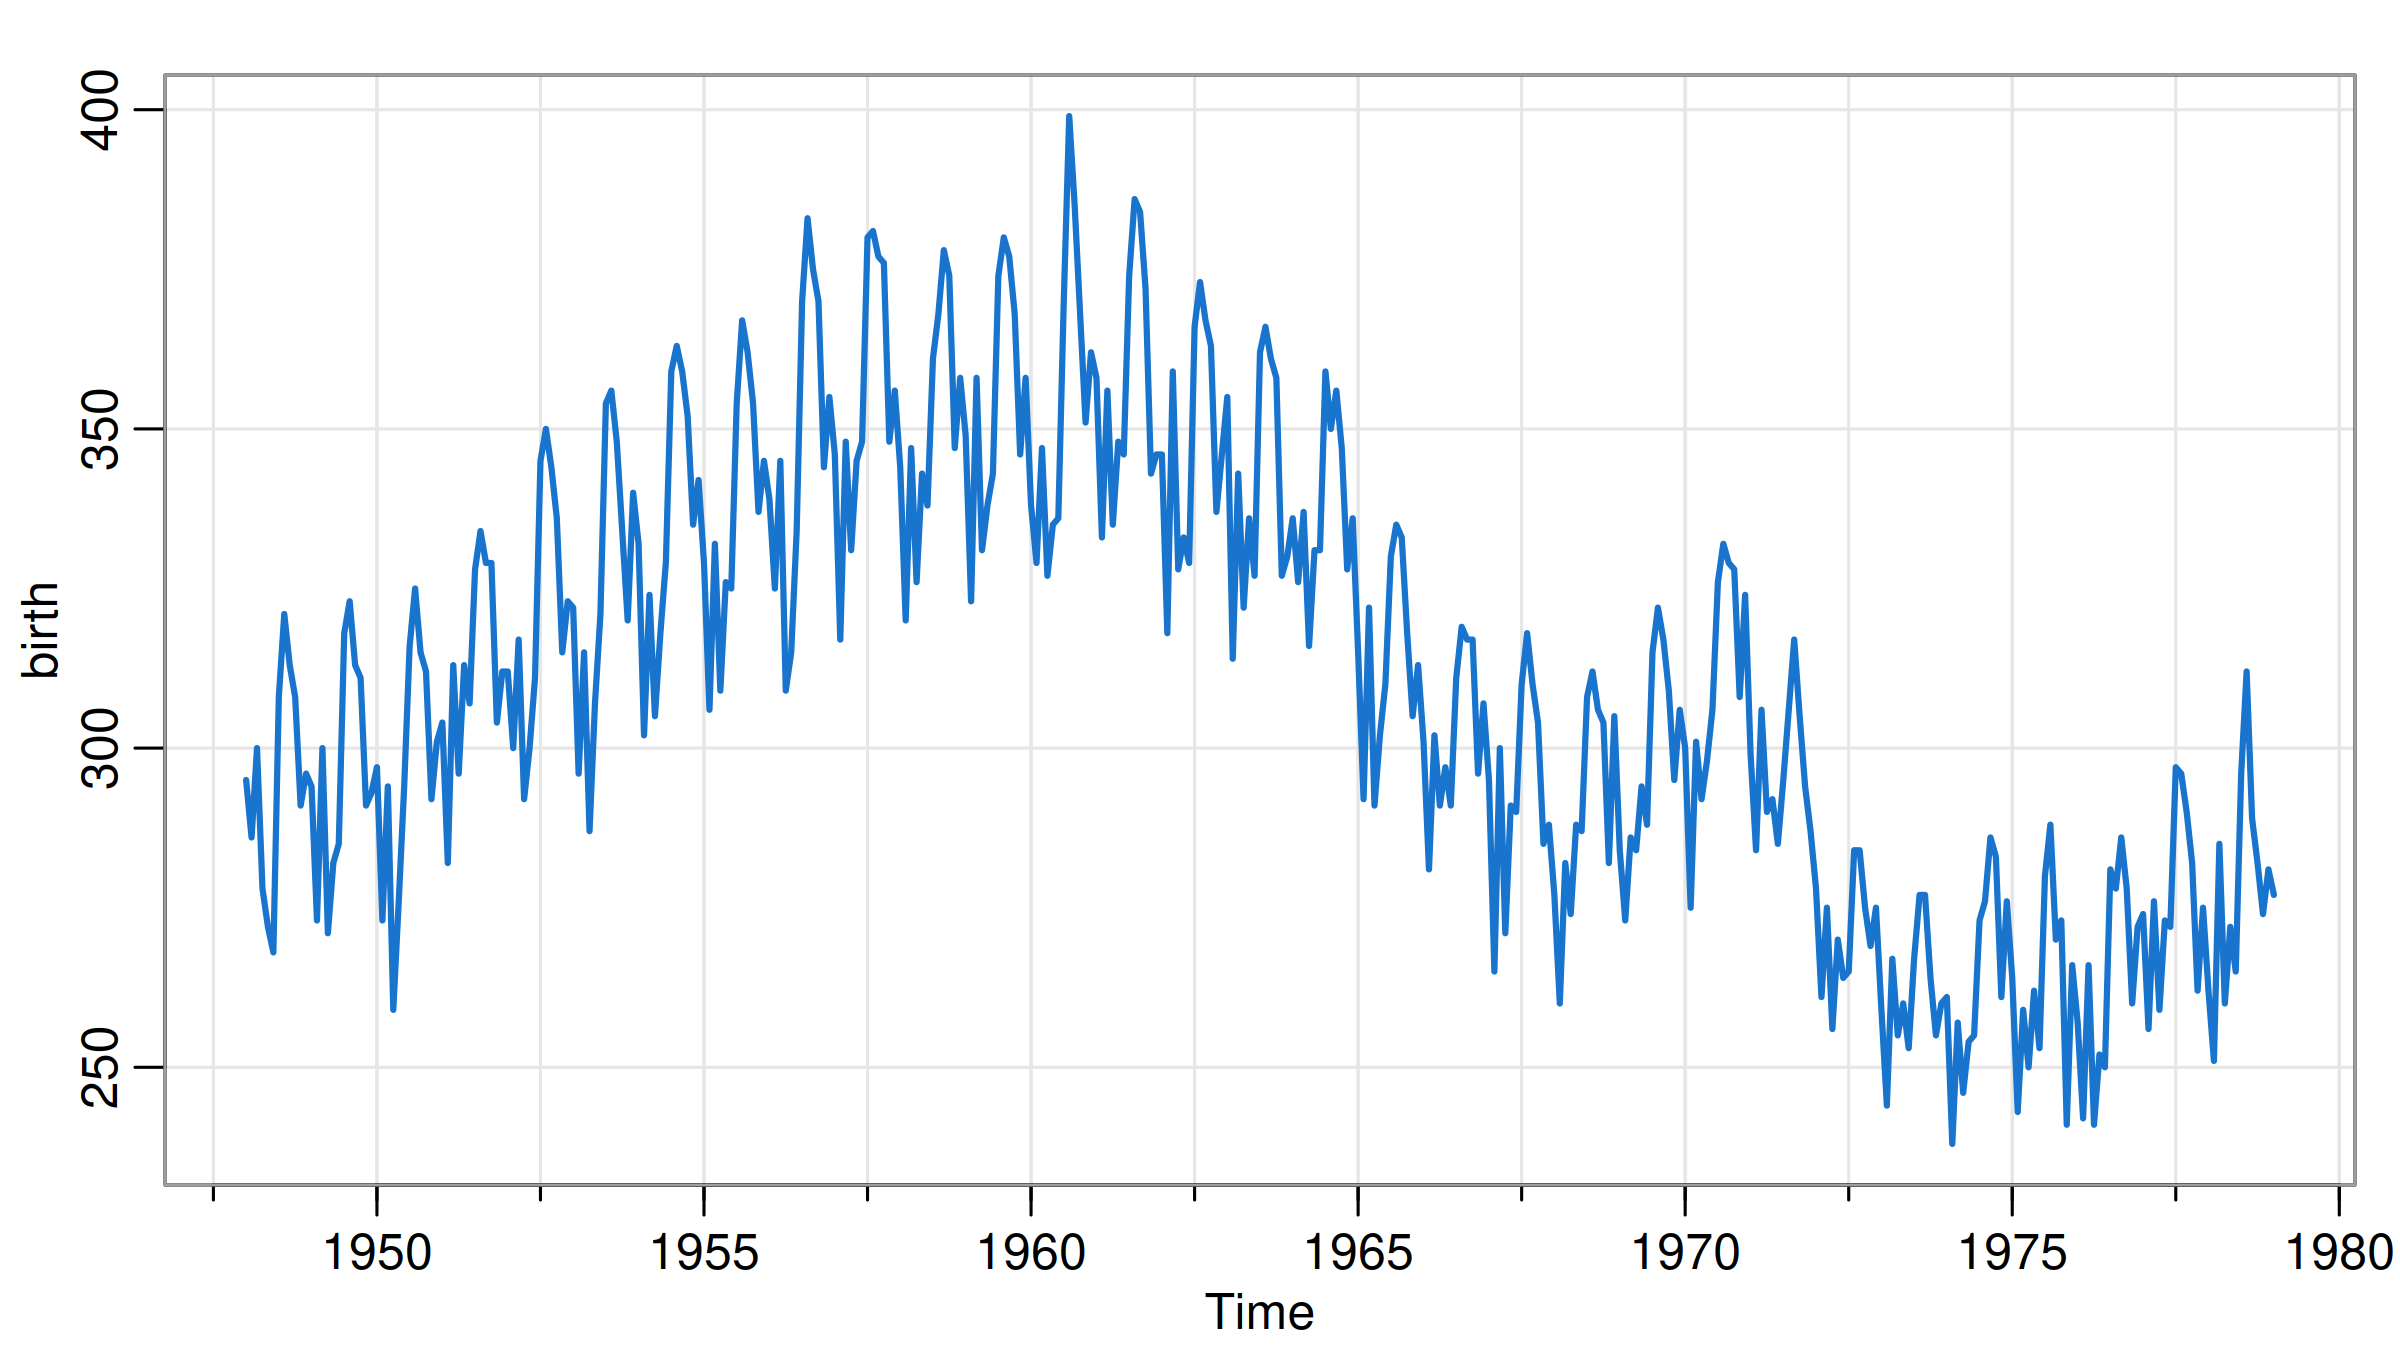

In [40]:
tsplot(birth, lwd=2, col=4)

Calculemos su crecimiento usando la transformación `diff(log())`

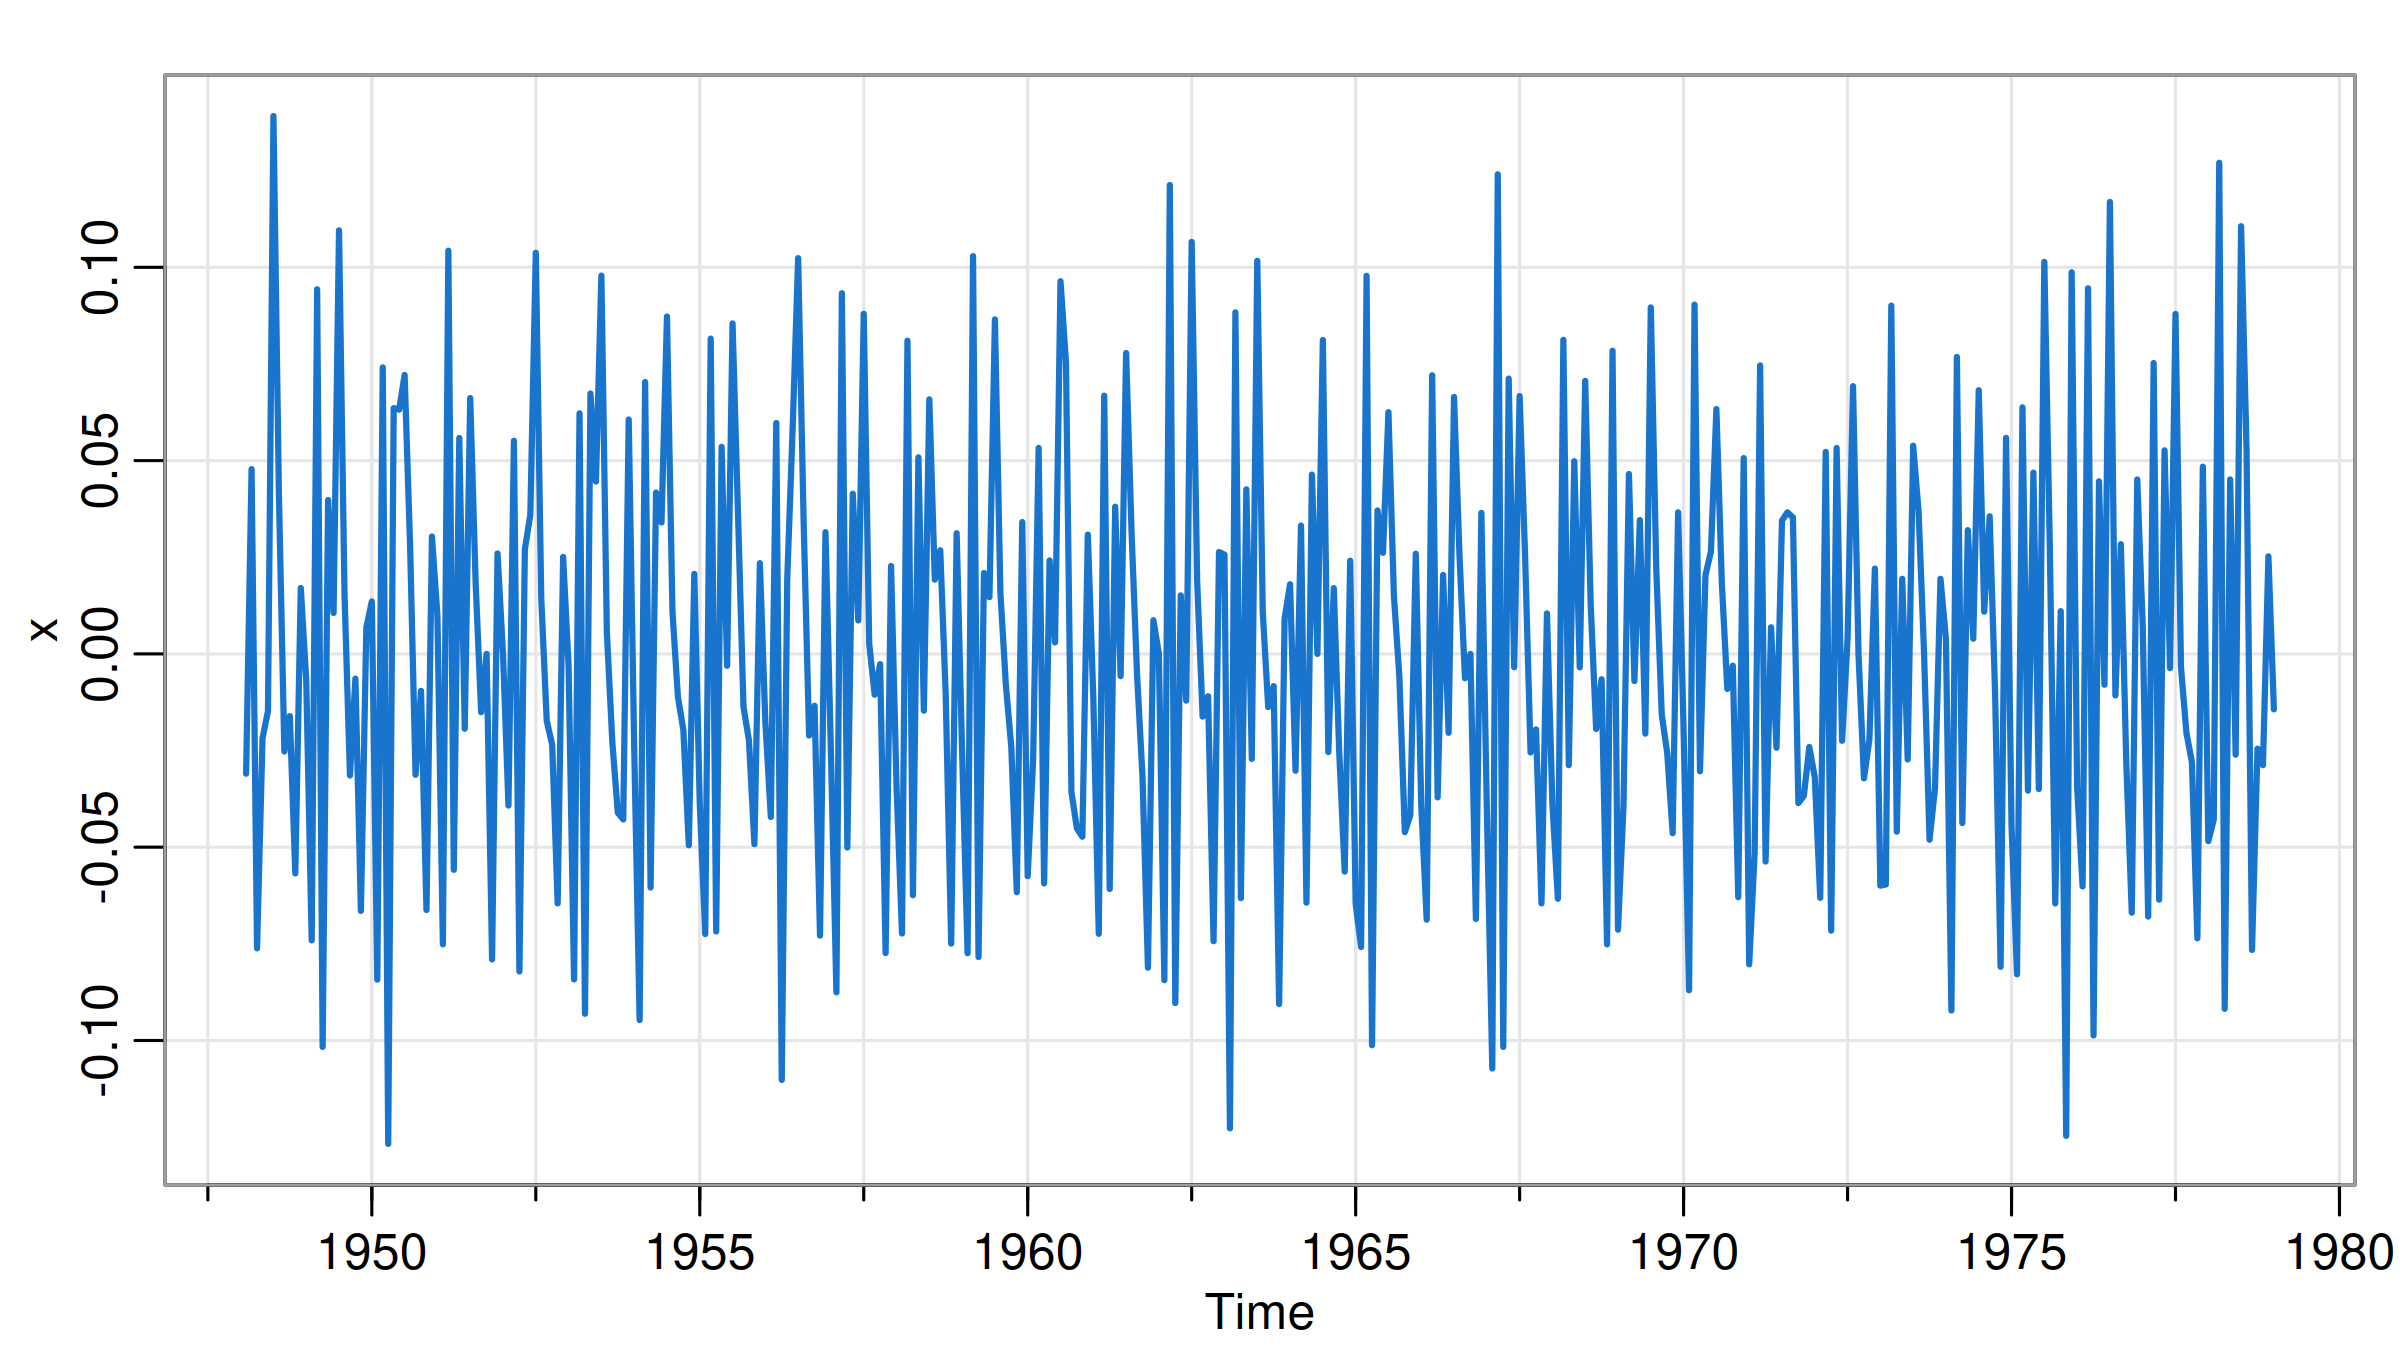

In [41]:
x = diff(log(birth))
tsplot(x, lwd=2, col=4)

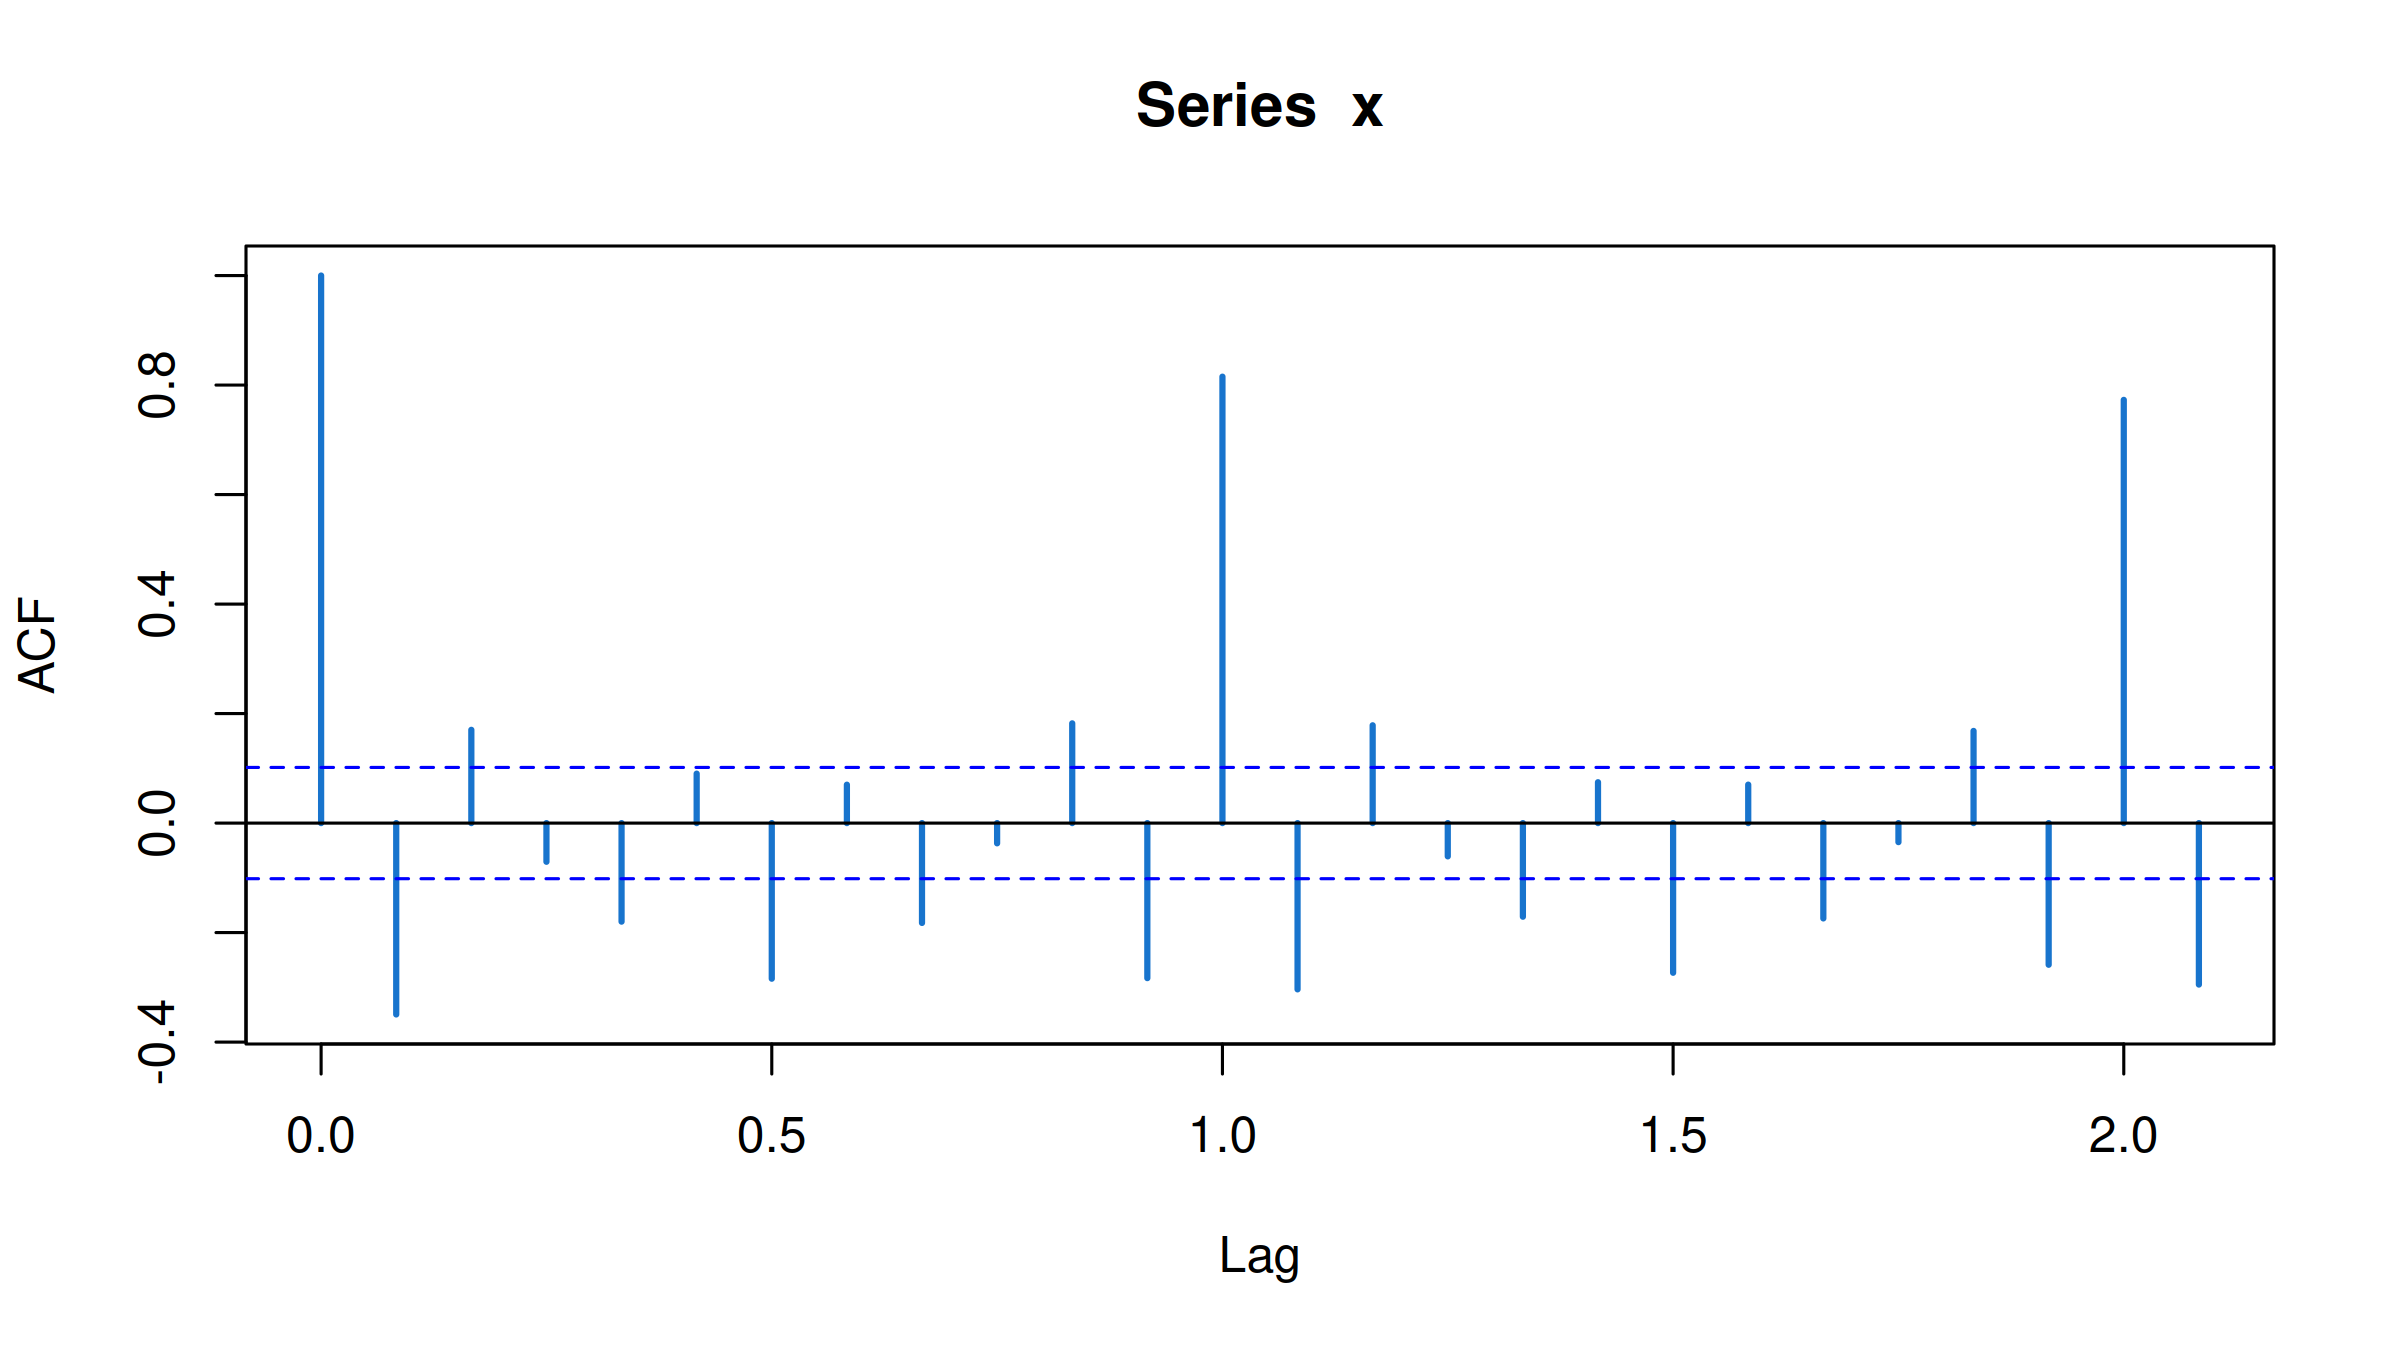

In [42]:
acf(x, lwd=2, col=4)

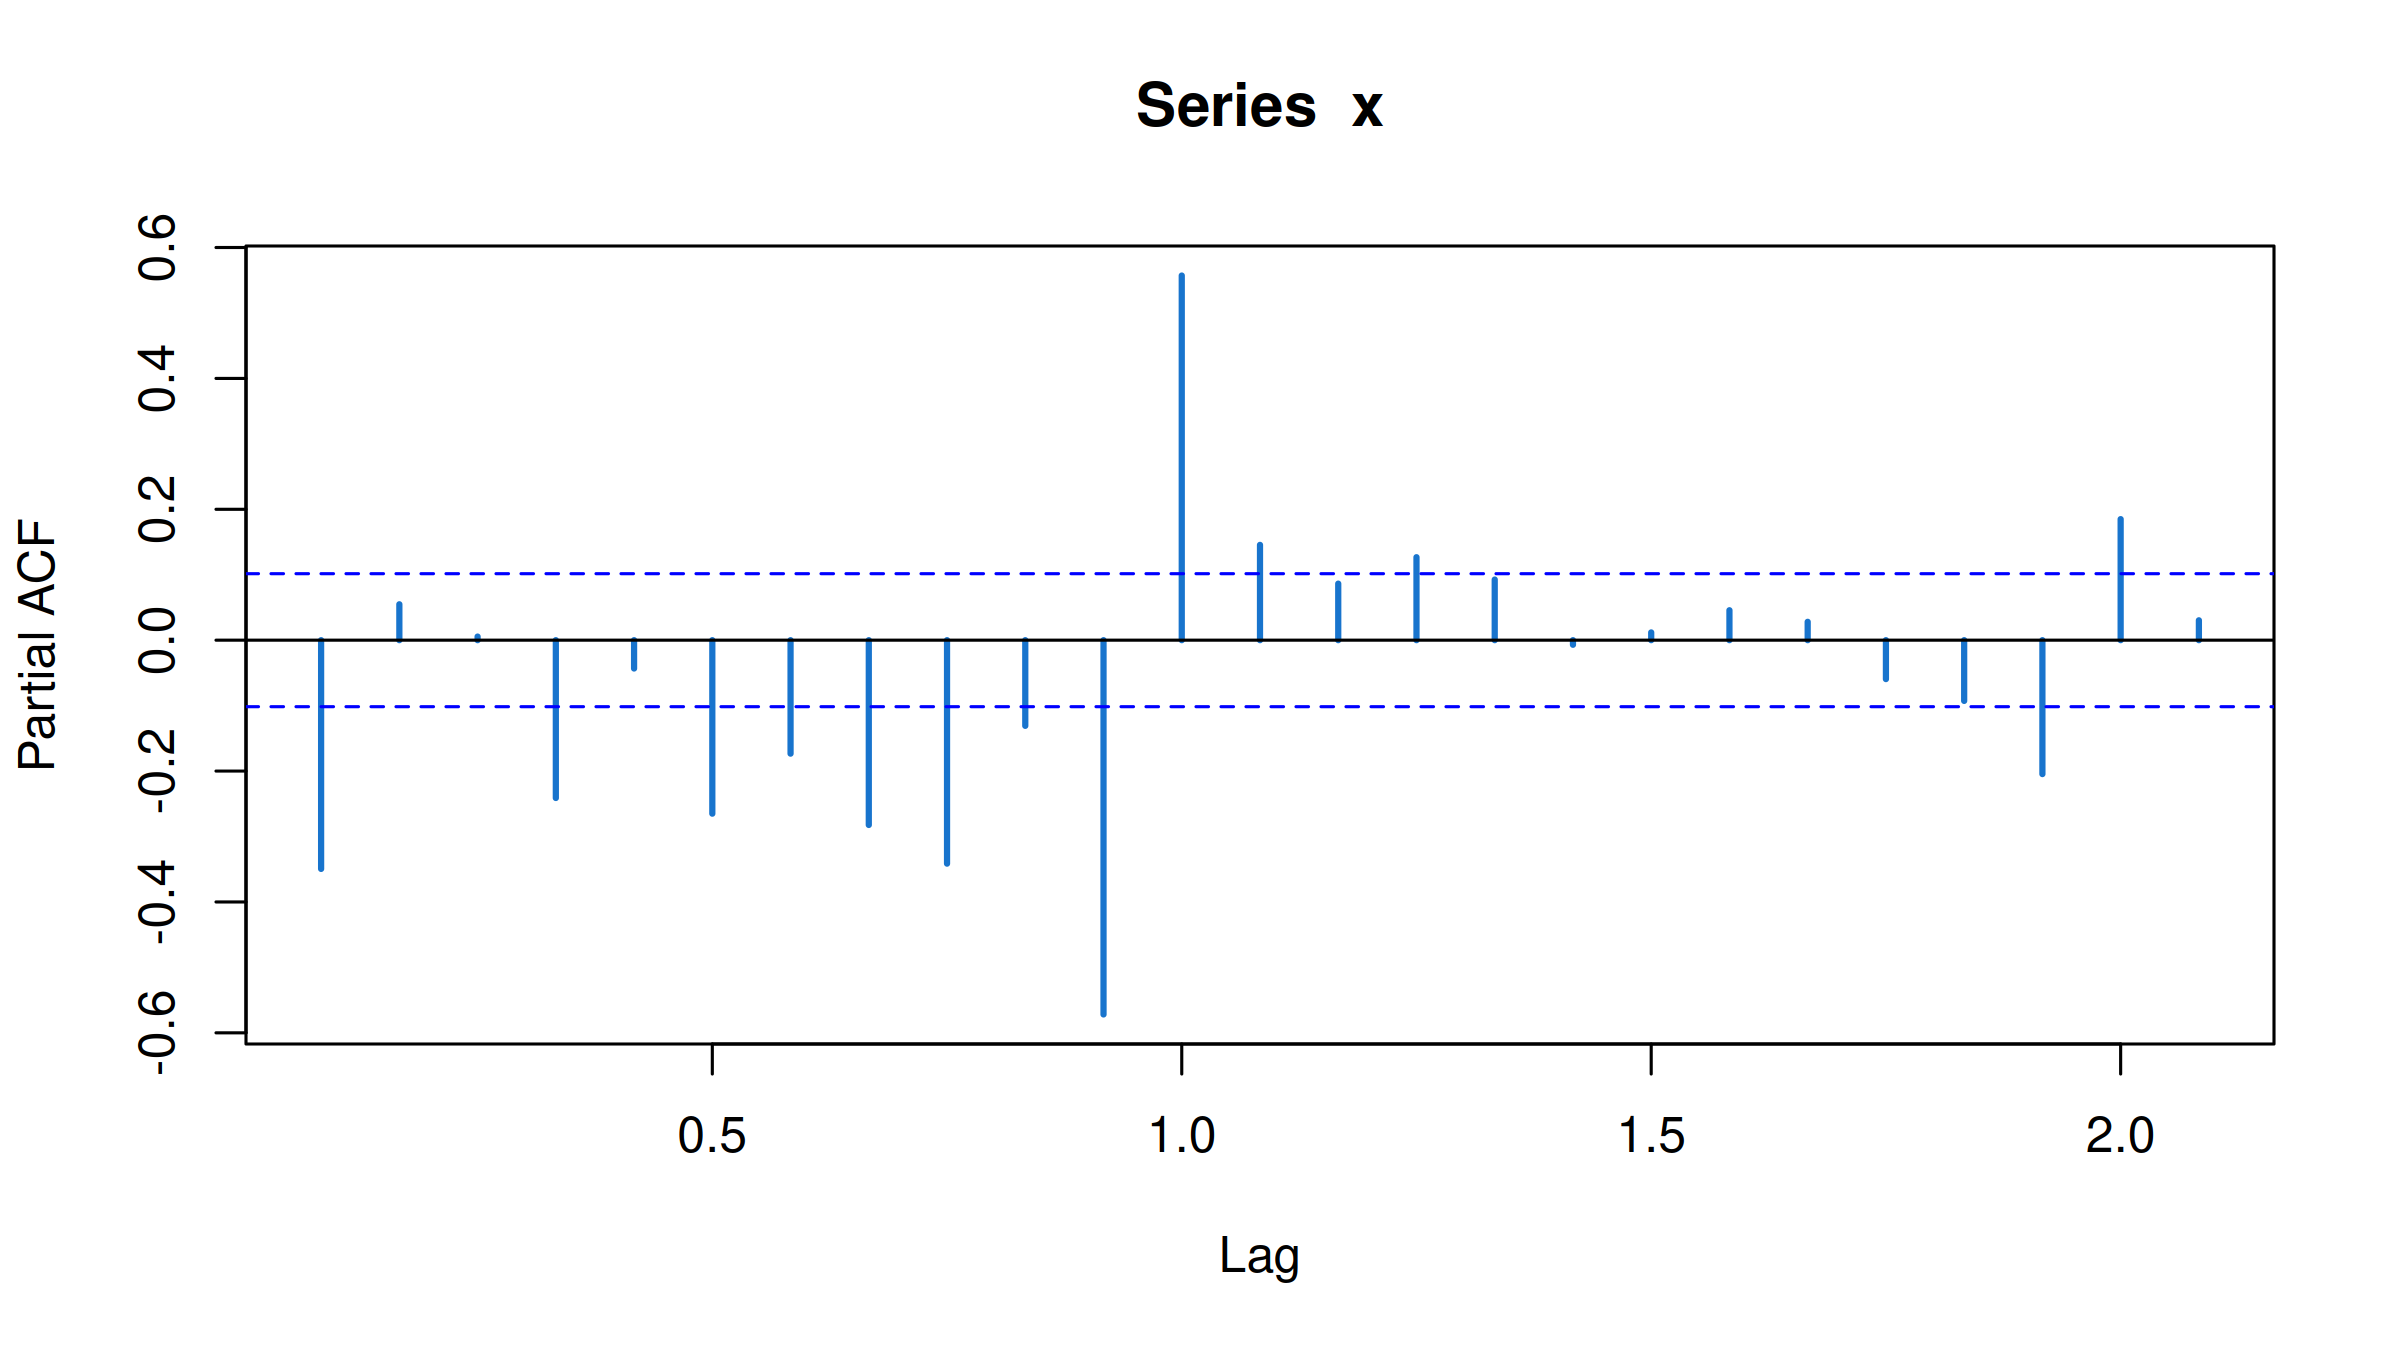

In [43]:
pacf(x, lwd=2, col=4)

Ajustamos ahora el modelo anterior $x_t = \Phi x_{t-12} + w_t + \theta w_{t-1}$, es decir, $ARMA(0,1)\times(1,0)_{12}$.

In [44]:
fit = Arima(x, order = c(0, 0, 1), seasonal = c(1, 0, 0), include.mean = FALSE)
summary(fit)

Series: x 
ARIMA(0,0,1)(1,0,0)[12] with zero mean 

Coefficients:
          ma1    sar1
      -0.5022  0.8670
s.e.   0.0557  0.0246

sigma^2 = 0.0007278:  log likelihood = 808.58
AIC=-1611.17   AICc=-1611.1   BIC=-1599.41

Training set error measures:
                       ME       RMSE        MAE MPE MAPE      MASE      ACF1
Training set 0.0001703213 0.02690604 0.02098316 NaN  Inf 0.8745322 0.0714872

Agreguemos una predicción a futuro:

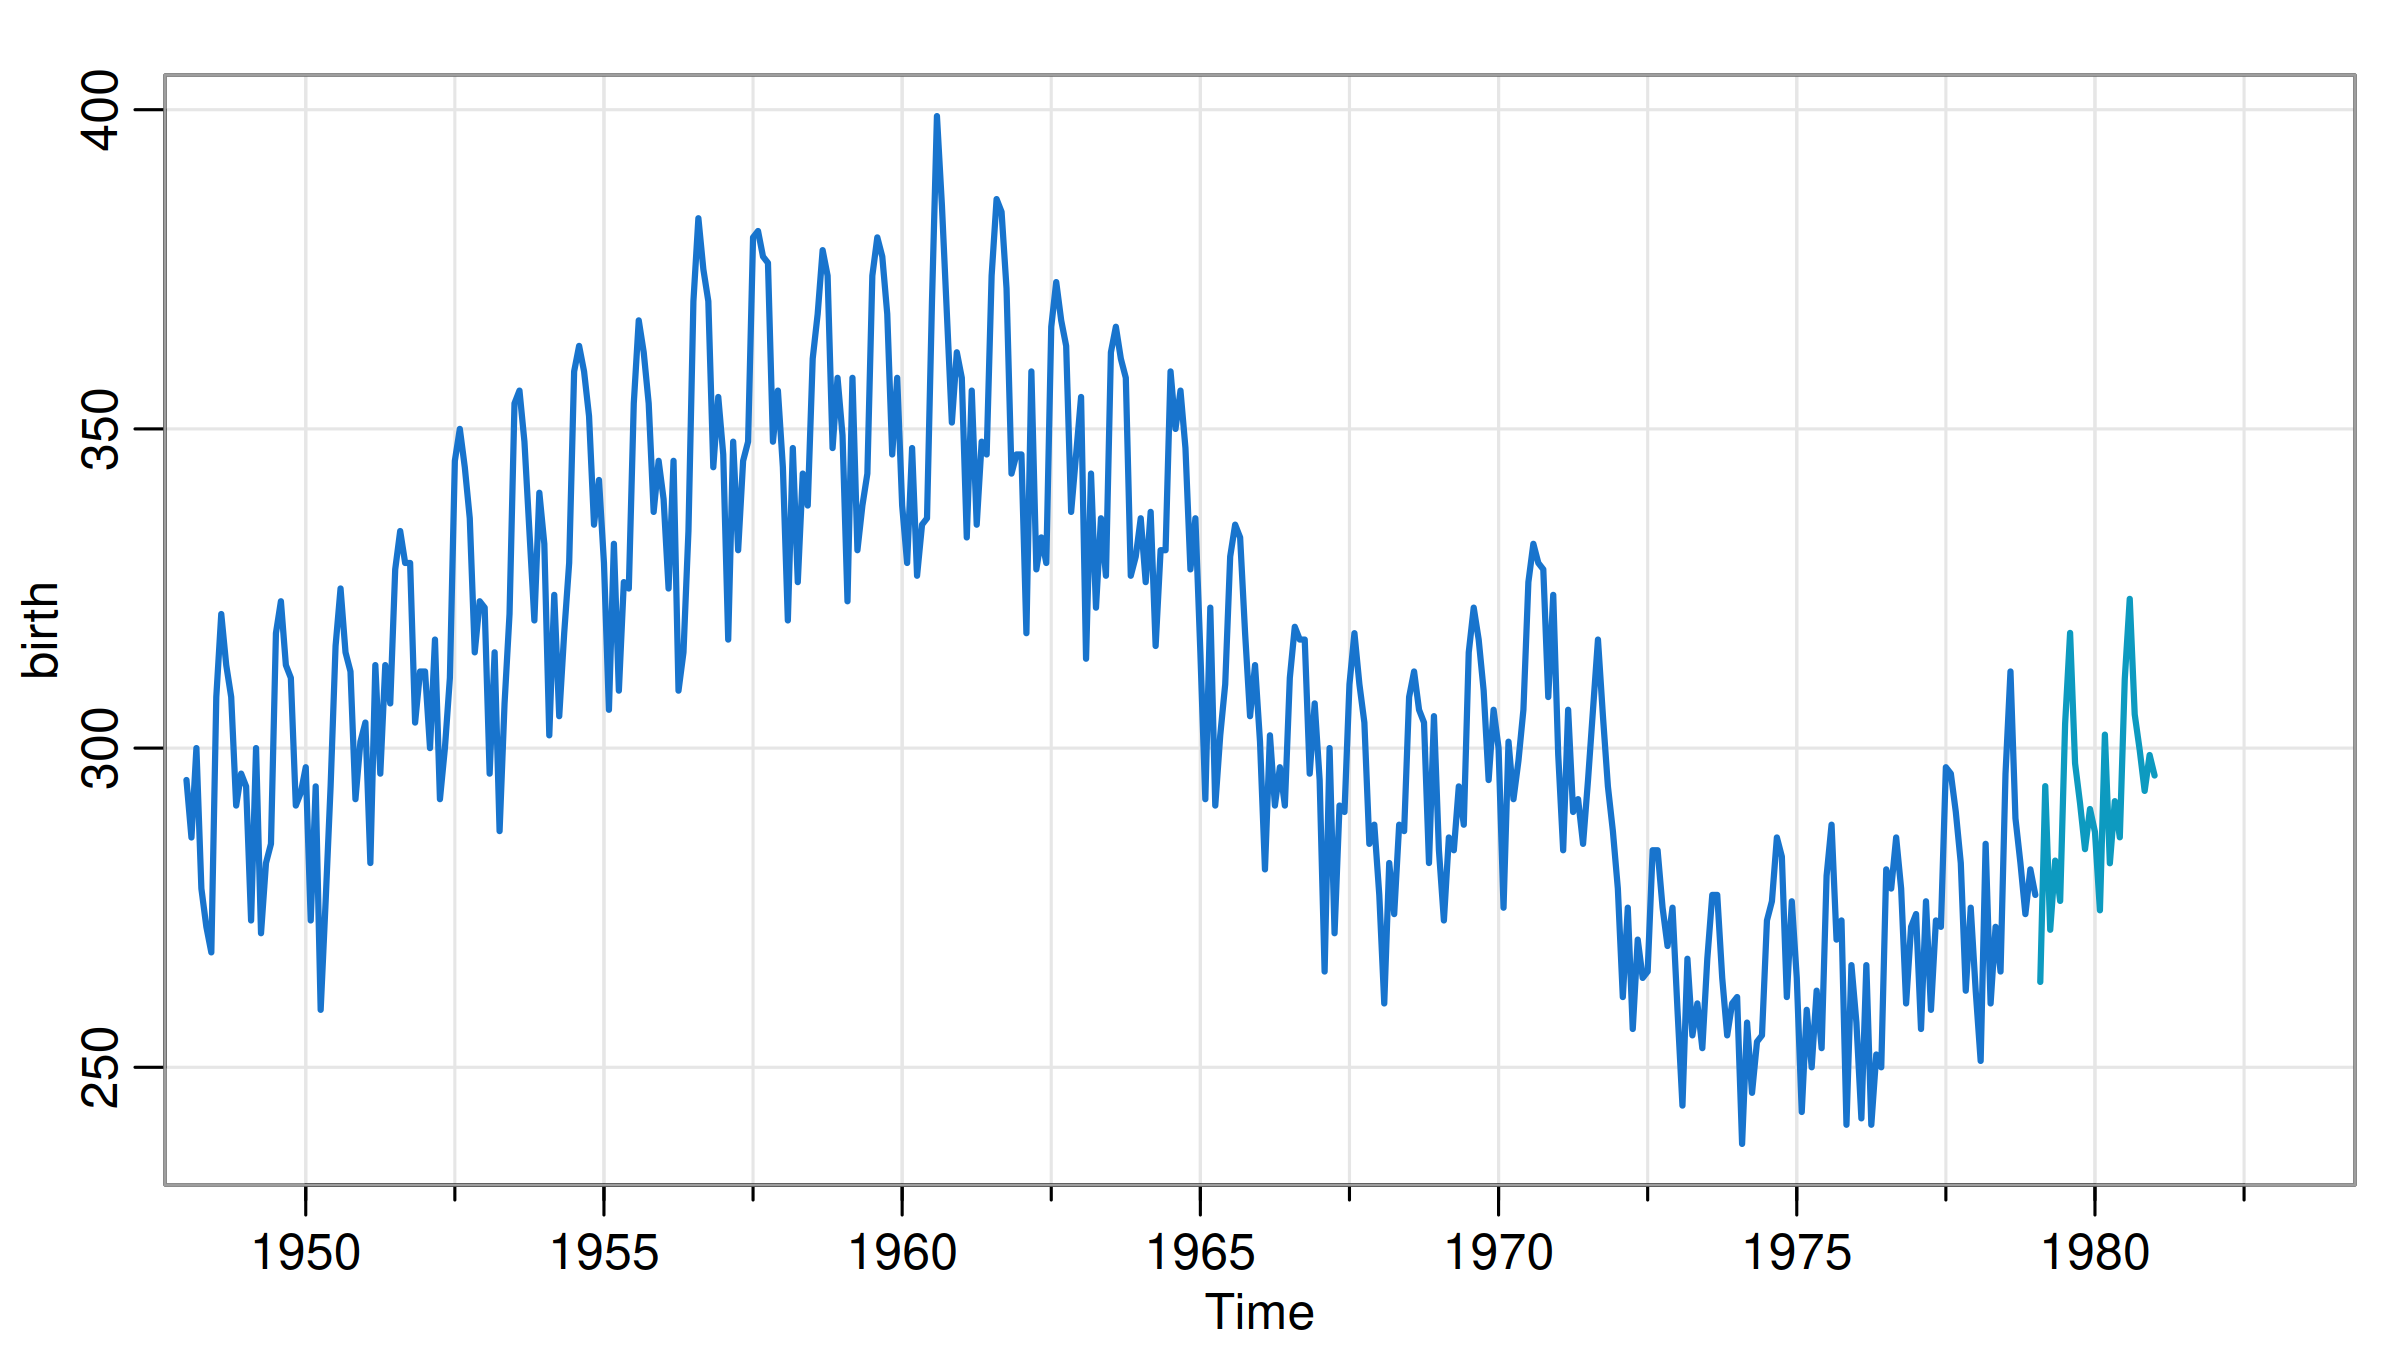

In [45]:
xpredict = forecast(fit, n=48)
birth_predict_log = log(birth[length(birth)]) + cumsum(xpredict$mean)
birth_predict = ts(exp(birth_predict_log), start=1979.083, freq=12)
tsplot(birth, lwd=2, col=4, xlim=c(1949,1983))
lines(birth_predict, lwd=2, col=5)


### Modelo SARIMA general

En el ejemplo anterior, tuvimos que *diferenciar* la serie `log(birth)` para lograr algo estacionario. Esto nos lleva al modelo SARIMA general, en el cual los parámetros son:

* $(p,d,q)$, las componentes locales del modelo sarima. $d$ es la cantidad de veces que hay que diferenciar con la muestra anterior.
* $(P,D,Q)$, las componentes estacionales del modelo sarima. $D$ es la cantidad de veces que hay que diferenciar con la estación anterior.
* $s$ es la frecuencia de las estaciones.

Para el caso anterior, podemos directamente ajustar un modelo $SARIMA(0,1,1)\times (1,0,0)_{12}$ pasándole el problema de diferenciar al ajuste.

In [46]:
x=log(birth)
fit = Arima(x, order = c(0, 1, 1), seasonal = c(1, 0, 0))
summary(fit)

Series: x 
ARIMA(0,1,1)(1,0,0)[12] 

Coefficients:
          ma1    sar1
      -0.5022  0.8670
s.e.   0.0557  0.0246

sigma^2 = 0.0007279:  log likelihood = 808.58
AIC=-1611.17   AICc=-1611.1   BIC=-1599.41

Training set error measures:
                       ME       RMSE        MAE         MPE      MAPE      MASE
Training set 0.0001851173 0.02687157 0.02094215 0.002037553 0.3664133 0.6531025
                   ACF1
Training set 0.07119551

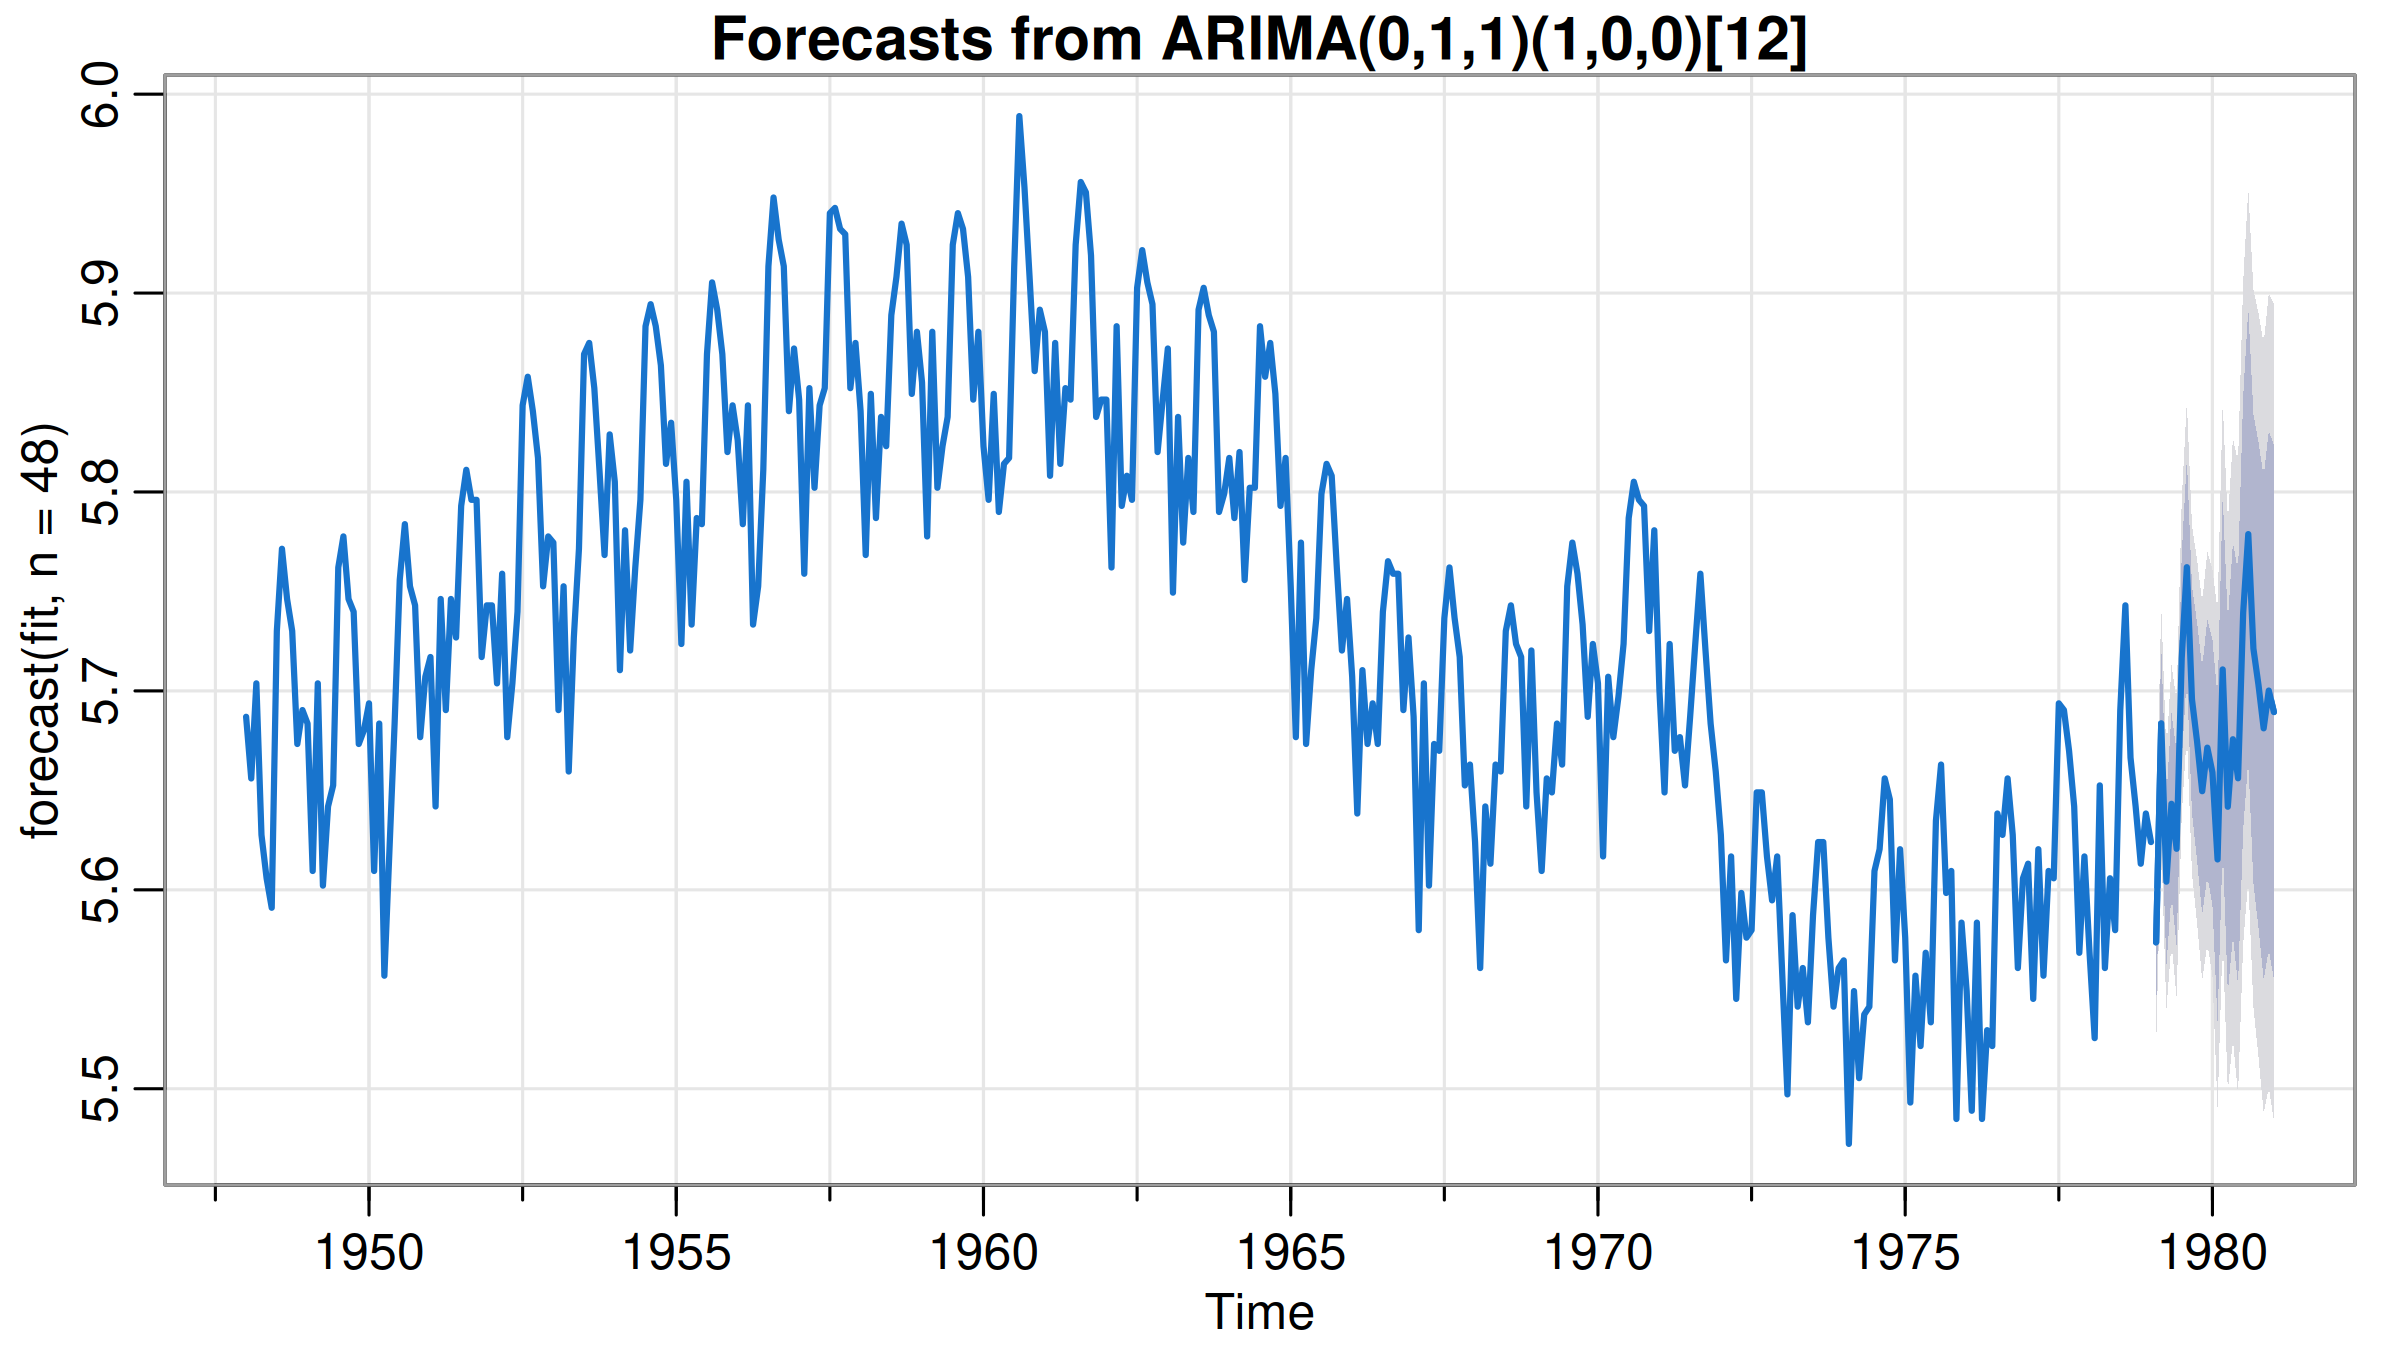

In [47]:
tsplot(forecast(fit, n=48), lwd=2, col=4)

## Ejercicio

Repetir el ejercicio anterior a partir de la serie `log(varve)` utilizando la biblioteca `forecast` utilizando un modelo ARIMA con $I=1$ (para reproducir el `diff` realizado en el ejericio anterior), utilizando los primeros $n=600$ datos. Correr el diagnóstico de residuos al análisis

Por último, predecir los últimos $34$ valores y comparar.